**Reset and Restart**

*Use this block to reset and restart the runtime*

In [ ]:
import os
os.kill(os.getpid(), 9)

**Un-install and Install dependencies**

In [ ]:
# Uninstall and reinstall libraries
!pip uninstall -y scipy gensim
!pip install scipy==1.12.0 gensim==4.3.1

Found existing installation: scipy 1.14.1
Uninstalling scipy-1.14.1:
  Successfully uninstalled scipy-1.14.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 541.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 32.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [ ]:
pip install spacy==3.6.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.4/917.4 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 34.4 MB/s eta 0:00:00
  Attempting uninstall: typer
    Found existing installation: typer 0.15.2
    Uninstalling typer-0.15.2:
      Successfully uninstalled typer-0.15.2
  Attempting uninstall: smart-open
    Found existing installation: smart-open 7.1.0
    Uninstalling smart-open-7.1.0:
      Successfully uninstalled smart-open-7.1.0
  Attempting uninstall: blis
    Found existing installation: blis 1.2.0
    Uninstalling blis-1.2.0:
      Successfully uninstalled blis-1.2.0
  Attempting uninstall: thinc
    Found existing installation: thi

In [ ]:
!pip install nltk

In [ ]:
!python -m spacy download en_core_web_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


**ELMO and Brown Processing**

*This block handles ELMO architecture and Brown corpus processing, as well the training of ELMO*

In [ ]:
# ELMO.py
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import nltk
import spacy
from collections import Counter
import pickle
from gensim.models import KeyedVectors
from tqdm import tqdm

# Download resources
nltk.download('brown')
from nltk.corpus import brown

# Load spaCy tokenizer
nlp = spacy.load("en_core_web_sm")

# Hyperparameters
vocabSize = 20000
minFreq = 2
padToken = "<PAD>"
startToken = "<START>"
endToken = "<END>"
unkToken = "<UNK>"
maxSeqLen = 50
batchSize = 32
embeddingDim = 300
hiddenSize = 512
numLayers = 2
dropout = 0.33
numEpochs = 3
device = "cuda" if torch.cuda.is_available() else "cpu"

# Dataset Class
class BrownLanguageModelDataset(Dataset):
    def __init__(self, tokenizedSentences, wordToIndex):
        self.data = []
        padIndex = wordToIndex[padToken]
        for sentence in tokenizedSentences:
            encoded = [wordToIndex.get(word, wordToIndex[unkToken]) for word in sentence]
            forwardIn, forwardOut, backwardIn, backwardOut = self.createInputTargetPairs(encoded, wordToIndex)
            forwardIn = self.padSequence(forwardIn, maxSeqLen, padIndex)
            forwardOut = self.padSequence(forwardOut, maxSeqLen, padIndex)
            backwardIn = self.padSequence(backwardIn, maxSeqLen, padIndex)
            backwardOut = self.padSequence(backwardOut, maxSeqLen, padIndex)
            self.data.append((forwardIn, forwardOut, backwardIn, backwardOut))

    def createInputTargetPairs(self, encodedSentence, wordToIndex):
        forwardInput = [wordToIndex[startToken]] + encodedSentence[:-1]
        forwardTarget = encodedSentence
        backwardInput = [wordToIndex[endToken]] + list(reversed(encodedSentence[1:]))
        backwardTarget = list(reversed(encodedSentence))
        return forwardInput, forwardTarget, backwardInput, backwardTarget

    def padSequence(self, sequence, maxLength, padIndex):
        return sequence[:maxLength] + [padIndex] * max(0, maxLength - len(sequence))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        forwardIn, forwardOut, backwardIn, backwardOut = self.data[idx]
        return (torch.tensor(forwardIn), torch.tensor(forwardOut),
                torch.tensor(backwardIn), torch.tensor(backwardOut))

# ELMo Model
class ELMoBiLSTM(nn.Module):
    def __init__(self, embeddingLayer, hiddenSize=512, numLayers=2, dropout=0.33):
        super(ELMoBiLSTM, self).__init__()
        self.embedding = embeddingLayer
        self.biLSTM = nn.LSTM(
            input_size=embeddingLayer.embedding_dim,
            hidden_size=hiddenSize,
            num_layers=numLayers,
            dropout=dropout,
            bidirectional=True,
            batch_first=True
        )
        self.outputHead = nn.Linear(hiddenSize * 2, embeddingLayer.num_embeddings)

    def forward(self, inputSeq):
        embedded = self.embedding(inputSeq)
        lstmOut, _ = self.biLSTM(embedded)
        output = self.outputHead(lstmOut)
        return output, lstmOut

# Preprocessing Functions
def getTokenizedSentences():
    rawSentences = brown.sents()
    tokenizedSentences = []
    for sentence in rawSentences:
        text = " ".join(sentence)
        doc = nlp(text)
        tokens = [token.lemma_.lower() for token in doc if token.is_alpha]
        if tokens:
            tokenizedSentences.append(tokens)
    return tokenizedSentences

def buildVocabulary(tokenizedSentences):
    wordFreq = Counter()
    for sentence in tokenizedSentences:
        wordFreq.update(sentence)
    mostCommonWords = [word for word, freq in wordFreq.items() if freq >= minFreq][:vocabSize - 4]
    vocab = [padToken, startToken, endToken, unkToken] + mostCommonWords
    wordToIndex = {word: idx for idx, word in enumerate(vocab)}
    indexToWord = {idx: word for word, idx in wordToIndex.items()}
    return wordToIndex, indexToWord

def buildEmbeddingTensor(wordToIndex):
    word2vecPath = "/content/drive/MyDrive/word2vec-google/word2vec-google-news-300.model"
    word2vecModel = KeyedVectors.load(word2vecPath, mmap='r')
    embeddingMatrix = torch.zeros((len(wordToIndex), embeddingDim))
    for word, idx in wordToIndex.items():
        if word in word2vecModel:
            embeddingMatrix[idx] = torch.tensor(word2vecModel[word])
        else:
            embeddingMatrix[idx] = torch.randn(embeddingDim)
    return embeddingMatrix

def savePreprocessedData():
    tokenizedSentences = getTokenizedSentences()
    wordToIndex, indexToWord = buildVocabulary(tokenizedSentences)
    dataset = BrownLanguageModelDataset(tokenizedSentences, wordToIndex)
    embeddingTensor = buildEmbeddingTensor(wordToIndex)
    with open("brown_data.pkl", "wb") as f:
        pickle.dump({
            "tokenizedSentences": tokenizedSentences,
            "wordToIndex": wordToIndex,
            "indexToWord": indexToWord,
            "dataset": dataset,
            "embeddingTensor": embeddingTensor
        }, f)
    return dataset, wordToIndex, embeddingTensor

# Training Function
def train_elmo():
    dataset, wordToIndex, embeddingTensor = savePreprocessedData()
    dataloader = DataLoader(dataset, batch_size=batchSize, shuffle=True)
    embeddingLayer = nn.Embedding.from_pretrained(embeddingTensor, freeze=True).to(device)
    model = ELMoBiLSTM(embeddingLayer, hiddenSize, numLayers, dropout).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=wordToIndex[padToken])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    print("Starting ELMo pre-training...")
    for epoch in range(numEpochs):
        model.train()
        totalLoss = 0
        for fwdIn, fwdOut, bwdIn, bwdOut in tqdm(dataloader, desc=f"Epoch {epoch+1}/{numEpochs}"):
            fwdIn, fwdOut = fwdIn.to(device), fwdOut.to(device)
            bwdIn, bwdOut = bwdIn.to(device), bwdOut.to(device)

            # Forward pass
            fwdLogits, _ = model(fwdIn)
            fwdLoss = criterion(fwdLogits.view(-1, embeddingLayer.num_embeddings), fwdOut.view(-1))

            # Backward pass
            bwdLogits, _ = model(bwdIn)
            bwdLoss = criterion(bwdLogits.view(-1, embeddingLayer.num_embeddings), bwdOut.view(-1))

            loss = fwdLoss + bwdLoss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            totalLoss += loss.item()

        avgLoss = totalLoss / len(dataloader)
        print(f"Epoch {epoch+1}/{numEpochs} - Avg Loss: {avgLoss:.4f}")

    torch.save(model.state_dict(), "bilstm.pt")
    print("✔ ELMo model saved to bilstm.pt")

if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive')
    train_elmo()

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


Mounted at /content/drive
Starting ELMo pre-training...


Epoch 1/3: 100%|██████████| 1776/1776 [05:49<00:00,  5.08it/s]


Epoch 1/3 - Avg Loss: 4.4354


Epoch 2/3: 100%|██████████| 1776/1776 [05:55<00:00,  5.00it/s]


Epoch 2/3 - Avg Loss: 0.9859


Epoch 3/3: 100%|██████████| 1776/1776 [05:57<00:00,  4.96it/s]


Epoch 3/3 - Avg Loss: 0.6480
✔ ELMo model saved to bilstm.pt


**Classifier Training**

*This block only handles the ELMO based classifier, for SVD, C-BOW and SkipGram refer the next cell, they are trained on 100 dim embeddings*

Mounted at /content/drive

 Training with trainable method...


Epoch 1/10: 100%|██████████| 106/106 [00:36<00:00,  2.88it/s]



Epoch 1/10 - Avg Loss: 0.7100


Epoch 2/10: 100%|██████████| 106/106 [00:35<00:00,  2.96it/s]



Epoch 2/10 - Avg Loss: 0.4444


Epoch 3/10: 100%|██████████| 106/106 [00:36<00:00,  2.93it/s]



Epoch 3/10 - Avg Loss: 0.3775


Epoch 4/10: 100%|██████████| 106/106 [00:35<00:00,  2.96it/s]



Epoch 4/10 - Avg Loss: 0.3322


Epoch 5/10: 100%|██████████| 106/106 [00:36<00:00,  2.92it/s]



Epoch 5/10 - Avg Loss: 0.2950


Epoch 6/10: 100%|██████████| 106/106 [00:35<00:00,  2.96it/s]



Epoch 6/10 - Avg Loss: 0.2635


Epoch 7/10: 100%|██████████| 106/106 [00:36<00:00,  2.92it/s]



Epoch 7/10 - Avg Loss: 0.2278


Epoch 8/10: 100%|██████████| 106/106 [00:35<00:00,  2.95it/s]



Epoch 8/10 - Avg Loss: 0.1886


Epoch 9/10: 100%|██████████| 106/106 [00:36<00:00,  2.93it/s]



Epoch 9/10 - Avg Loss: 0.1555


Epoch 10/10: 100%|██████████| 106/106 [00:35<00:00,  2.96it/s]



Epoch 10/10 - Avg Loss: 0.1245
🔍 Train Evaluation:
Accuracy: 0.9757 | F1: 0.9757 | Precision: 0.9758 | Recall: 0.9757

Confusion Matrix:
[[26223   382   204   194]
 [   35 26948     6    27]
 [  234   107 25730   855]
 [  182    53   345 26475]]


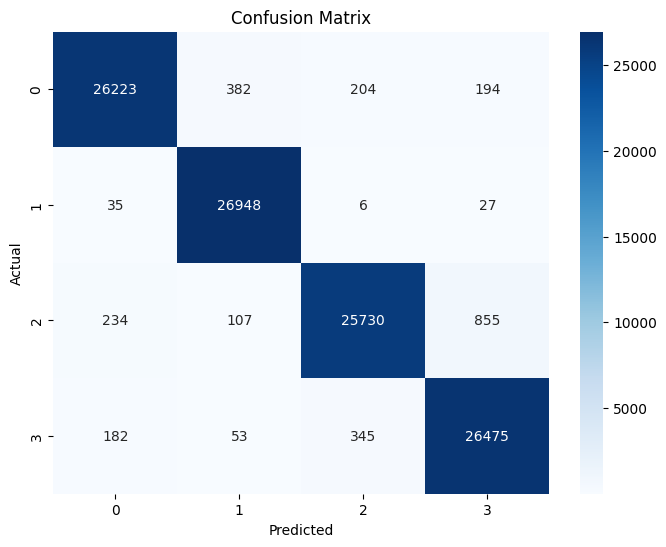

🧪 Test Evaluation:
Accuracy: 0.8599 | F1: 0.8594 | Precision: 0.8594 | Recall: 0.8601

Confusion Matrix:
[[1325   62   58   69]
 [  25 1445    9   31]
 [  88   34 1196  202]
 [  79   35  160 1262]]


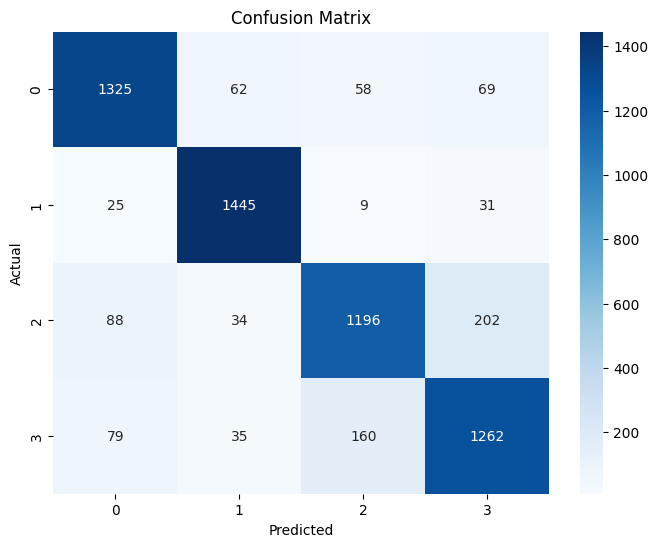

✔ Saved classifier_trainable.pt

 Training with frozen method...


Epoch 1/10: 100%|██████████| 106/106 [00:35<00:00,  2.97it/s]



Epoch 1/10 - Avg Loss: 0.7049


Epoch 2/10: 100%|██████████| 106/106 [00:36<00:00,  2.94it/s]



Epoch 2/10 - Avg Loss: 0.4524


Epoch 3/10: 100%|██████████| 106/106 [00:35<00:00,  2.98it/s]



Epoch 3/10 - Avg Loss: 0.3802


Epoch 4/10: 100%|██████████| 106/106 [00:35<00:00,  2.98it/s]



Epoch 4/10 - Avg Loss: 0.3323


Epoch 5/10: 100%|██████████| 106/106 [00:36<00:00,  2.94it/s]



Epoch 5/10 - Avg Loss: 0.2934


Epoch 6/10: 100%|██████████| 106/106 [00:35<00:00,  2.97it/s]



Epoch 6/10 - Avg Loss: 0.2646


Epoch 7/10: 100%|██████████| 106/106 [00:36<00:00,  2.94it/s]



Epoch 7/10 - Avg Loss: 0.2244


Epoch 8/10: 100%|██████████| 106/106 [00:35<00:00,  2.97it/s]



Epoch 8/10 - Avg Loss: 0.1874


Epoch 9/10: 100%|██████████| 106/106 [00:36<00:00,  2.94it/s]



Epoch 9/10 - Avg Loss: 0.1544


Epoch 10/10: 100%|██████████| 106/106 [00:35<00:00,  2.98it/s]



Epoch 10/10 - Avg Loss: 0.1247
🔍 Train Evaluation:
Accuracy: 0.9699 | F1: 0.9699 | Precision: 0.9701 | Recall: 0.9699

Confusion Matrix:
[[26589   159   163    92]
 [  327 26626    44    19]
 [  418    39 25914   555]
 [  661    32   746 25616]]


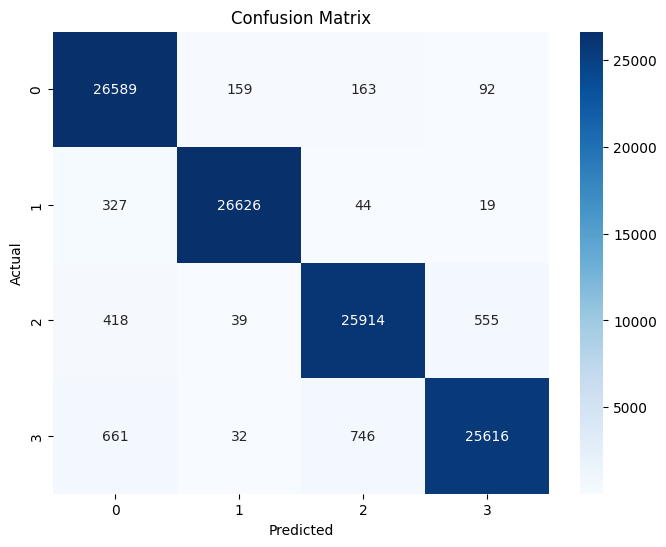

🧪 Test Evaluation:
Accuracy: 0.8605 | F1: 0.8605 | Precision: 0.8622 | Recall: 0.8608

Confusion Matrix:
[[1384   37   55   38]
 [  81 1386   18   25]
 [ 109   20 1243  148]
 [ 117   25  175 1219]]


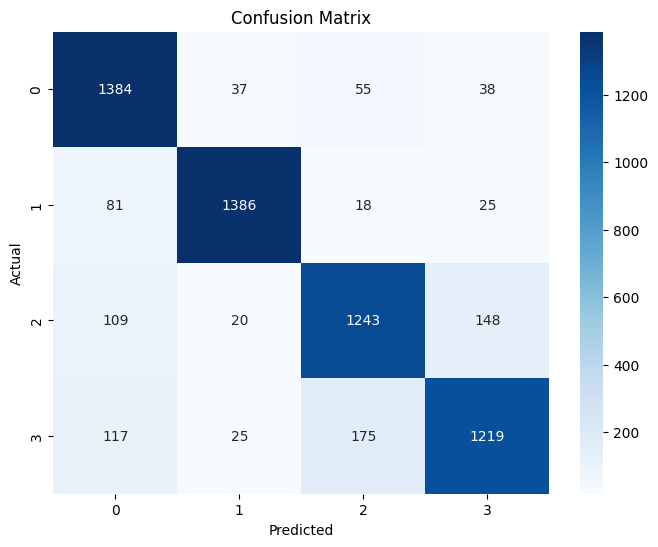

✔ Saved classifier_frozen.pt

 Training with learnable_fn method...


Epoch 1/10: 100%|██████████| 106/106 [00:39<00:00,  2.66it/s]



Epoch 1/10 - Avg Loss: 0.6355


Epoch 2/10: 100%|██████████| 106/106 [00:40<00:00,  2.63it/s]



Epoch 2/10 - Avg Loss: 0.3827


Epoch 3/10: 100%|██████████| 106/106 [00:39<00:00,  2.66it/s]



Epoch 3/10 - Avg Loss: 0.3278


Epoch 4/10: 100%|██████████| 106/106 [00:40<00:00,  2.63it/s]



Epoch 4/10 - Avg Loss: 0.2880


Epoch 5/10: 100%|██████████| 106/106 [00:39<00:00,  2.66it/s]



Epoch 5/10 - Avg Loss: 0.2550


Epoch 6/10: 100%|██████████| 106/106 [00:40<00:00,  2.63it/s]



Epoch 6/10 - Avg Loss: 0.2251


Epoch 7/10: 100%|██████████| 106/106 [00:39<00:00,  2.65it/s]



Epoch 7/10 - Avg Loss: 0.2042


Epoch 8/10: 100%|██████████| 106/106 [00:40<00:00,  2.63it/s]



Epoch 8/10 - Avg Loss: 0.1815


Epoch 9/10: 100%|██████████| 106/106 [00:39<00:00,  2.66it/s]



Epoch 9/10 - Avg Loss: 0.1711


Epoch 10/10: 100%|██████████| 106/106 [00:39<00:00,  2.66it/s]



Epoch 10/10 - Avg Loss: 0.1517
🔍 Train Evaluation:
Accuracy: 0.9575 | F1: 0.9575 | Precision: 0.9586 | Recall: 0.9574

Confusion Matrix:
[[25722   384   387   510]
 [   83 26798    35   100]
 [  235   129 24545  2017]
 [  208    74   431 26342]]


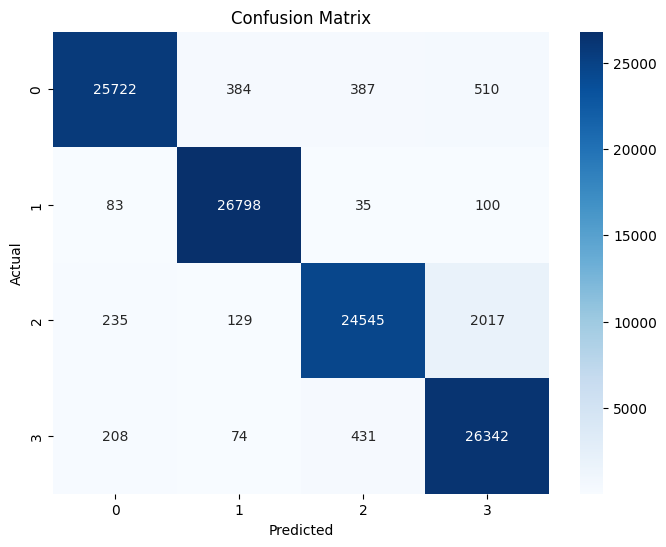

🧪 Test Evaluation:
Accuracy: 0.8707 | F1: 0.8708 | Precision: 0.8727 | Recall: 0.8708

Confusion Matrix:
[[1310   52   67   85]
 [  39 1426   11   34]
 [  70   22 1209  219]
 [  46   37  104 1349]]


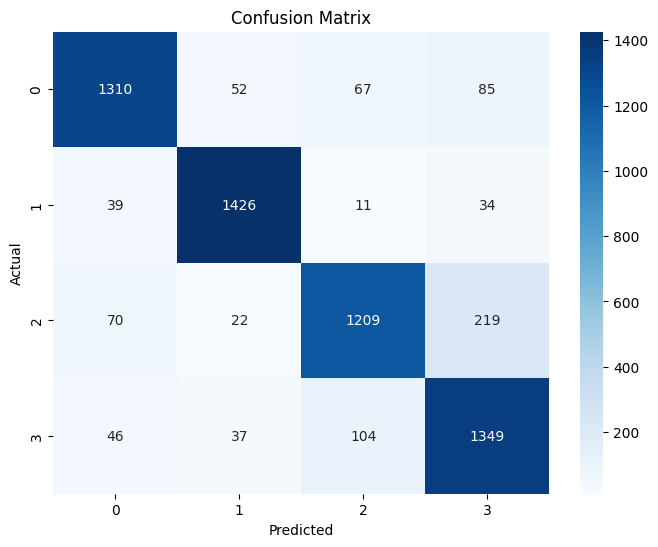

✔ Saved classifier_learnable_fn.pt


In [ ]:
# classification.py
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import pickle
import spacy
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



# Load spaCy
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

# ELMo Model (same as ELMO.py)
class ELMoBiLSTM(nn.Module):
    def __init__(self, embeddingLayer, hiddenSize=512, numLayers=2, dropout=0.33):
        super(ELMoBiLSTM, self).__init__()
        self.embedding = embeddingLayer
        self.biLSTM = nn.LSTM(
            input_size=embeddingLayer.embedding_dim,
            hidden_size=hiddenSize,
            num_layers=numLayers,
            dropout=dropout,
            bidirectional=True,
            batch_first=True
        )
        self.outputHead = nn.Linear(hiddenSize * 2, embeddingLayer.num_embeddings)

    def forward(self, inputSeq):
        embedded = self.embedding(inputSeq)
        lstmOut, _ = self.biLSTM(embedded)
        output = self.outputHead(lstmOut)
        return output, lstmOut


class BrownLanguageModelDataset(Dataset):
    def __init__(self, tokenizedSentences, wordToIndex):
        self.data = []
        padIndex = wordToIndex[padToken]
        for sentence in tokenizedSentences:
            encoded = [wordToIndex.get(word, wordToIndex[unkToken]) for word in sentence]
            forwardIn, forwardOut, backwardIn, backwardOut = self.createInputTargetPairs(encoded, wordToIndex)
            forwardIn = self.padSequence(forwardIn, maxSeqLen, padIndex)
            forwardOut = self.padSequence(forwardOut, maxSeqLen, padIndex)
            backwardIn = self.padSequence(backwardIn, maxSeqLen, padIndex)
            backwardOut = self.padSequence(backwardOut, maxSeqLen, padIndex)
            self.data.append((forwardIn, forwardOut, backwardIn, backwardOut))

    def createInputTargetPairs(self, encodedSentence, wordToIndex):
        forwardInput = [wordToIndex[startToken]] + encodedSentence[:-1]
        forwardTarget = encodedSentence
        backwardInput = [wordToIndex[endToken]] + list(reversed(encodedSentence[1:]))
        backwardTarget = list(reversed(encodedSentence))
        return forwardInput, forwardTarget, backwardInput, backwardTarget

    def padSequence(self, sequence, maxLength, padIndex):
        return sequence[:maxLength] + [padIndex] * max(0, maxLength - len(sequence))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        forwardIn, forwardOut, backwardIn, backwardOut = self.data[idx]
        return (torch.tensor(forwardIn), torch.tensor(forwardOut),
                torch.tensor(backwardIn), torch.tensor(backwardOut))

# Layer Combiner
class ELMoLayerCombiner(nn.Module):
    def __init__(self, method="trainable", embeddingDim=300, lstmDim=512, outputDim=None):
        super().__init__()
        self.method = method
        if method == "trainable":
            self.lambdas = nn.Parameter(torch.ones(3))
        elif method == "frozen":
            self.register_buffer("lambdas", torch.tensor([0.3, 0.3, 0.4]))
        elif method == "learnable_fn":
            inputDim = embeddingDim + 2 * lstmDim * 2
            outDim = outputDim if outputDim else inputDim
            self.projection = nn.Sequential(
                nn.Linear(inputDim, 512),
                nn.ReLU(),
                nn.Linear(512, outDim)
            )
        else:
            raise ValueError("Invalid method")

    def forward(self, e0, e1, e2):
        if self.method in ["trainable", "frozen"]:
            weights = torch.softmax(self.lambdas, dim=0)
            if e0.shape[-1] != e1.shape[-1]:
                e0 = nn.functional.pad(e0, (0, e1.shape[-1] - e0.shape[-1]))
            return weights[0] * e0 + weights[1] * e1 + weights[2] * e2
        elif self.method == "learnable_fn":
            return self.projection(torch.cat([e0, e1, e2], dim=-1))

# GRU Classifier
class GRUClassifier(nn.Module):
    def __init__(self, inputDim, hiddenSize=128, numClasses=4):
        super().__init__()
        self.gru = nn.GRU(inputDim, hiddenSize, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(hiddenSize * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, numClasses)
        )

    def forward(self, x):
        _, h = self.gru(x)
        h_cat = torch.cat([h[0], h[1]], dim=1)
        return self.classifier(h_cat)

# AG News Dataset
class AGNewsDataset(Dataset):
    def __init__(self, filePath, subsetFraction=1.0):
        df = pd.read_pickle(filePath)

        if subsetFraction < 1.0:
            subsetSize = int(len(df) * subsetFraction)
            df = df.sample(n=subsetSize, random_state=42).reset_index(drop=True)  # ✅ Random subset

        self.inputs = df["input_ids"].tolist()
        self.labels = (df["label"] - 1).tolist()  # Shift labels from 1-4 to 0-3

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx]), torch.tensor(self.labels[idx])


# Preprocessing AG News
def preprocess_ag_news(csv_path, out_path, wordToIndex):
    df = pd.read_csv(csv_path).dropna(subset=["Description"])
    df["input_ids"] = df["Description"].apply(lambda x: tokenize_and_encode(x, wordToIndex))
    df["label"] = df["Class Index"]
    df[["input_ids", "label"]].to_pickle(out_path)
    print(f"✔ Saved {out_path} with {len(df)} examples")

def tokenize_and_encode(text, wordToIndex):
    tokens = [t.lemma_.lower() for t in nlp(text) if t.is_alpha]
    idxs = [wordToIndex.get(tok, wordToIndex["<UNK>"]) for tok in tokens]
    return idxs[:50] + [wordToIndex["<PAD>"]] * max(0, 50 - len(idxs))


def evaluate_model(classifier, elmoModel, combiner, dataLoader, device):
    classifier.eval()
    allPreds, allLabels = [], []

    with torch.no_grad():
        for tokens, labels in dataLoader:
            tokens, labels = tokens.to(device), labels.to(device)
            e0 = elmoModel.embedding(tokens)
            _, lstmOut = elmoModel(tokens)
            contextual = combiner(e0, lstmOut, lstmOut)
            logits = classifier(contextual)
            preds = torch.argmax(logits, dim=1)
            allPreds.extend(preds.cpu().tolist())
            allLabels.extend(labels.cpu().tolist())

    # Compute standard metrics.
    acc       = accuracy_score(allLabels, allPreds)
    f1        = f1_score(allLabels, allPreds, average='macro')
    precision = precision_score(allLabels, allPreds, average='macro')
    recall    = recall_score(allLabels, allPreds, average='macro')

    # Compute the confusion matrix for 4 classes.
    cm = confusion_matrix(allLabels, allPreds, labels=[0, 1, 2, 3])

    print(f"Accuracy: {acc:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
    print("\nConfusion Matrix:")
    print(cm)

    # Optionally, plot the confusion matrix.
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return acc, f1, precision, recall, cm




def train_classifier(method="trainable"):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    with open("brown_data.pkl", "rb") as f:
        data = pickle.load(f)
    wordToIndex = data["wordToIndex"]
    embeddingTensor = data["embeddingTensor"]

    embeddingLayer = nn.Embedding.from_pretrained(embeddingTensor, freeze=True).to(device)
    elmoModel = ELMoBiLSTM(embeddingLayer, hiddenSize=512, numLayers=2, dropout=0.33).to(device)
    elmoModel.load_state_dict(torch.load("bilstm.pt", map_location=device))
    elmoModel.eval()
    for param in elmoModel.parameters():
        param.requires_grad = False

    combiner = ELMoLayerCombiner(method=method).to(device)

    trainData = AGNewsDataset("train_preprocessed.pkl", subsetFraction=0.9)
    testData = AGNewsDataset("test_preprocessed.pkl", subsetFraction=0.8)
    trainLoader = DataLoader(trainData, batch_size=1024, shuffle=True)
    testLoader = DataLoader(testData, batch_size=1024)

    sample_input, _ = trainData[0]
    with torch.no_grad():
        e0 = elmoModel.embedding(sample_input.unsqueeze(0).to(device))
        _, lstmOut = elmoModel(sample_input.unsqueeze(0).to(device))
        final = combiner(e0, lstmOut, lstmOut)
    embedDim = final.shape[-1]

    classifier = GRUClassifier(inputDim=embedDim).to(device)
    optimizer = torch.optim.Adam(
        list(classifier.parameters()) + list(combiner.parameters()),
        lr=1e-3
    )
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(10):
        classifier.train()
        totalLoss = 0
        for tokens, labels in tqdm(trainLoader, desc=f"Epoch {epoch+1}/10"):
            tokens, labels = tokens.to(device), labels.to(device)
            optimizer.zero_grad()
            e0 = elmoModel.embedding(tokens)
            _, lstmOut = elmoModel(tokens)
            contextual = combiner(e0, lstmOut, lstmOut)
            logits = classifier(contextual)
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()
            totalLoss += loss.item()

        avgLoss = totalLoss / len(trainLoader)
        print(f"\nEpoch {epoch+1}/10 - Avg Loss: {avgLoss:.4f}")

    print("🔍 Train Evaluation:")
    evaluate_model(classifier, elmoModel, combiner, trainLoader, device)
    print("🧪 Test Evaluation:")
    evaluate_model(classifier, elmoModel, combiner, testLoader, device)
    print("=" * 60)

    # Save both classifier and combiner state
    torch.save({
        'classifier_state_dict': classifier.state_dict(),
        'combiner_state_dict': combiner.state_dict(),
        'method': method,
        'wordToIndex': wordToIndex,
        'embeddingTensor': embeddingTensor
    }, f"classifier_{method}.pt")
    print(f"✔ Saved classifier_{method}.pt")


if __name__ == "__main__":
    import os
    from google.colab import drive
    drive.mount('/content/drive')
    for method in ["trainable","frozen", "learnable_fn"]:  # for method in ["trainable", "frozen", "learnable_fn"]:
        print(f"\n Training with {method} method...")
        train_classifier(method)

**Classifier Training**

*This blocks deal with classifier training for SVD, C-BOW and SkipGram, all are 100 dim, taken from assignment 3 (300 dim wasn't chosen due to poor quality of embeddings being produced in that case due to unavailability of resources for computing them )*

Using device: cuda
Training classifier with SVD embeddings...


Epoch 1/30: 100%|██████████| 211/211 [00:05<00:00, 39.34it/s]


🔍 Train Evaluation:
Accuracy: 0.7438 | F1: 0.7423 | Precision: 0.7425 | Recall: 0.7437

Confusion Matrix:
[[21155  2318  1775  1755]
 [ 1881 22895   494  1746]
 [ 2520  1226 18646  4534]
 [ 3055  2560  3811 17629]]


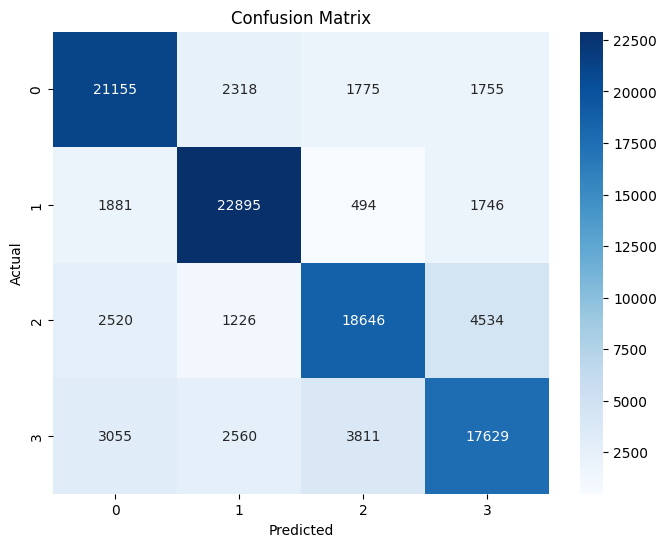

🧪 Test Evaluation:
Accuracy: 0.7296 | F1: 0.7283 | Precision: 0.7284 | Recall: 0.7301

Confusion Matrix:
[[1175  132  108   99]
 [ 126 1256   23  105]
 [ 142   72 1031  275]
 [ 167  165  230  974]]


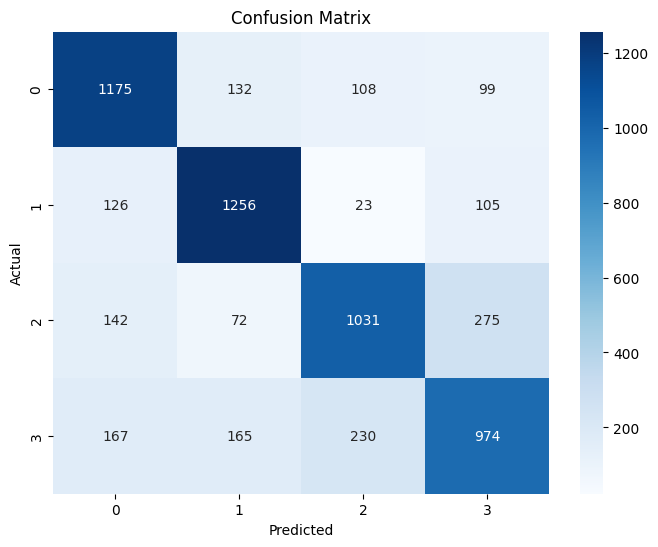

Epoch 1/30 - Avg Loss: 0.8525


Epoch 2/30: 100%|██████████| 211/211 [00:04<00:00, 42.81it/s]


🔍 Train Evaluation:
Accuracy: 0.7699 | F1: 0.7694 | Precision: 0.7742 | Recall: 0.7698

Confusion Matrix:
[[21266  1958  1420  2359]
 [ 1360 23506   421  1729]
 [ 2137   966 17834  5989]
 [ 2151  1920  2439 20545]]


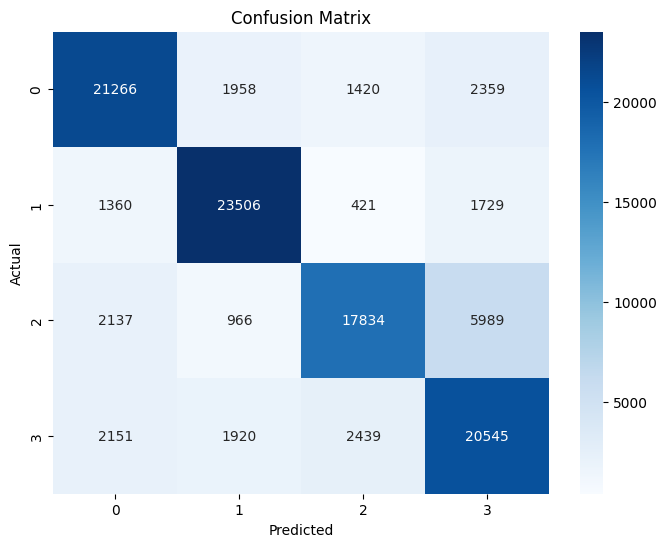

🧪 Test Evaluation:
Accuracy: 0.7599 | F1: 0.7598 | Precision: 0.7639 | Recall: 0.7601

Confusion Matrix:
[[1183  112   85  134]
 [  89 1295   25  101]
 [ 123   53 1002  342]
 [ 133  114  149 1140]]


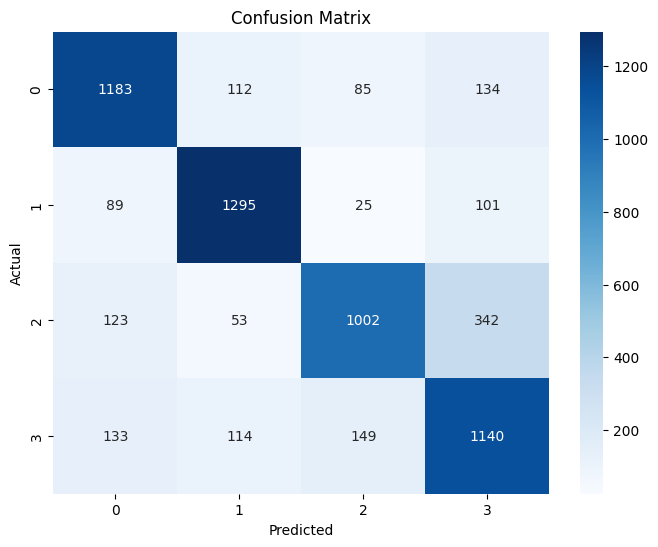

Epoch 2/30 - Avg Loss: 0.6634


Epoch 3/30: 100%|██████████| 211/211 [00:05<00:00, 39.22it/s]


🔍 Train Evaluation:
Accuracy: 0.7904 | F1: 0.7907 | Precision: 0.7924 | Recall: 0.7904

Confusion Matrix:
[[20801  1846  1811  2545]
 [  937 23705   632  1742]
 [ 1495   761 20386  4284]
 [ 1654  1450  3480 20471]]


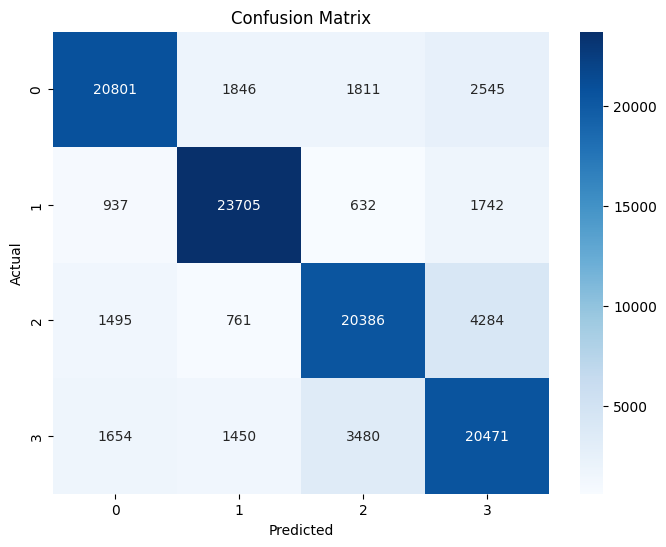

🧪 Test Evaluation:
Accuracy: 0.7748 | F1: 0.7754 | Precision: 0.7767 | Recall: 0.7751

Confusion Matrix:
[[1149  108  113  144]
 [  63 1303   36  108]
 [  96   46 1127  251]
 [ 102   92  210 1132]]


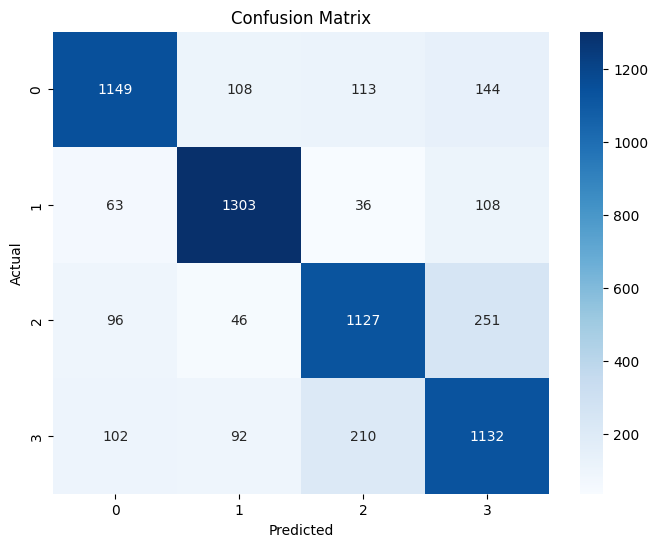

Epoch 3/30 - Avg Loss: 0.6145


Epoch 4/30: 100%|██████████| 211/211 [00:05<00:00, 38.49it/s]


🔍 Train Evaluation:
Accuracy: 0.8021 | F1: 0.8015 | Precision: 0.8019 | Recall: 0.8021

Confusion Matrix:
[[21643  1937  1687  1736]
 [ 1010 24351   484  1171]
 [ 1579   898 20212  4237]
 [ 1973  1700  2956 20426]]


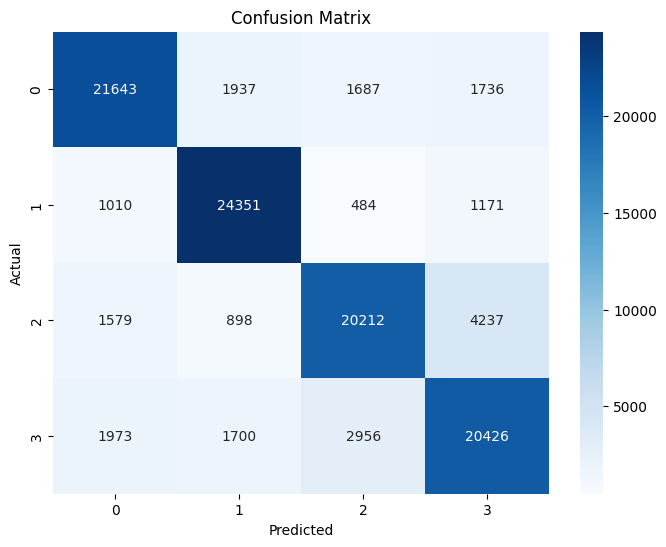

🧪 Test Evaluation:
Accuracy: 0.7817 | F1: 0.7814 | Precision: 0.7816 | Recall: 0.7821

Confusion Matrix:
[[1189  115  109  101]
 [  61 1334   30   85]
 [ 103   52 1109  256]
 [ 118  109  188 1121]]


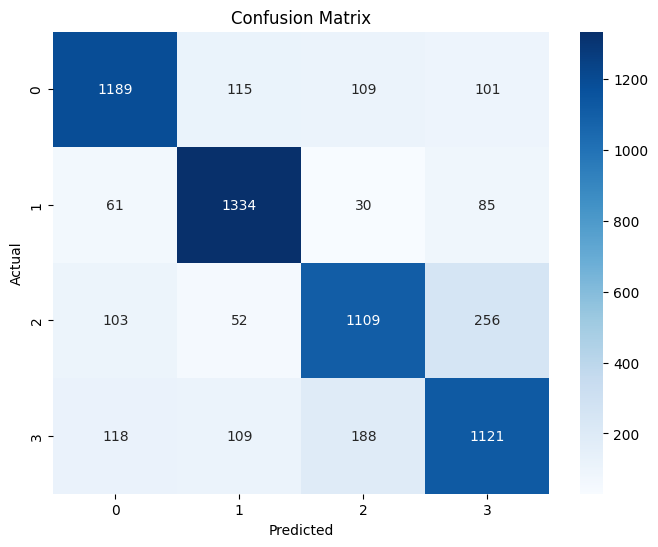

Epoch 4/30 - Avg Loss: 0.5776


Epoch 5/30: 100%|██████████| 211/211 [00:06<00:00, 34.51it/s]


🔍 Train Evaluation:
Accuracy: 0.8116 | F1: 0.8110 | Precision: 0.8108 | Recall: 0.8116

Confusion Matrix:
[[21989  1612  1867  1535]
 [ 1145 24294   575  1002]
 [ 1419   742 21457  3308]
 [ 2062  1385  3698 19910]]


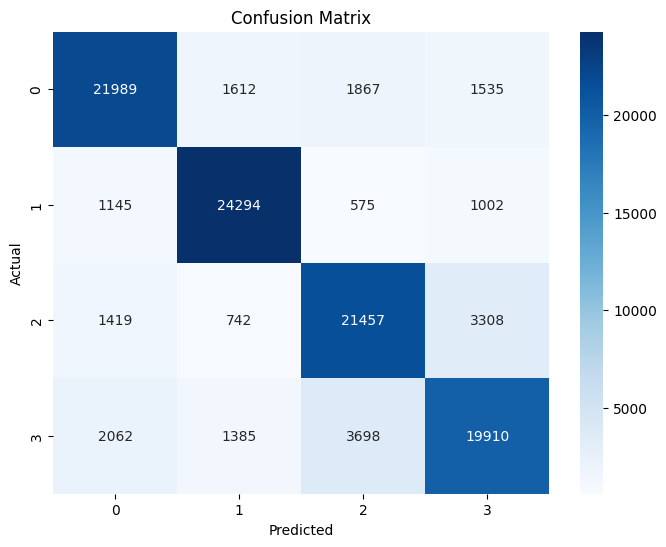

🧪 Test Evaluation:
Accuracy: 0.7893 | F1: 0.7890 | Precision: 0.7888 | Recall: 0.7897

Confusion Matrix:
[[1217  101  112   84]
 [  76 1319   37   78]
 [  97   45 1178  200]
 [ 126   86  239 1085]]


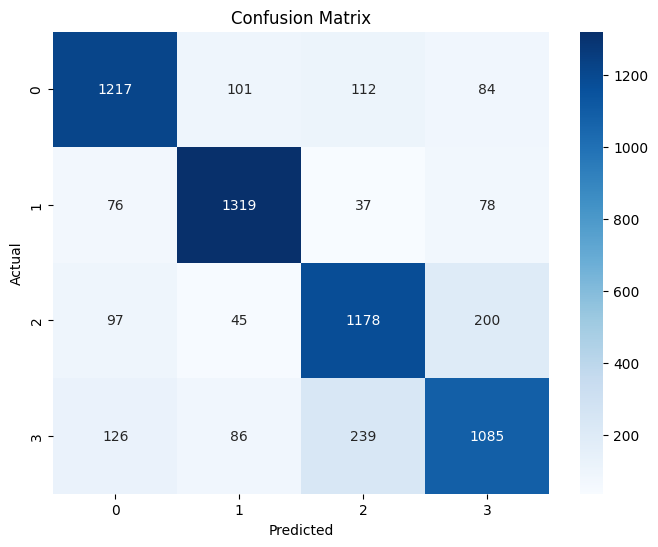

Epoch 5/30 - Avg Loss: 0.5501


Epoch 6/30: 100%|██████████| 211/211 [00:05<00:00, 38.57it/s]


🔍 Train Evaluation:
Accuracy: 0.8214 | F1: 0.8214 | Precision: 0.8220 | Recall: 0.8214

Confusion Matrix:
[[22237  1448  1522  1796]
 [  966 24327   390  1333]
 [ 1590   685 20738  3913]
 [ 1747  1056  2840 21412]]


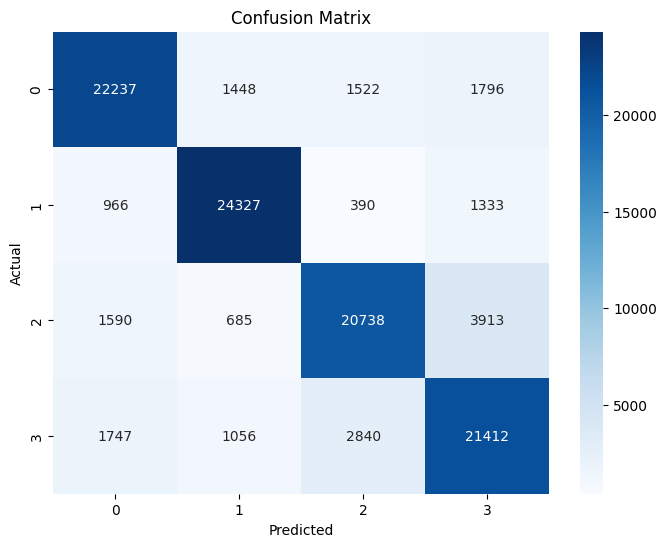

🧪 Test Evaluation:
Accuracy: 0.7965 | F1: 0.7968 | Precision: 0.7976 | Recall: 0.7968

Confusion Matrix:
[[1223   94   91  106]
 [  68 1316   29   97]
 [ 109   43 1127  241]
 [ 111   71  177 1177]]


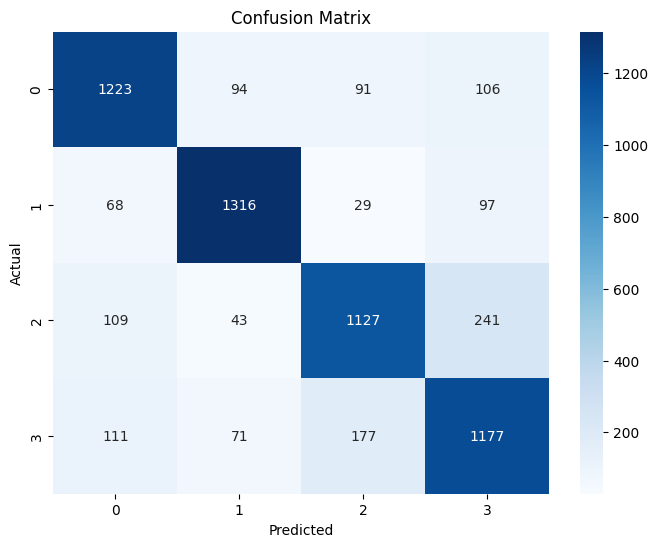

Epoch 6/30 - Avg Loss: 0.5250


Epoch 7/30: 100%|██████████| 211/211 [00:05<00:00, 39.23it/s]


🔍 Train Evaluation:
Accuracy: 0.8241 | F1: 0.8231 | Precision: 0.8242 | Recall: 0.8240

Confusion Matrix:
[[22789  1539  1236  1439]
 [  978 24877   213   948]
 [ 2009   887 20113  3917]
 [ 2110  1372  2352 21221]]


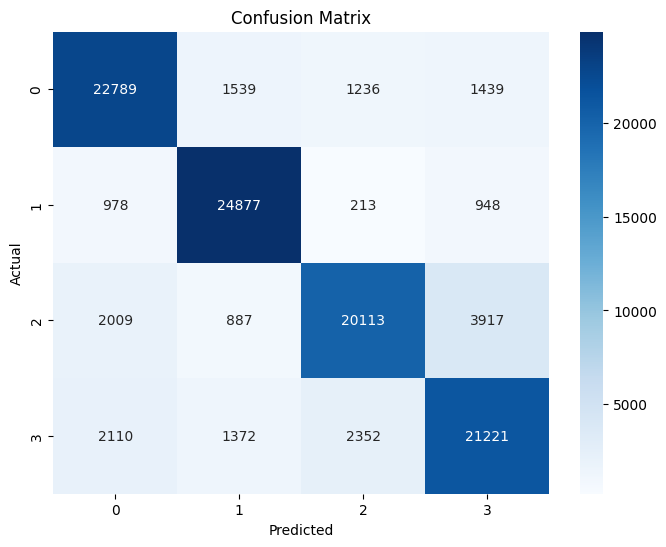

🧪 Test Evaluation:
Accuracy: 0.7967 | F1: 0.7959 | Precision: 0.7971 | Recall: 0.7970

Confusion Matrix:
[[1251  100   80   83]
 [  69 1350   18   73]
 [ 130   60 1080  250]
 [ 135   86  152 1163]]


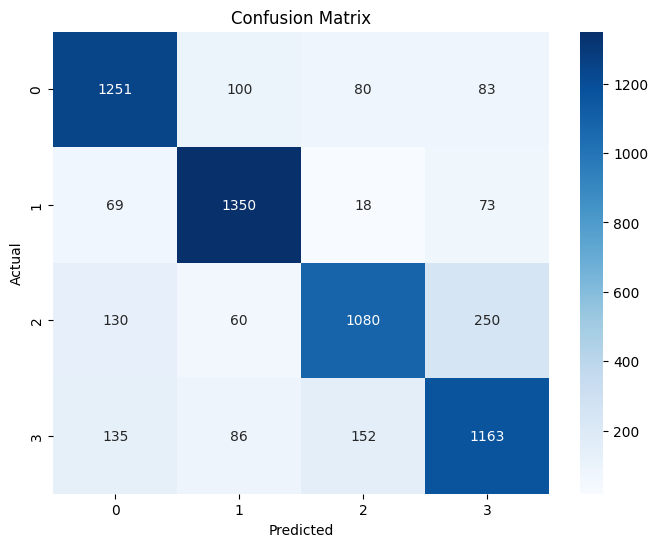

Epoch 7/30 - Avg Loss: 0.5053


Epoch 8/30: 100%|██████████| 211/211 [00:05<00:00, 38.55it/s]


🔍 Train Evaluation:
Accuracy: 0.8336 | F1: 0.8331 | Precision: 0.8349 | Recall: 0.8336

Confusion Matrix:
[[21378  1902  2012  1711]
 [  473 25280   405   858]
 [  920   712 21976  3318]
 [ 1197  1299  3169 21390]]


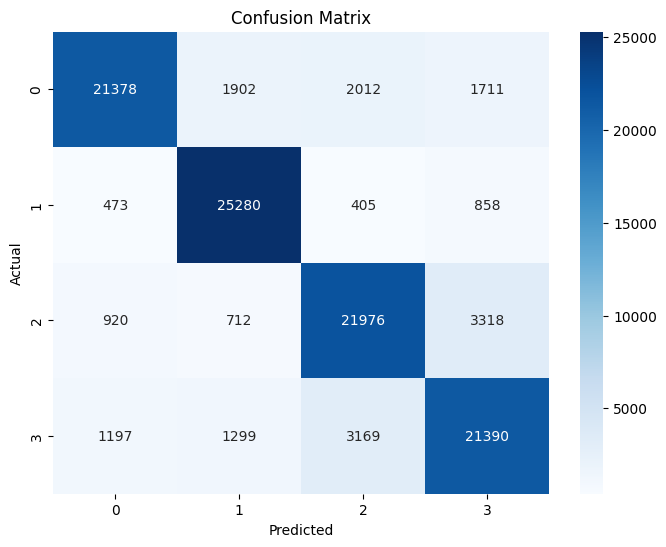

🧪 Test Evaluation:
Accuracy: 0.8028 | F1: 0.8024 | Precision: 0.8034 | Recall: 0.8031

Confusion Matrix:
[[1174  123  124   93]
 [  49 1367   32   62]
 [  78   46 1187  209]
 [  80   97  206 1153]]


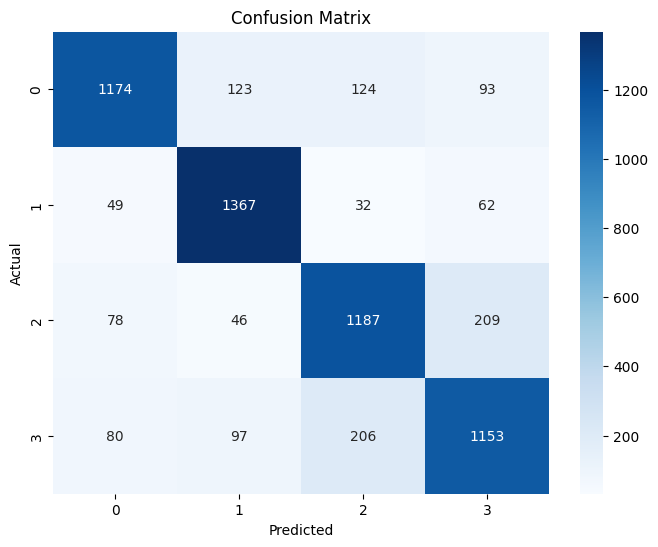

Epoch 8/30 - Avg Loss: 0.4868


Epoch 9/30: 100%|██████████| 211/211 [00:07<00:00, 29.69it/s]


🔍 Train Evaluation:
Accuracy: 0.8401 | F1: 0.8400 | Precision: 0.8400 | Recall: 0.8401

Confusion Matrix:
[[22876  1141  1653  1333]
 [  965 24594   629   828]
 [ 1295   451 21921  3259]
 [ 1752   908  3059 21336]]


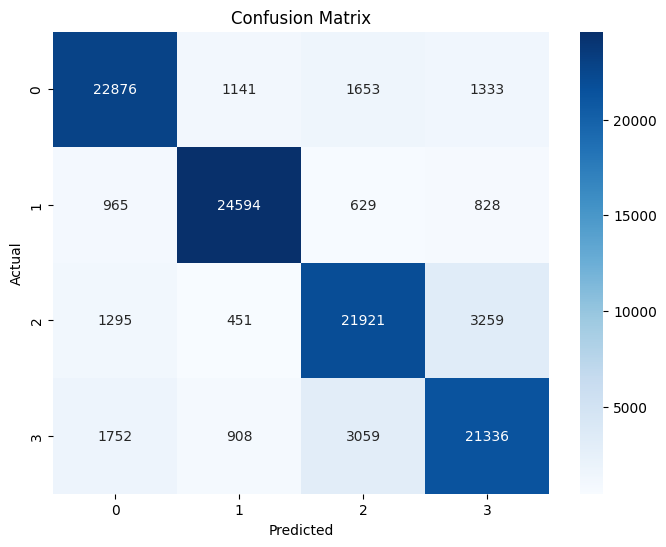

🧪 Test Evaluation:
Accuracy: 0.8104 | F1: 0.8105 | Precision: 0.8105 | Recall: 0.8107

Confusion Matrix:
[[1258   76  105   75]
 [  64 1329   51   66]
 [  91   31 1192  206]
 [ 112   73  203 1148]]


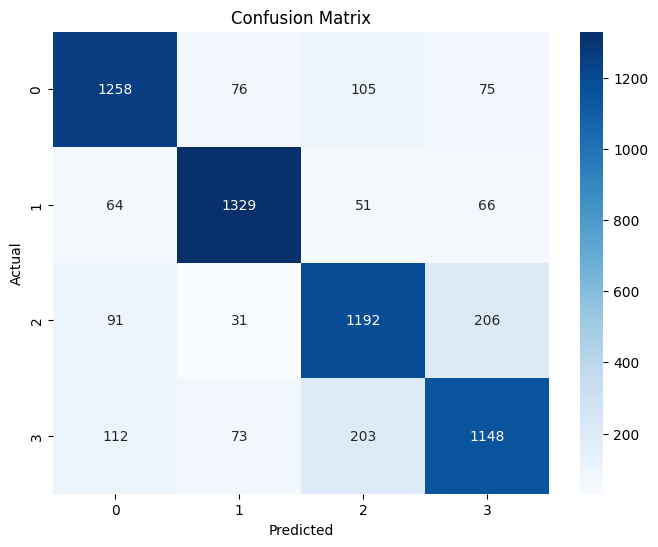

Epoch 9/30 - Avg Loss: 0.4704


Epoch 10/30: 100%|██████████| 211/211 [00:05<00:00, 36.35it/s]


🔍 Train Evaluation:
Accuracy: 0.8492 | F1: 0.8489 | Precision: 0.8491 | Recall: 0.8492

Confusion Matrix:
[[22609  1418  1542  1434]
 [  638 25231   304   843]
 [ 1110   602 22200  3014]
 [ 1414   984  2978 21679]]


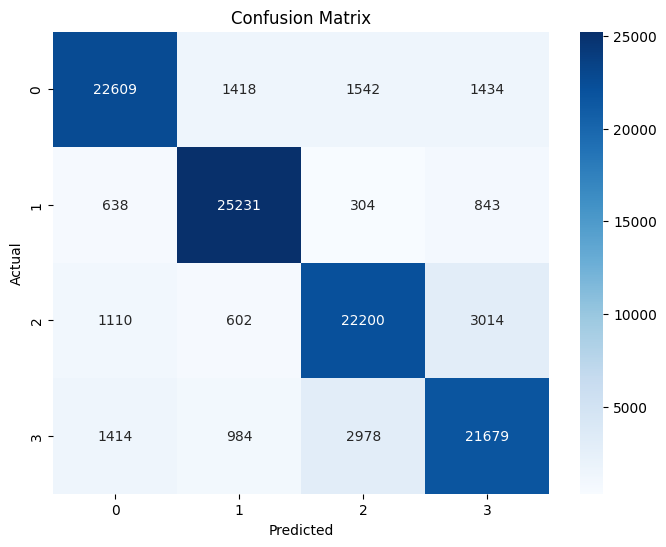

🧪 Test Evaluation:
Accuracy: 0.8140 | F1: 0.8139 | Precision: 0.8138 | Recall: 0.8142

Confusion Matrix:
[[1231   99   99   85]
 [  60 1357   23   70]
 [  92   41 1185  202]
 [  86   75  199 1176]]


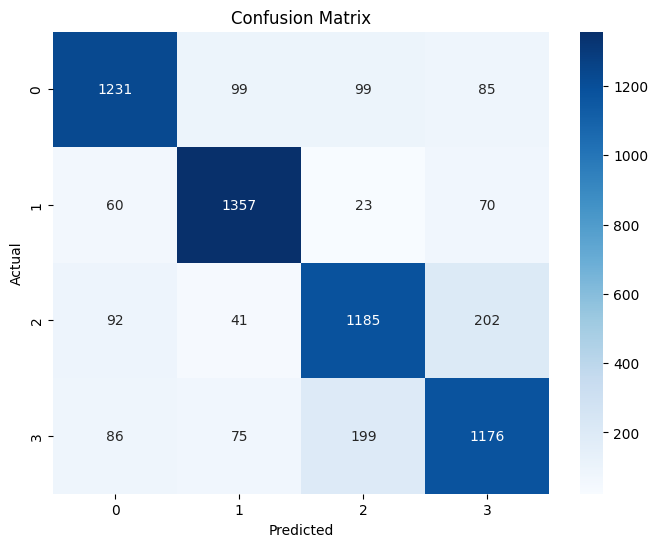

Epoch 10/30 - Avg Loss: 0.4534


Epoch 11/30: 100%|██████████| 211/211 [00:05<00:00, 36.42it/s]


🔍 Train Evaluation:
Accuracy: 0.8535 | F1: 0.8531 | Precision: 0.8550 | Recall: 0.8535

Confusion Matrix:
[[22763  1444  1251  1545]
 [  544 25541   188   743]
 [ 1206   645 21029  4046]
 [ 1296  1028  1881 22850]]


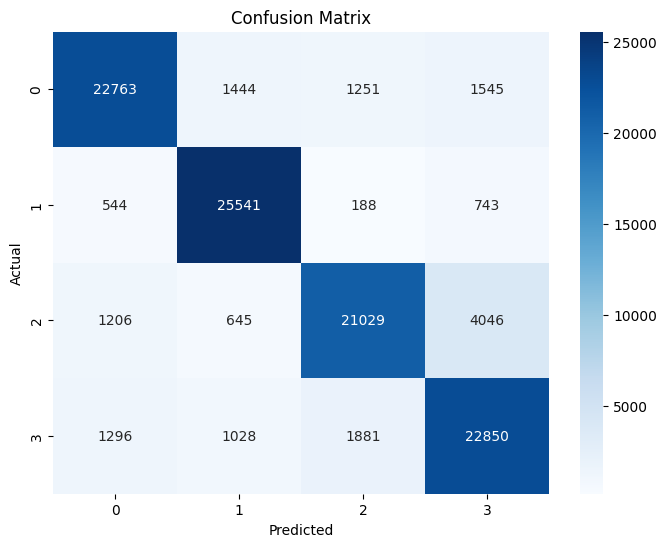

🧪 Test Evaluation:
Accuracy: 0.8110 | F1: 0.8108 | Precision: 0.8125 | Recall: 0.8112

Confusion Matrix:
[[1222  105   89   98]
 [  48 1372   22   68]
 [  91   41 1117  271]
 [  91   82  143 1220]]


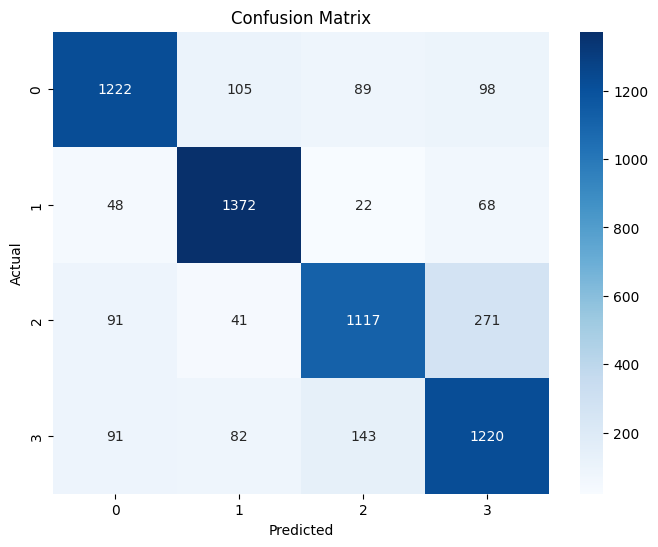

Epoch 11/30 - Avg Loss: 0.4400


Epoch 12/30: 100%|██████████| 211/211 [00:05<00:00, 38.57it/s]


🔍 Train Evaluation:
Accuracy: 0.8613 | F1: 0.8614 | Precision: 0.8622 | Recall: 0.8613

Confusion Matrix:
[[22657  1183  1787  1376]
 [  569 25210   448   789]
 [  833   372 22478  3243]
 [ 1180   713  2488 22674]]


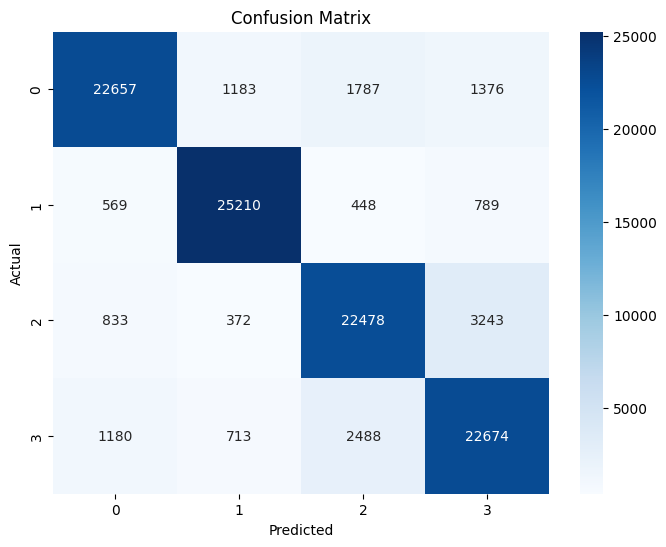

🧪 Test Evaluation:
Accuracy: 0.8153 | F1: 0.8158 | Precision: 0.8166 | Recall: 0.8155

Confusion Matrix:
[[1223   82  121   88]
 [  58 1339   43   70]
 [  71   33 1189  227]
 [  86   62  182 1206]]


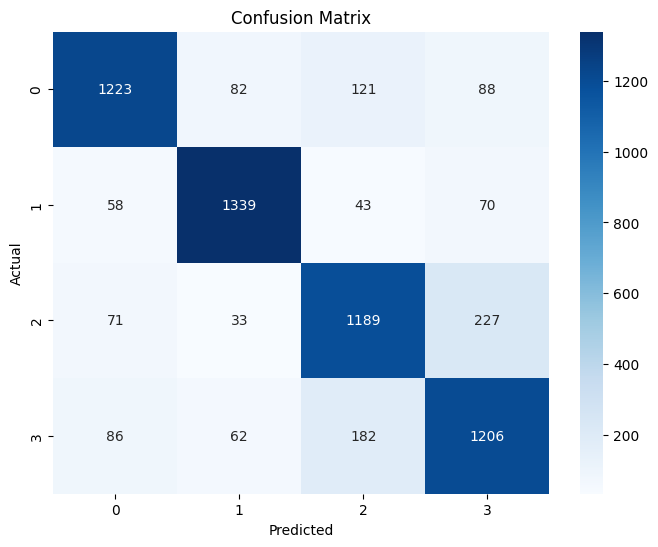

Epoch 12/30 - Avg Loss: 0.4218


Epoch 13/30: 100%|██████████| 211/211 [00:05<00:00, 41.27it/s]


🔍 Train Evaluation:
Accuracy: 0.8665 | F1: 0.8657 | Precision: 0.8664 | Recall: 0.8665

Confusion Matrix:
[[23390  1383  1106  1124]
 [  492 25923   152   449]
 [ 1277   721 21604  3324]
 [ 1452  1054  1883 22666]]


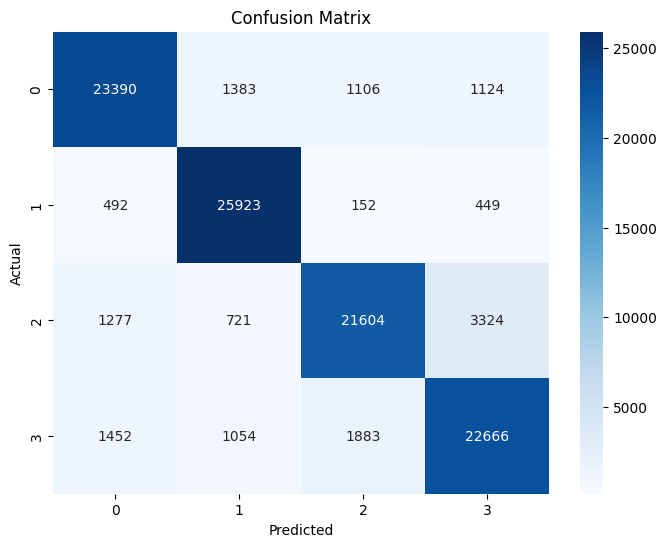

🧪 Test Evaluation:
Accuracy: 0.8133 | F1: 0.8126 | Precision: 0.8128 | Recall: 0.8136

Confusion Matrix:
[[1244  107   90   73]
 [  59 1381   15   55]
 [ 101   46 1139  234]
 [ 105   89  161 1181]]


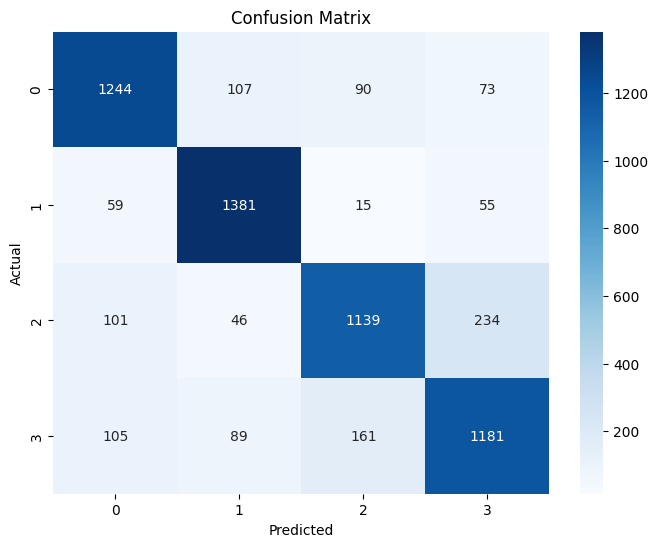

Epoch 13/30 - Avg Loss: 0.4056


Epoch 14/30: 100%|██████████| 211/211 [00:05<00:00, 36.41it/s]


🔍 Train Evaluation:
Accuracy: 0.8706 | F1: 0.8703 | Precision: 0.8715 | Recall: 0.8706

Confusion Matrix:
[[22548  1456  1720  1279]
 [  400 25864   287   465]
 [  663   560 22884  2819]
 [  902   828  2596 22729]]


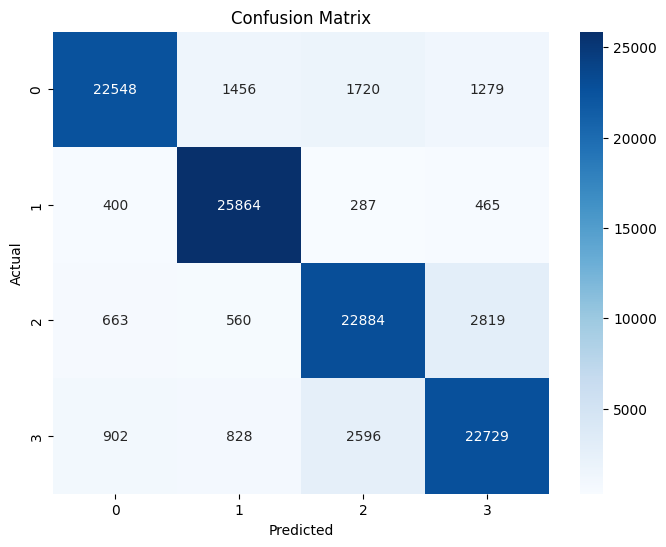

🧪 Test Evaluation:
Accuracy: 0.8166 | F1: 0.8164 | Precision: 0.8172 | Recall: 0.8169

Confusion Matrix:
[[1205  108  117   84]
 [  43 1384   29   54]
 [  71   42 1196  211]
 [  73   84  199 1180]]


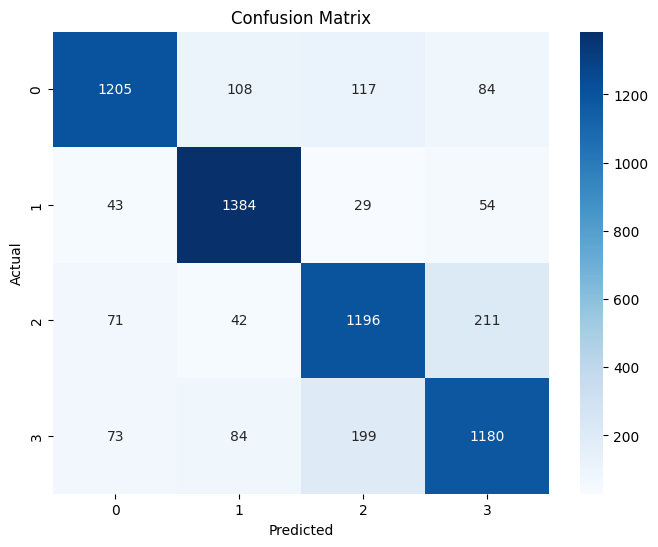

Epoch 14/30 - Avg Loss: 0.3931


Epoch 15/30: 100%|██████████| 211/211 [00:05<00:00, 36.01it/s]


🔍 Train Evaluation:
Accuracy: 0.8771 | F1: 0.8764 | Precision: 0.8766 | Recall: 0.8771

Confusion Matrix:
[[23678  1339  1150   836]
 [  426 26095   160   335]
 [  997   633 22608  2688]
 [ 1469  1060  2175 22351]]


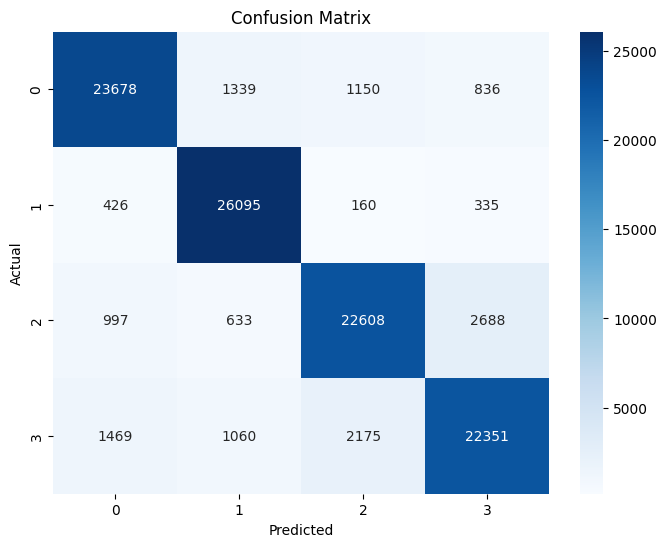

🧪 Test Evaluation:
Accuracy: 0.8161 | F1: 0.8153 | Precision: 0.8151 | Recall: 0.8165

Confusion Matrix:
[[1248  105   98   63]
 [  56 1387   23   44]
 [  95   45 1179  201]
 [ 101   91  196 1148]]


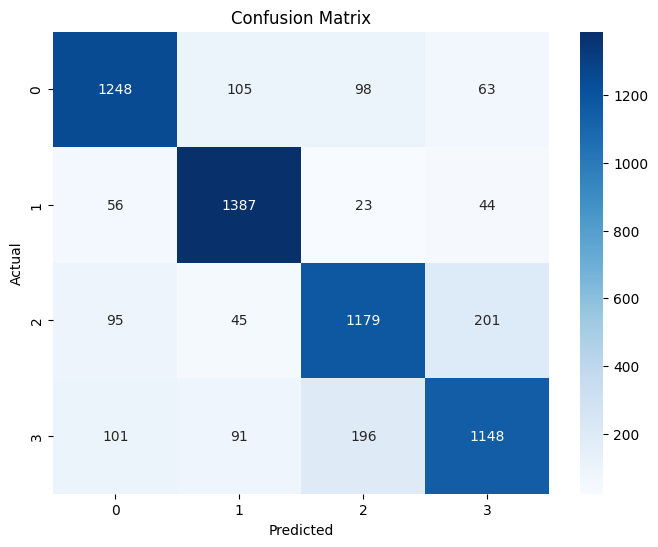

Epoch 15/30 - Avg Loss: 0.3758


Epoch 16/30: 100%|██████████| 211/211 [00:05<00:00, 41.25it/s]


🔍 Train Evaluation:
Accuracy: 0.8812 | F1: 0.8809 | Precision: 0.8837 | Recall: 0.8811

Confusion Matrix:
[[23229  1250   934  1590]
 [  335 25985   110   586]
 [ 1095   455 21734  3642]
 [  769   608  1461 24217]]


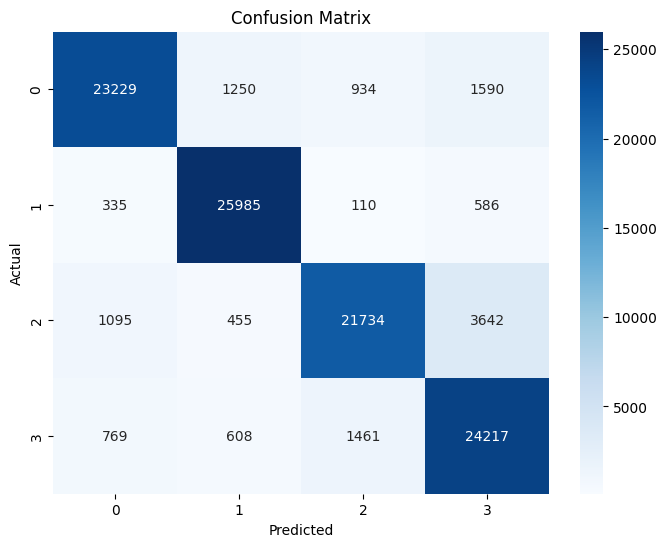

🧪 Test Evaluation:
Accuracy: 0.8146 | F1: 0.8145 | Precision: 0.8174 | Recall: 0.8148

Confusion Matrix:
[[1214  102   85  113]
 [  45 1373   21   71]
 [  99   43 1105  273]
 [  69   69  137 1261]]


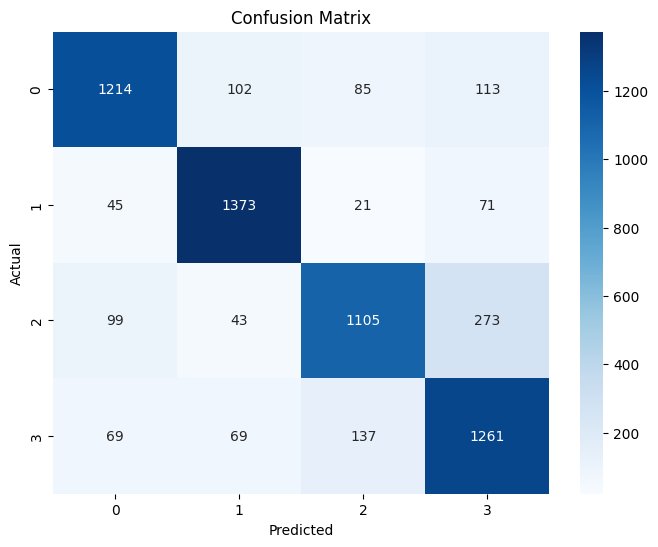

Epoch 16/30 - Avg Loss: 0.3622


Epoch 17/30: 100%|██████████| 211/211 [00:05<00:00, 41.10it/s]


🔍 Train Evaluation:
Accuracy: 0.8840 | F1: 0.8843 | Precision: 0.8894 | Recall: 0.8839

Confusion Matrix:
[[23582   846   913  1662]
 [  513 25501   174   828]
 [  875   266 21503  4282]
 [  709   367  1095 24884]]


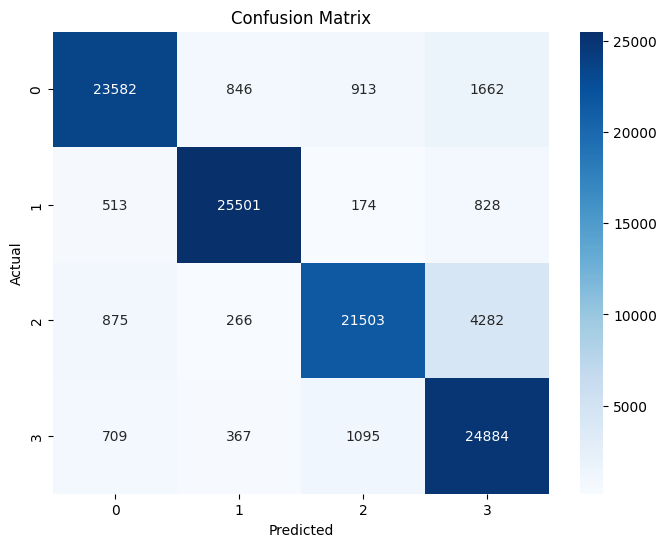

🧪 Test Evaluation:
Accuracy: 0.8132 | F1: 0.8136 | Precision: 0.8186 | Recall: 0.8132

Confusion Matrix:
[[1236   76   88  114]
 [  61 1343   26   80]
 [  84   34 1078  324]
 [  64   54  131 1287]]


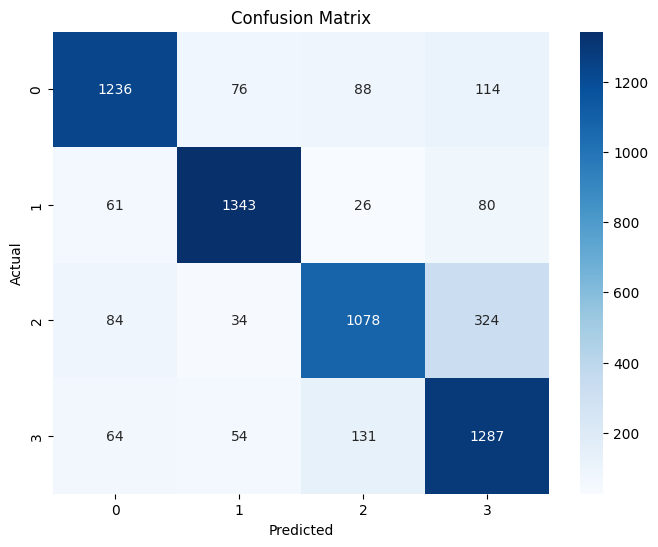

Epoch 17/30 - Avg Loss: 0.3467


Epoch 18/30: 100%|██████████| 211/211 [00:05<00:00, 40.53it/s]


🔍 Train Evaluation:
Accuracy: 0.8948 | F1: 0.8944 | Precision: 0.8946 | Recall: 0.8948

Confusion Matrix:
[[23816  1162  1082   943]
 [  305 26223   221   267]
 [  858   364 23468  2236]
 [  886   728  2310 23131]]


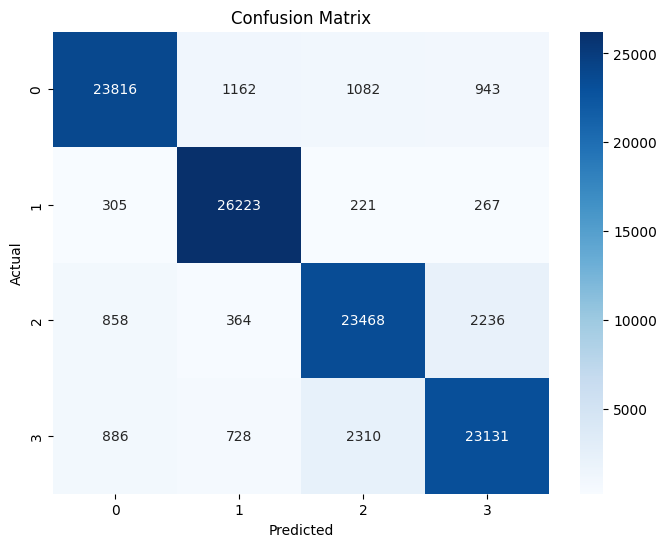

🧪 Test Evaluation:
Accuracy: 0.8178 | F1: 0.8175 | Precision: 0.8174 | Recall: 0.8181

Confusion Matrix:
[[1236   99   96   83]
 [  57 1371   35   47]
 [  88   40 1203  189]
 [  81   84  209 1162]]


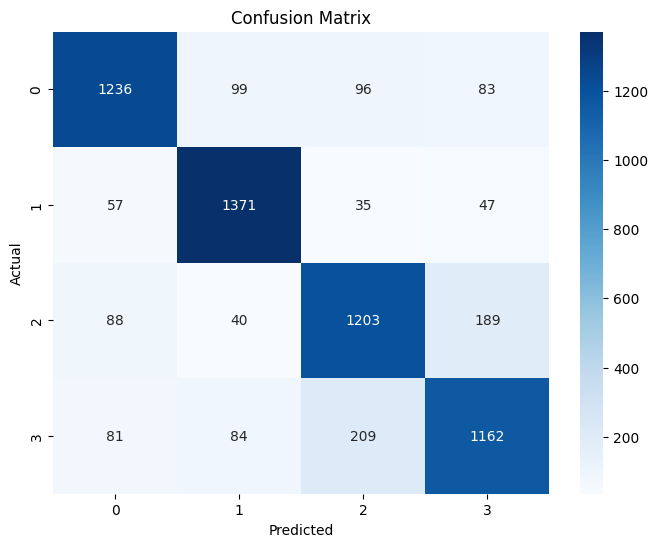

Epoch 18/30 - Avg Loss: 0.3305


Epoch 19/30: 100%|██████████| 211/211 [00:05<00:00, 35.72it/s]


🔍 Train Evaluation:
Accuracy: 0.8946 | F1: 0.8941 | Precision: 0.8941 | Recall: 0.8946

Confusion Matrix:
[[24540   894   943   626]
 [  676 25948   150   242]
 [  995   360 23126  2445]
 [ 1502   715  1839 22999]]


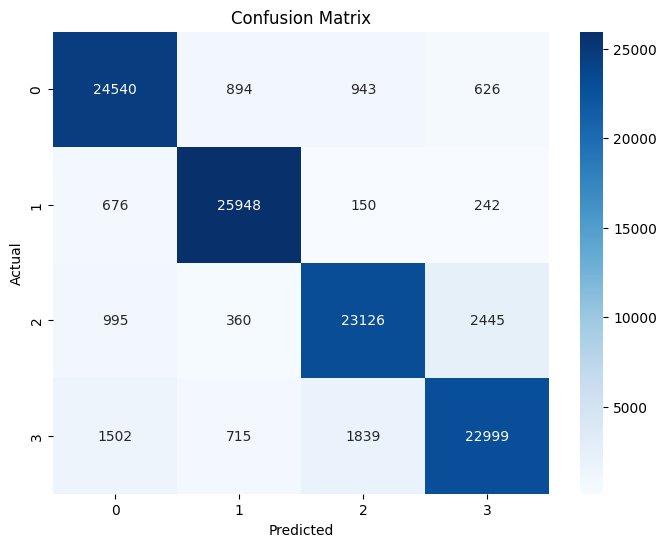

🧪 Test Evaluation:
Accuracy: 0.8135 | F1: 0.8129 | Precision: 0.8128 | Recall: 0.8138

Confusion Matrix:
[[1288   90   85   51]
 [  91 1353   23   43]
 [ 105   38 1161  216]
 [ 124   79  189 1144]]


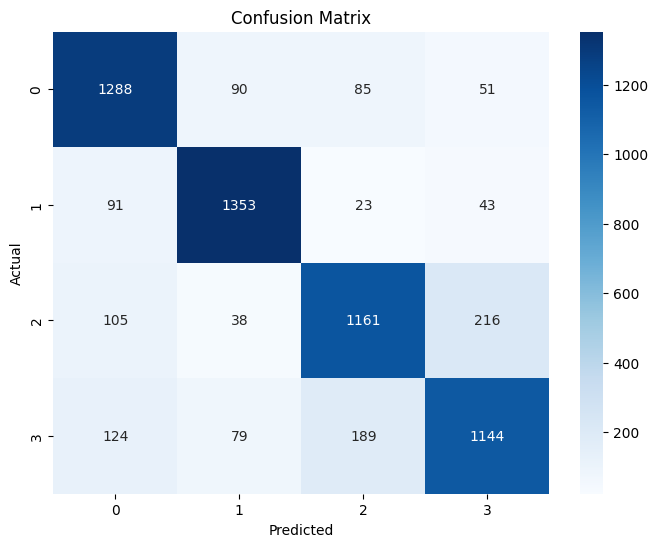

Epoch 19/30 - Avg Loss: 0.3148


Epoch 20/30: 100%|██████████| 211/211 [00:05<00:00, 35.17it/s]


🔍 Train Evaluation:
Accuracy: 0.9012 | F1: 0.9012 | Precision: 0.9047 | Recall: 0.9011

Confusion Matrix:
[[23787   985   944  1287]
 [  275 26187   114   440]
 [  557   290 22293  3786]
 [  587   473   935 25060]]


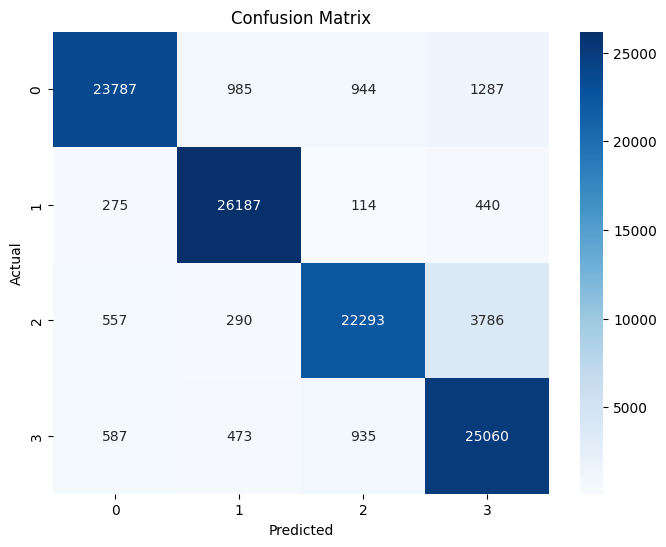

🧪 Test Evaluation:
Accuracy: 0.8145 | F1: 0.8145 | Precision: 0.8176 | Recall: 0.8146

Confusion Matrix:
[[1227   94   95   98]
 [  55 1368   23   64]
 [  80   38 1091  311]
 [  67   61  142 1266]]


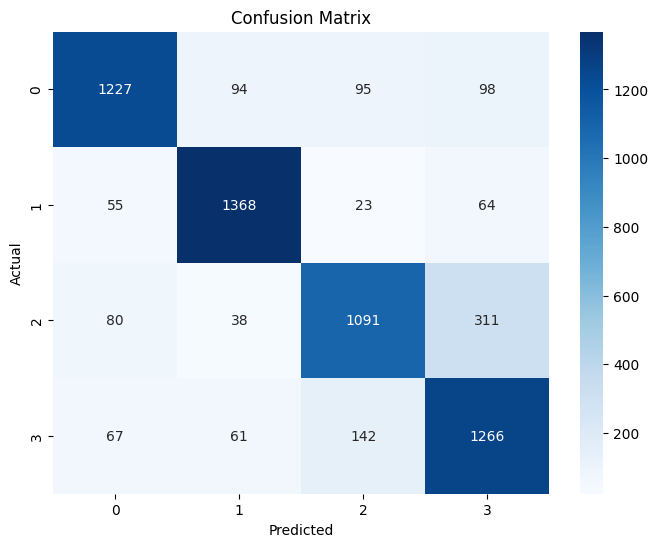

Epoch 20/30 - Avg Loss: 0.3018


Epoch 21/30: 100%|██████████| 211/211 [00:05<00:00, 41.07it/s]


🔍 Train Evaluation:
Accuracy: 0.9128 | F1: 0.9127 | Precision: 0.9132 | Recall: 0.9128

Confusion Matrix:
[[24549   800   764   890]
 [  349 26207   115   345]
 [  944   245 23240  2497]
 [  750   385  1330 24590]]


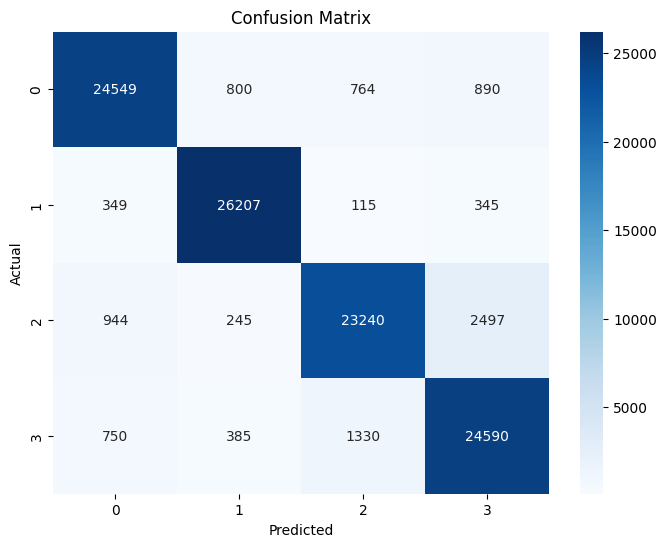

🧪 Test Evaluation:
Accuracy: 0.8164 | F1: 0.8164 | Precision: 0.8166 | Recall: 0.8167

Confusion Matrix:
[[1261   82   84   87]
 [  66 1350   34   60]
 [ 110   38 1145  227]
 [  87   64  177 1208]]


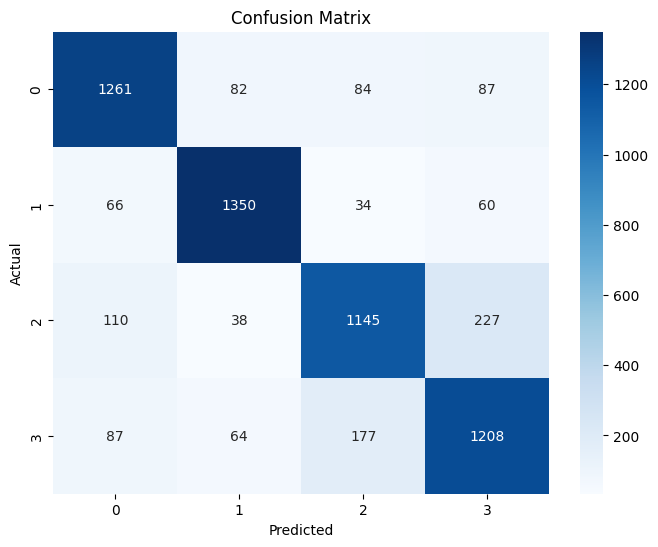

Epoch 21/30 - Avg Loss: 0.2872


Epoch 22/30: 100%|██████████| 211/211 [00:05<00:00, 40.86it/s]


🔍 Train Evaluation:
Accuracy: 0.9175 | F1: 0.9173 | Precision: 0.9180 | Recall: 0.9175

Confusion Matrix:
[[24580   851   723   849]
 [  271 26359   112   274]
 [  825   256 23326  2519]
 [  694   327  1207 24827]]


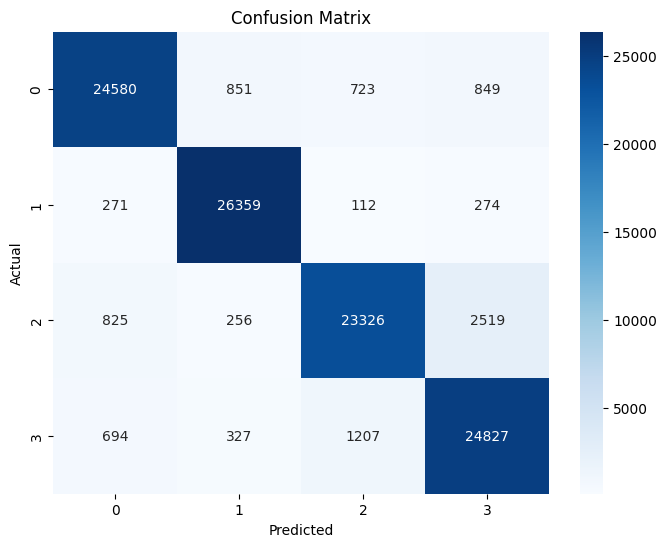

🧪 Test Evaluation:
Accuracy: 0.8166 | F1: 0.8164 | Precision: 0.8172 | Recall: 0.8168

Confusion Matrix:
[[1251   89   84   90]
 [  56 1367   26   61]
 [ 105   40 1120  255]
 [  80   63  166 1227]]


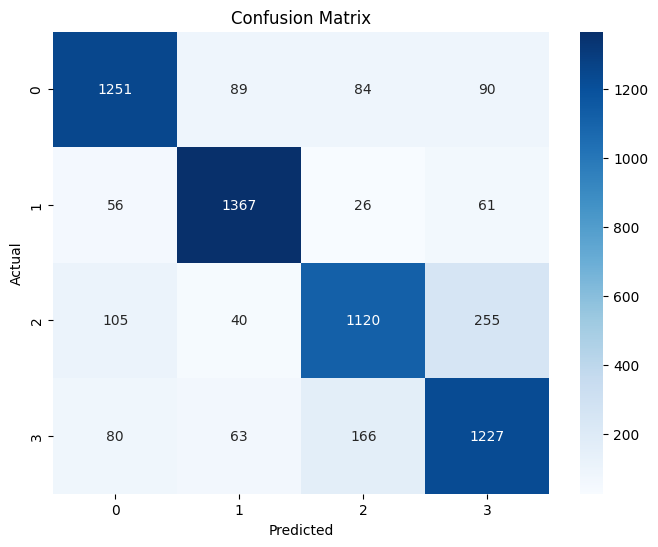

Epoch 22/30 - Avg Loss: 0.2724


Epoch 23/30: 100%|██████████| 211/211 [00:05<00:00, 40.02it/s]


🔍 Train Evaluation:
Accuracy: 0.9202 | F1: 0.9201 | Precision: 0.9211 | Recall: 0.9202

Confusion Matrix:
[[25034   597   621   751]
 [  495 26121    55   345]
 [  848   293 23271  2514]
 [  852   267   978 24958]]


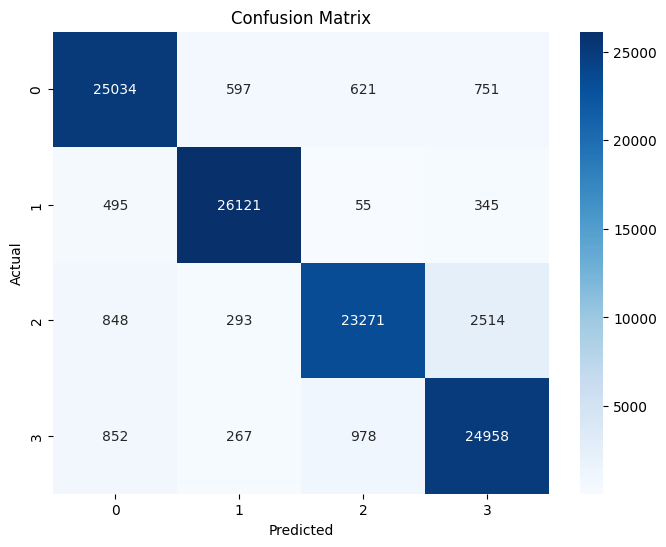

🧪 Test Evaluation:
Accuracy: 0.8197 | F1: 0.8197 | Precision: 0.8206 | Recall: 0.8199

Confusion Matrix:
[[1278   72   84   80]
 [  82 1345   24   59]
 [ 105   38 1134  243]
 [ 102   57  150 1227]]


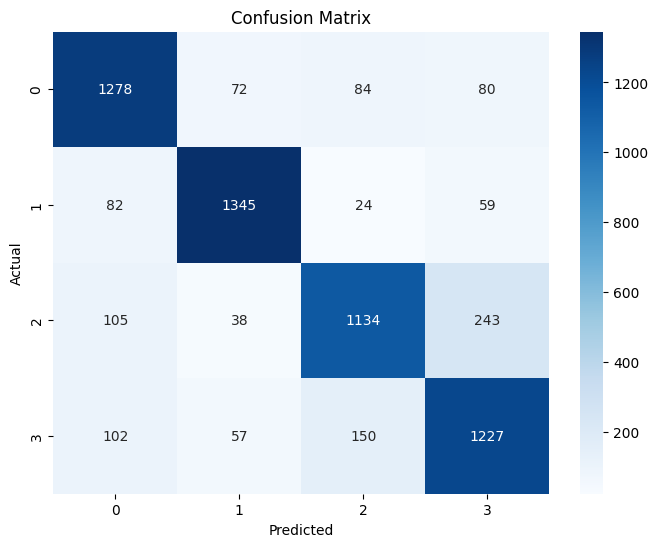

Epoch 23/30 - Avg Loss: 0.2554


Epoch 24/30: 100%|██████████| 211/211 [00:05<00:00, 35.89it/s]


🔍 Train Evaluation:
Accuracy: 0.9274 | F1: 0.9276 | Precision: 0.9289 | Recall: 0.9274

Confusion Matrix:
[[24922   562   590   929]
 [  349 26076   131   460]
 [  650   107 23713  2456]
 [  485   168   950 25452]]


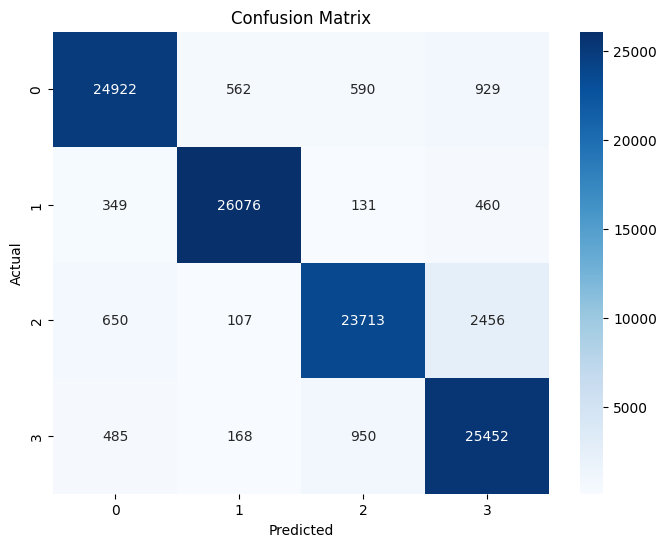

🧪 Test Evaluation:
Accuracy: 0.8123 | F1: 0.8128 | Precision: 0.8145 | Recall: 0.8125

Confusion Matrix:
[[1252   74   83  105]
 [  73 1325   36   76]
 [ 111   28 1125  256]
 [  77   52  170 1237]]


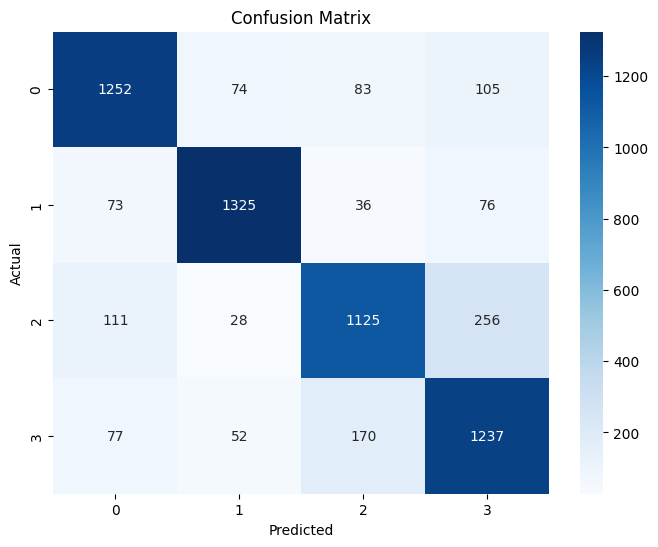

Epoch 24/30 - Avg Loss: 0.2423


Epoch 25/30: 100%|██████████| 211/211 [00:05<00:00, 35.24it/s]


🔍 Train Evaluation:
Accuracy: 0.9347 | F1: 0.9347 | Precision: 0.9351 | Recall: 0.9347

Confusion Matrix:
[[25251   560   623   569]
 [  377 26286    80   273]
 [  563   121 24214  2028]
 [  635   203  1015 25202]]


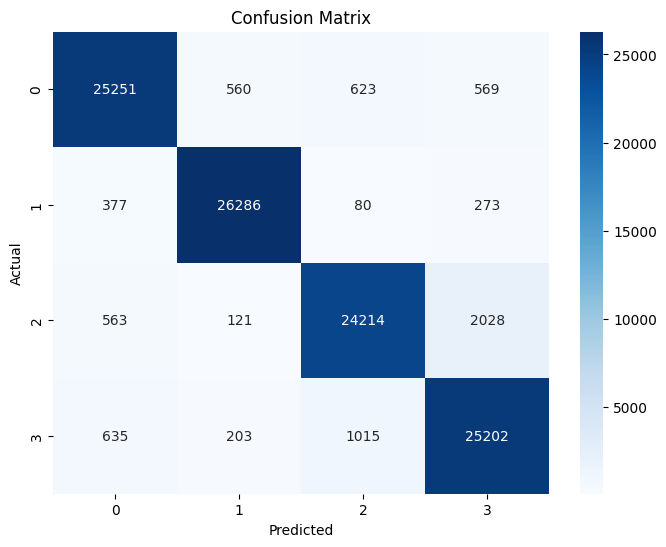

🧪 Test Evaluation:
Accuracy: 0.8150 | F1: 0.8151 | Precision: 0.8155 | Recall: 0.8152

Confusion Matrix:
[[1256   73   94   91]
 [  76 1348   25   61]
 [ 106   32 1144  238]
 [  92   59  178 1207]]


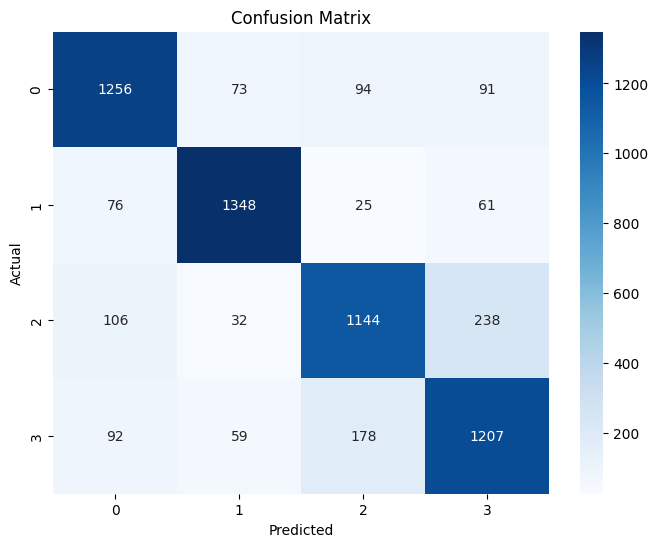

Epoch 25/30 - Avg Loss: 0.2279


Epoch 26/30: 100%|██████████| 211/211 [00:05<00:00, 40.99it/s]


🔍 Train Evaluation:
Accuracy: 0.9379 | F1: 0.9379 | Precision: 0.9381 | Recall: 0.9379

Confusion Matrix:
[[25057   557   812   577]
 [  293 26407   109   207]
 [  385   119 24714  1708]
 [  539   214  1185 25117]]


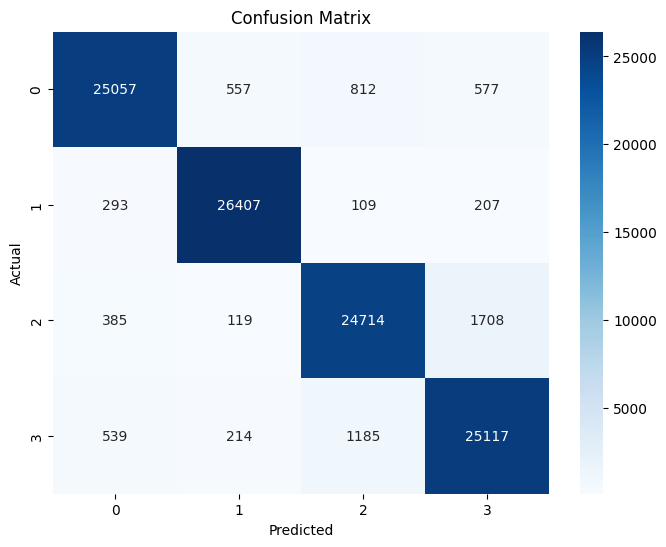

🧪 Test Evaluation:
Accuracy: 0.8084 | F1: 0.8088 | Precision: 0.8092 | Recall: 0.8086

Confusion Matrix:
[[1209   83  123   99]
 [  70 1342   38   60]
 [  99   31 1175  215]
 [  89   51  207 1189]]


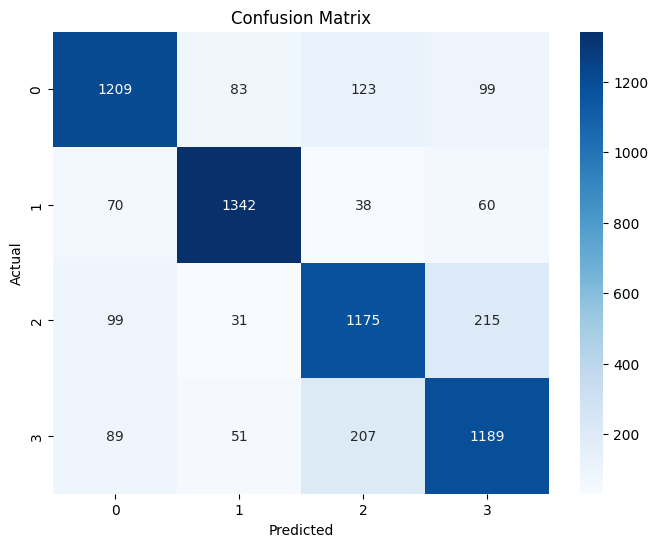

Epoch 26/30 - Avg Loss: 0.2136


Epoch 27/30: 100%|██████████| 211/211 [00:05<00:00, 40.57it/s]


🔍 Train Evaluation:
Accuracy: 0.9364 | F1: 0.9364 | Precision: 0.9367 | Recall: 0.9364

Confusion Matrix:
[[25447   403   744   409]
 [  588 26023   160   245]
 [  416    79 25145  1286]
 [  714   136  1690 24515]]


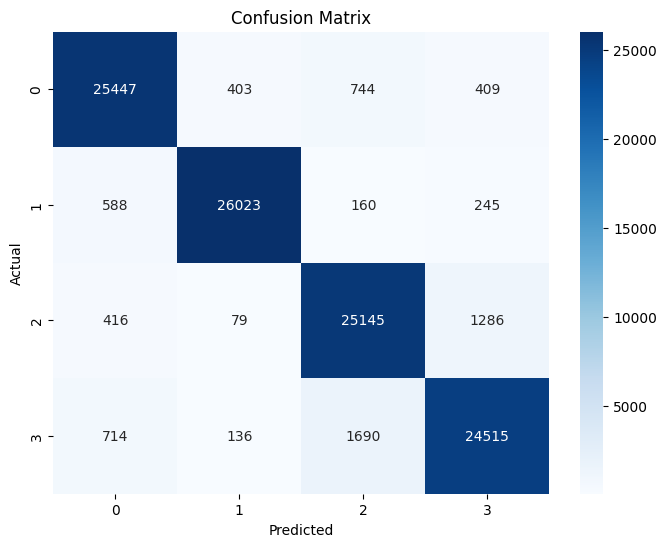

🧪 Test Evaluation:
Accuracy: 0.8110 | F1: 0.8115 | Precision: 0.8126 | Recall: 0.8113

Confusion Matrix:
[[1264   71  104   75]
 [ 102 1310   42   56]
 [  99   33 1210  178]
 [ 107   38  244 1147]]


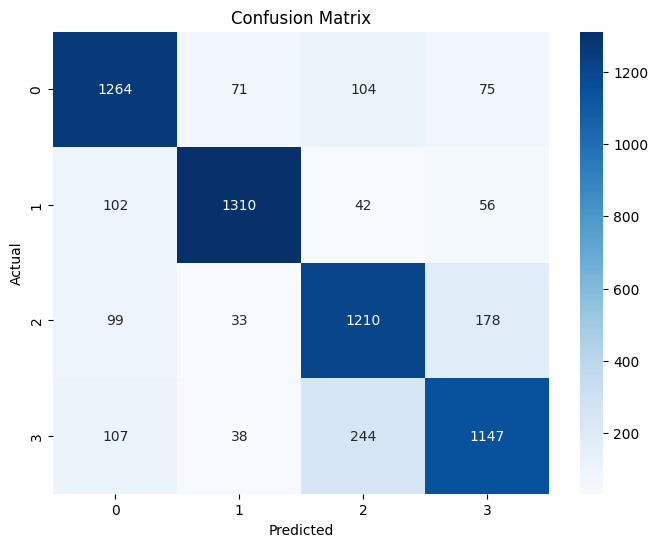

Epoch 27/30 - Avg Loss: 0.2002


Epoch 28/30: 100%|██████████| 211/211 [00:05<00:00, 39.75it/s]


🔍 Train Evaluation:
Accuracy: 0.9456 | F1: 0.9455 | Precision: 0.9455 | Recall: 0.9456

Confusion Matrix:
[[25605   493   567   338]
 [  253 26552    72   139]
 [  461   163 24823  1479]
 [  697   202  1011 25145]]


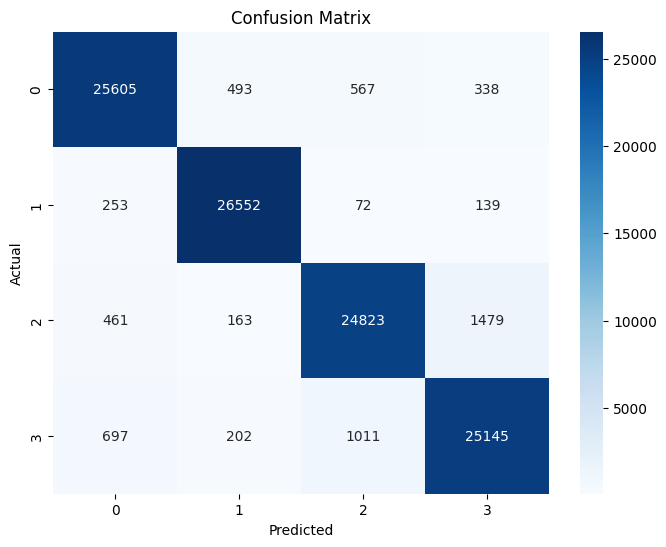

🧪 Test Evaluation:
Accuracy: 0.8104 | F1: 0.8104 | Precision: 0.8103 | Recall: 0.8106

Confusion Matrix:
[[1259   83   99   73]
 [  87 1331   39   53]
 [ 106   39 1167  208]
 [ 112   57  197 1170]]


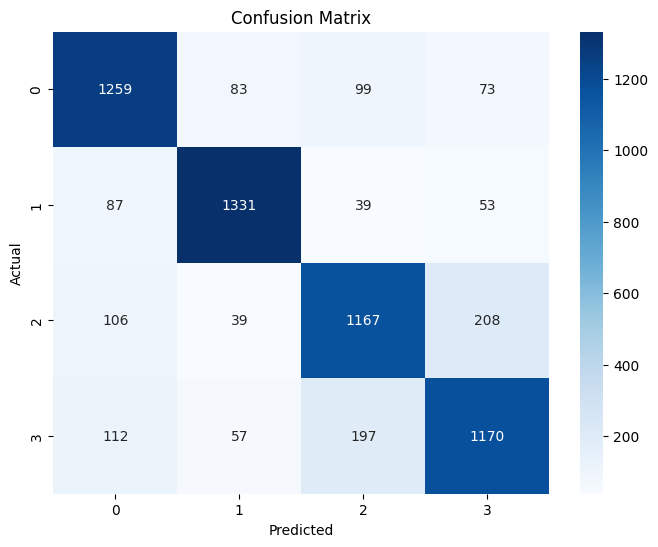

Epoch 28/30 - Avg Loss: 0.1899


Epoch 29/30: 100%|██████████| 211/211 [00:06<00:00, 34.34it/s]


🔍 Train Evaluation:
Accuracy: 0.9467 | F1: 0.9465 | Precision: 0.9467 | Recall: 0.9467

Confusion Matrix:
[[25439   619   657   288]
 [  149 26751    42    74]
 [  323   244 25182  1177]
 [  545   392  1250 24868]]


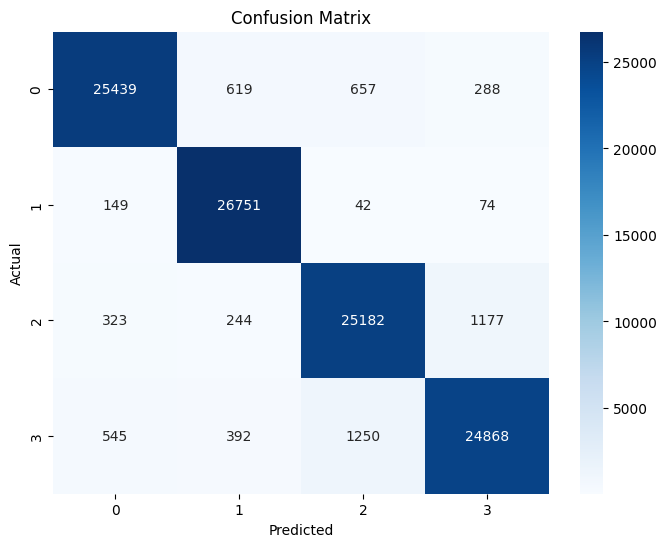

🧪 Test Evaluation:
Accuracy: 0.8058 | F1: 0.8052 | Precision: 0.8051 | Recall: 0.8061

Confusion Matrix:
[[1229   99  116   70]
 [  70 1368   30   42]
 [ 100   50 1179  191]
 [ 103   82  228 1123]]


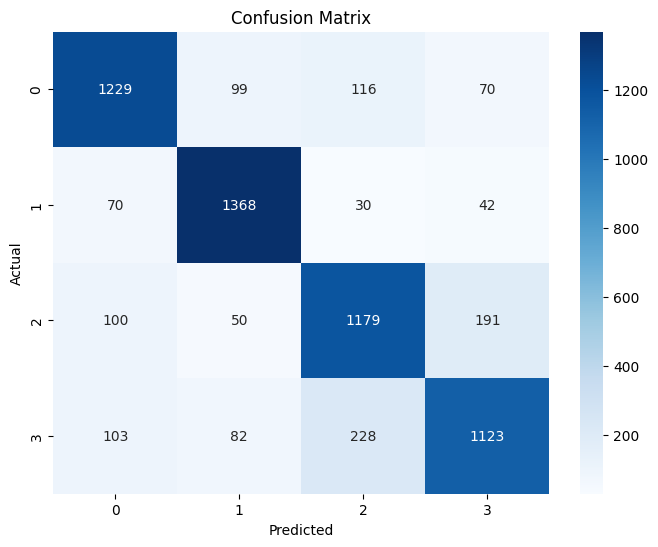

Epoch 29/30 - Avg Loss: 0.1803


Epoch 30/30: 100%|██████████| 211/211 [00:06<00:00, 34.37it/s]


🔍 Train Evaluation:
Accuracy: 0.9517 | F1: 0.9517 | Precision: 0.9519 | Recall: 0.9516

Confusion Matrix:
[[25840   394   366   403]
 [  289 26419    85   223]
 [  547    55 24783  1541]
 [  489    82   746 25738]]


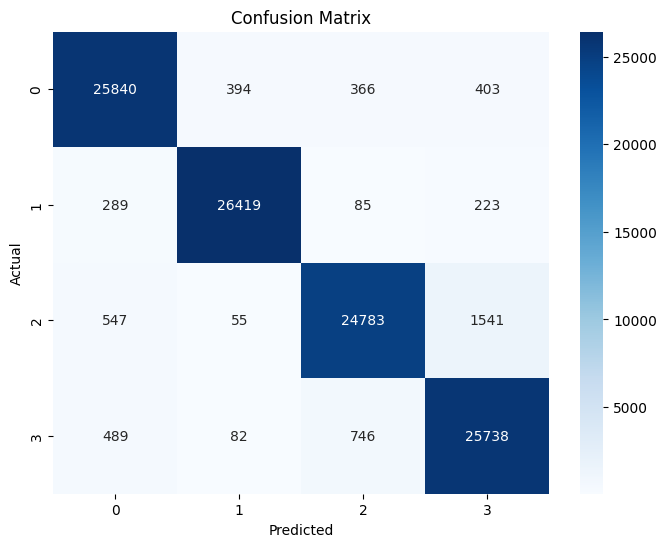

🧪 Test Evaluation:
Accuracy: 0.8087 | F1: 0.8090 | Precision: 0.8094 | Recall: 0.8089

Confusion Matrix:
[[1260   80   85   89]
 [  80 1328   38   64]
 [ 124   31 1136  229]
 [ 101   45  197 1193]]


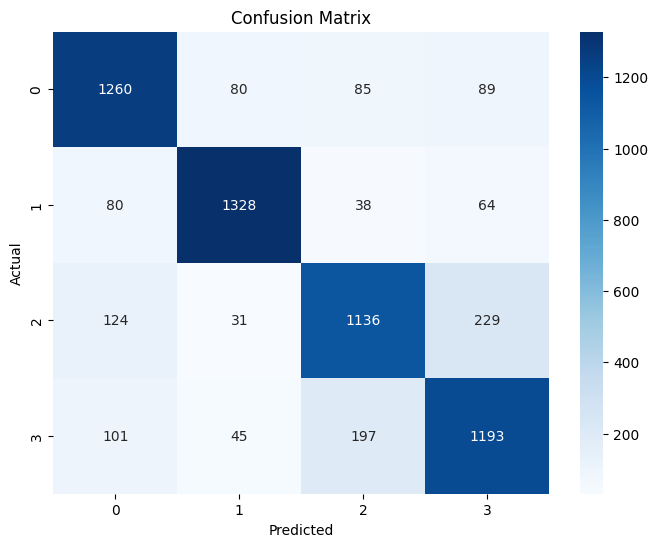

Epoch 30/30 - Avg Loss: 0.1710
✔ Saved classifier_svd.pt
Training classifier with CBOW embeddings...


Epoch 1/30: 100%|██████████| 211/211 [00:05<00:00, 35.40it/s]


🔍 Train Evaluation:
Accuracy: 0.6022 | F1: 0.6054 | Precision: 0.6314 | Recall: 0.6021

Confusion Matrix:
[[14593  3583  3209  5618]
 [ 1722 17278   981  7035]
 [ 2262  1332 14035  9297]
 [ 1574  2556  3791 19134]]


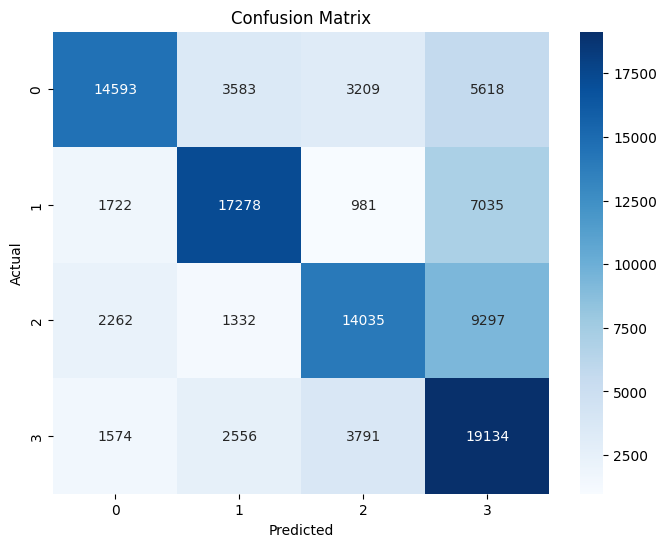

🧪 Test Evaluation:
Accuracy: 0.5987 | F1: 0.6023 | Precision: 0.6300 | Recall: 0.5984

Confusion Matrix:
[[ 814  195  189  316]
 [  91  958   62  399]
 [ 119   73  783  545]
 [  82  143  226 1085]]


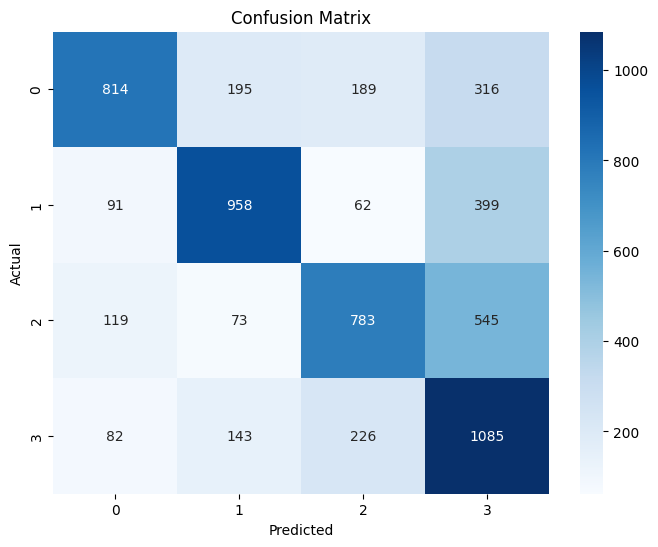

Epoch 1/30 - Avg Loss: 1.1586


Epoch 2/30: 100%|██████████| 211/211 [00:05<00:00, 39.98it/s]


🔍 Train Evaluation:
Accuracy: 0.6963 | F1: 0.6964 | Precision: 0.6968 | Recall: 0.6963

Confusion Matrix:
[[19273  2142  2805  2783]
 [ 1965 21312   840  2899]
 [ 3187  1173 17459  5107]
 [ 2588  2415  4894 17158]]


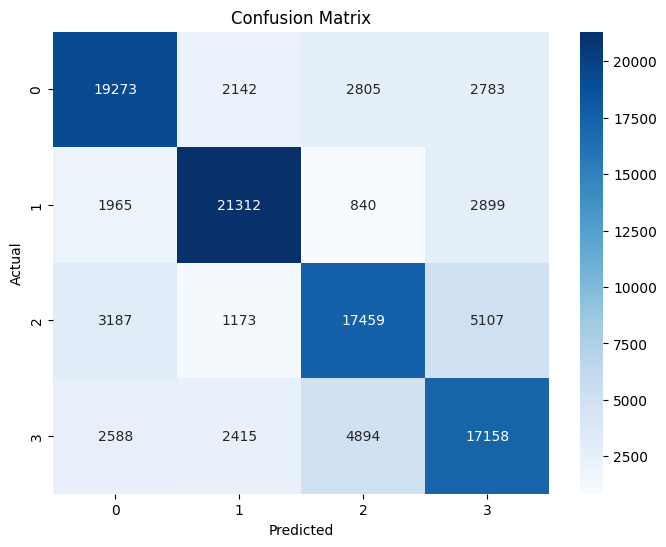

🧪 Test Evaluation:
Accuracy: 0.6980 | F1: 0.6985 | Precision: 0.6991 | Recall: 0.6983

Confusion Matrix:
[[1079  133  143  159]
 [ 117 1187   48  158]
 [ 183   59  982  296]
 [ 135  132  273  996]]


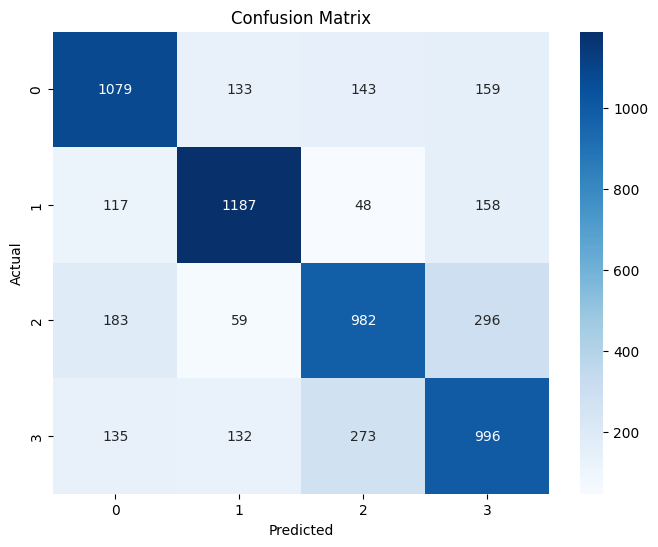

Epoch 2/30 - Avg Loss: 0.8718


Epoch 3/30: 100%|██████████| 211/211 [00:05<00:00, 39.70it/s]


🔍 Train Evaluation:
Accuracy: 0.7213 | F1: 0.7238 | Precision: 0.7465 | Recall: 0.7211

Confusion Matrix:
[[18366  1847  1811  4979]
 [ 1138 21554   415  3909]
 [ 2060   830 15982  8054]
 [ 1443  1264  2353 21995]]


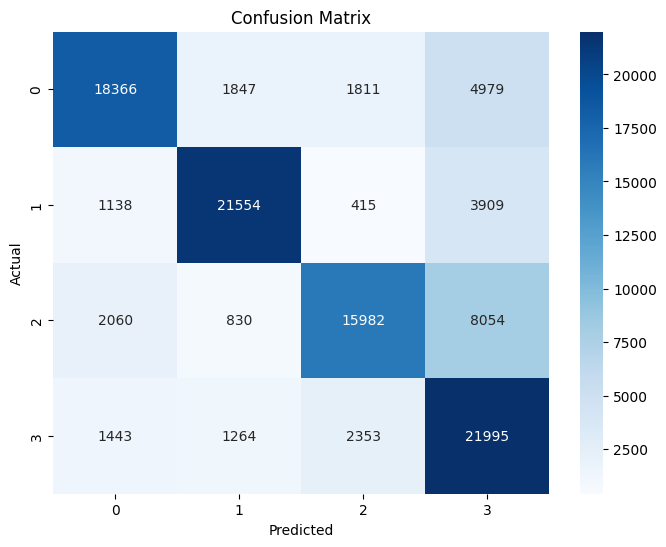

🧪 Test Evaluation:
Accuracy: 0.7127 | F1: 0.7146 | Precision: 0.7368 | Recall: 0.7125

Confusion Matrix:
[[1019  120  104  271]
 [  72 1175   35  228]
 [ 127   53  886  454]
 [  72   79  132 1253]]


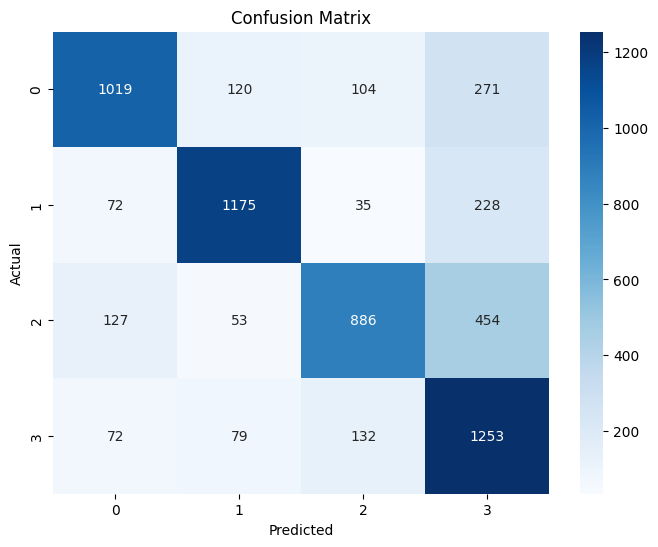

Epoch 3/30 - Avg Loss: 0.7568


Epoch 4/30: 100%|██████████| 211/211 [00:06<00:00, 33.36it/s]


🔍 Train Evaluation:
Accuracy: 0.7486 | F1: 0.7501 | Precision: 0.7606 | Recall: 0.7486

Confusion Matrix:
[[18046  2333  2882  3742]
 [  653 22616   809  2938]
 [ 1274   840 19335  5477]
 [ 1167  1353  3681 20854]]


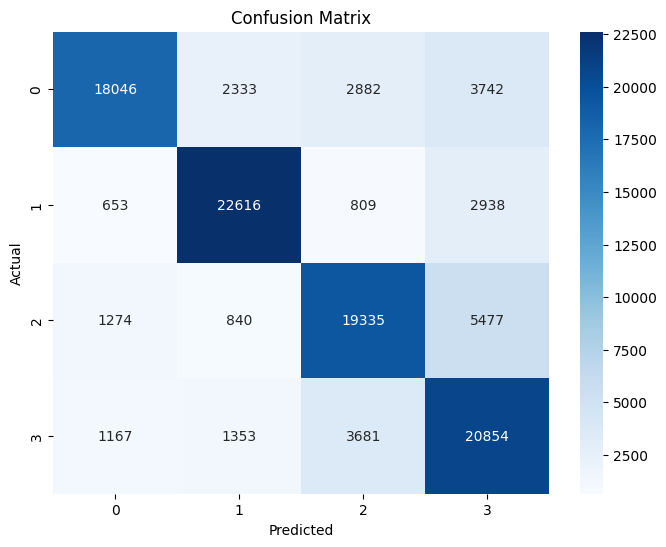

🧪 Test Evaluation:
Accuracy: 0.7441 | F1: 0.7457 | Precision: 0.7574 | Recall: 0.7440

Confusion Matrix:
[[ 994  132  173  215]
 [  39 1243   51  177]
 [  78   49 1094  299]
 [  52   81  210 1193]]


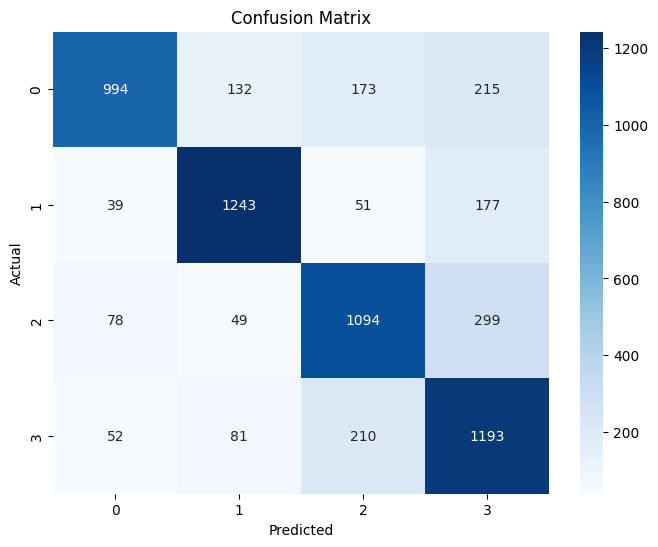

Epoch 4/30 - Avg Loss: 0.6943


Epoch 5/30: 100%|██████████| 211/211 [00:06<00:00, 31.94it/s]


🔍 Train Evaluation:
Accuracy: 0.7647 | F1: 0.7671 | Precision: 0.7820 | Recall: 0.7646

Confusion Matrix:
[[19012  1575  2169  4247]
 [  901 22584   605  2926]
 [ 1253   640 18585  6448]
 [ 1207   961  2483 22404]]


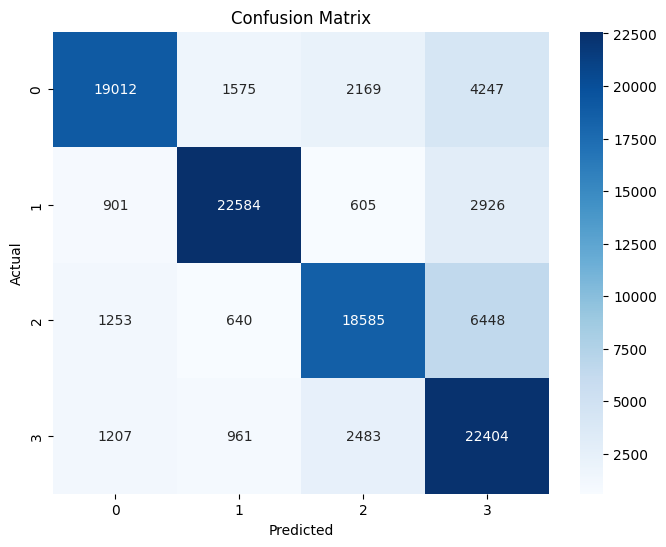

🧪 Test Evaluation:
Accuracy: 0.7581 | F1: 0.7601 | Precision: 0.7741 | Recall: 0.7579

Confusion Matrix:
[[1049  103  130  232]
 [  65 1250   32  163]
 [  75   45 1041  359]
 [  52   60  155 1269]]


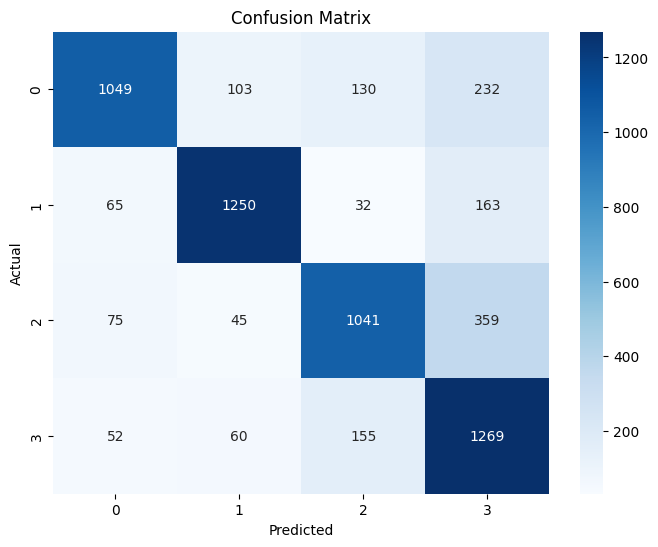

Epoch 5/30 - Avg Loss: 0.6486


Epoch 6/30: 100%|██████████| 211/211 [00:05<00:00, 35.30it/s]


🔍 Train Evaluation:
Accuracy: 0.7846 | F1: 0.7842 | Precision: 0.7875 | Recall: 0.7846

Confusion Matrix:
[[20129  1853  3205  1816]
 [  925 24042   998  1051]
 [ 1276   839 21576  3235]
 [ 1645  1587  4833 18990]]


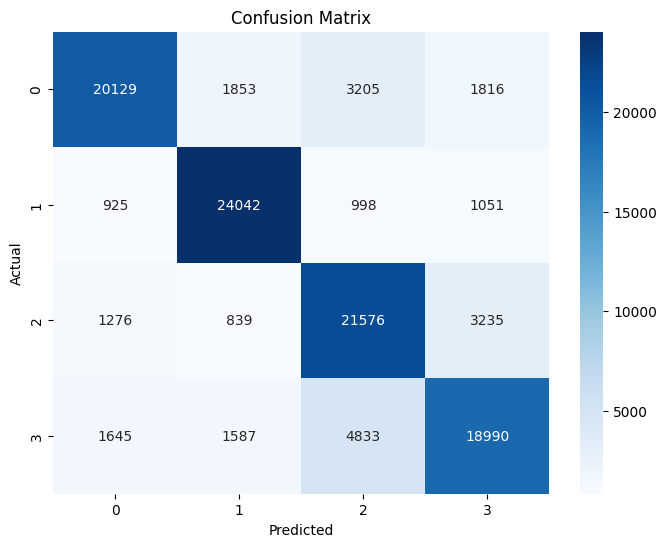

🧪 Test Evaluation:
Accuracy: 0.7730 | F1: 0.7730 | Precision: 0.7766 | Recall: 0.7734

Confusion Matrix:
[[1114  112  190   98]
 [  66 1323   62   59]
 [  79   50 1206  185]
 [  94   93  292 1057]]


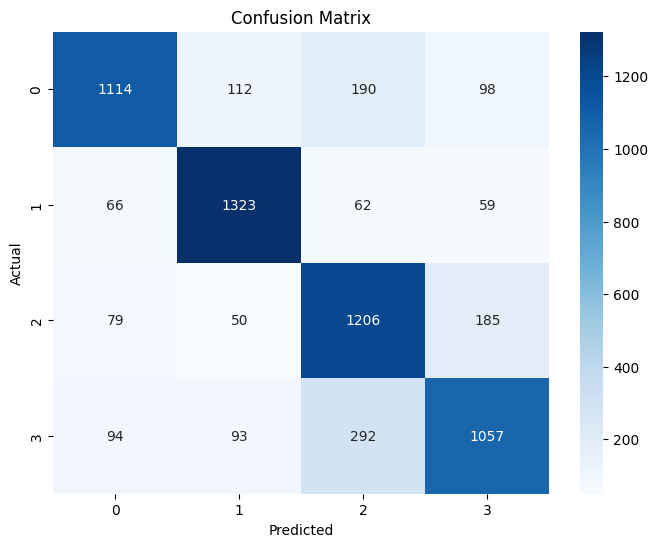

Epoch 6/30 - Avg Loss: 0.6181


Epoch 7/30: 100%|██████████| 211/211 [00:05<00:00, 37.16it/s]


🔍 Train Evaluation:
Accuracy: 0.7950 | F1: 0.7945 | Precision: 0.7977 | Recall: 0.7950

Confusion Matrix:
[[21591  1778  1427  2207]
 [ 1137 24065   364  1450]
 [ 2171   968 18870  4917]
 [ 2137  1309  2270 21339]]


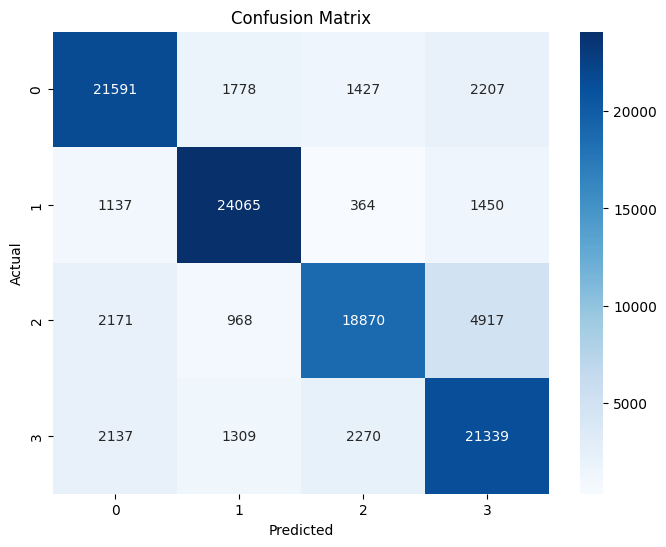

🧪 Test Evaluation:
Accuracy: 0.7855 | F1: 0.7850 | Precision: 0.7875 | Recall: 0.7857

Confusion Matrix:
[[1193  111   93  117]
 [  81 1326   24   79]
 [ 132   60 1047  281]
 [ 101   84  141 1210]]


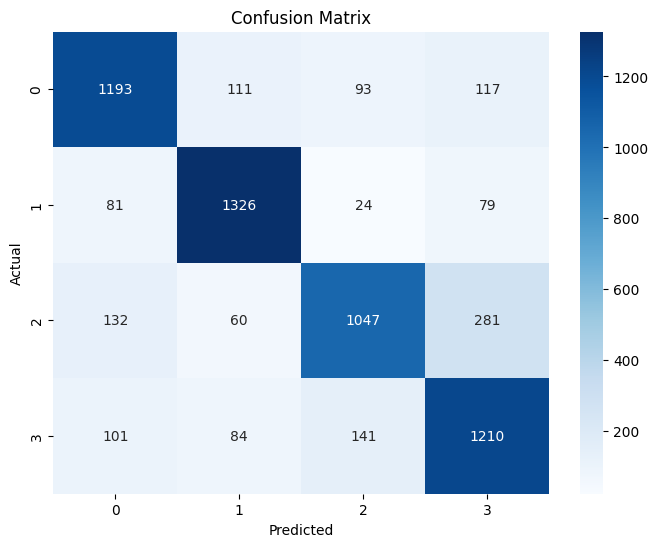

Epoch 7/30 - Avg Loss: 0.5865


Epoch 8/30: 100%|██████████| 211/211 [00:05<00:00, 39.17it/s]


🔍 Train Evaluation:
Accuracy: 0.8012 | F1: 0.8022 | Precision: 0.8089 | Recall: 0.8011

Confusion Matrix:
[[21875  1204  1341  2583]
 [ 1192 23261   416  2147]
 [ 2162   535 19008  5221]
 [ 1794   668  2204 22389]]


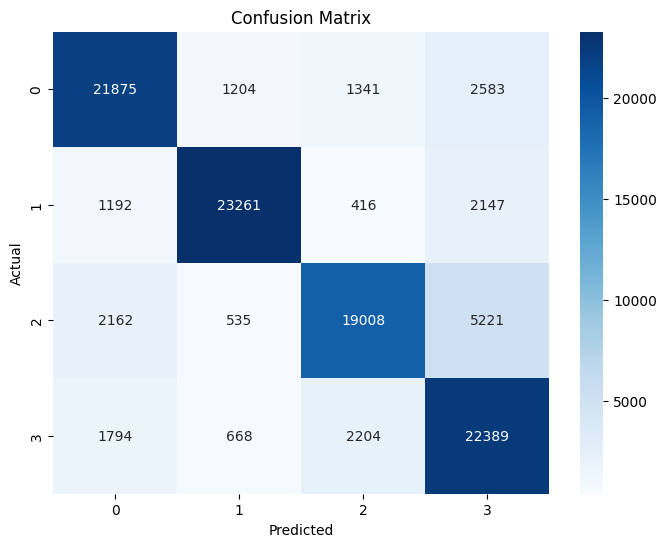

🧪 Test Evaluation:
Accuracy: 0.7836 | F1: 0.7843 | Precision: 0.7902 | Recall: 0.7836

Confusion Matrix:
[[1200   82   94  138]
 [  86 1271   28  125]
 [ 134   38 1043  305]
 [  99   46  141 1250]]


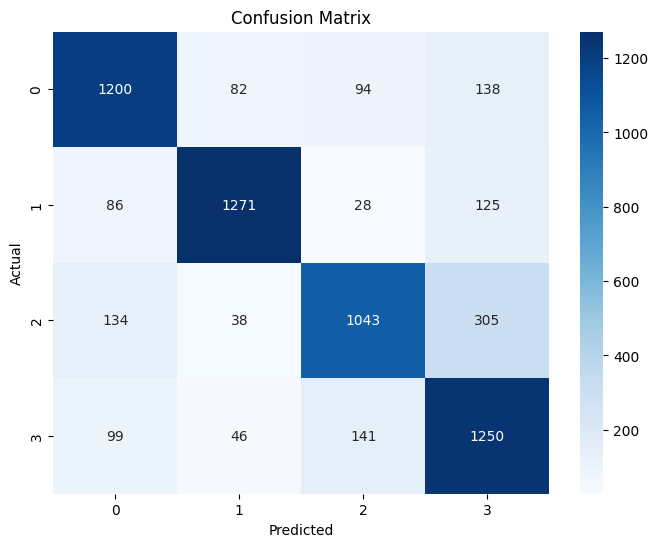

Epoch 8/30 - Avg Loss: 0.5693


Epoch 9/30: 100%|██████████| 211/211 [00:06<00:00, 34.42it/s]


🔍 Train Evaluation:
Accuracy: 0.8054 | F1: 0.8064 | Precision: 0.8154 | Recall: 0.8053

Confusion Matrix:
[[21544  1166  1451  2842]
 [ 1123 23547   480  1866]
 [ 1705   486 18837  5898]
 [ 1482   713  1804 23056]]


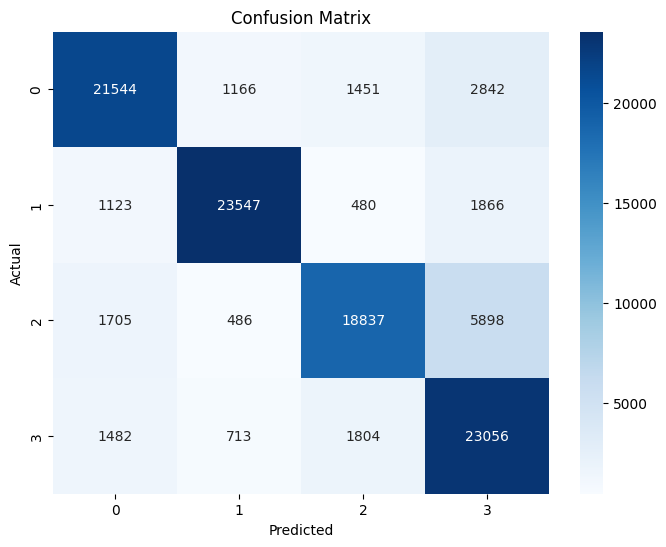

🧪 Test Evaluation:
Accuracy: 0.7844 | F1: 0.7853 | Precision: 0.7929 | Recall: 0.7844

Confusion Matrix:
[[1164   80   96  174]
 [  77 1296   31  106]
 [ 115   35 1036  334]
 [  80   51  132 1273]]


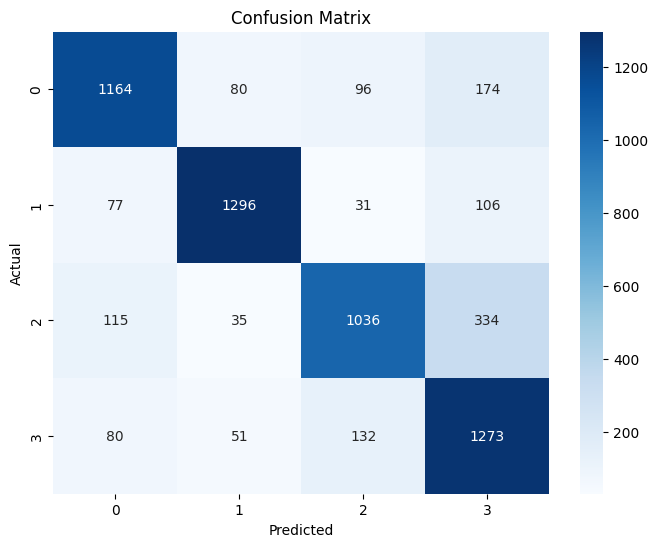

Epoch 9/30 - Avg Loss: 0.5499


Epoch 10/30: 100%|██████████| 211/211 [00:06<00:00, 31.49it/s]


🔍 Train Evaluation:
Accuracy: 0.8161 | F1: 0.8166 | Precision: 0.8181 | Recall: 0.8161

Confusion Matrix:
[[21913  1168  2151  1771]
 [ 1057 23829   825  1305]
 [ 1458   430 22012  3026]
 [ 1709   723  4242 20381]]


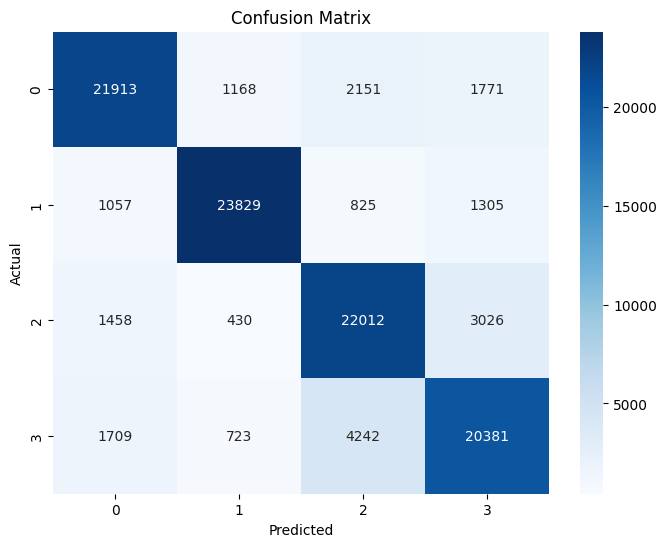

🧪 Test Evaluation:
Accuracy: 0.7967 | F1: 0.7976 | Precision: 0.7996 | Recall: 0.7970

Confusion Matrix:
[[1188   74  147  105]
 [  78 1306   47   79]
 [  88   36 1220  176]
 [  92   47  267 1130]]


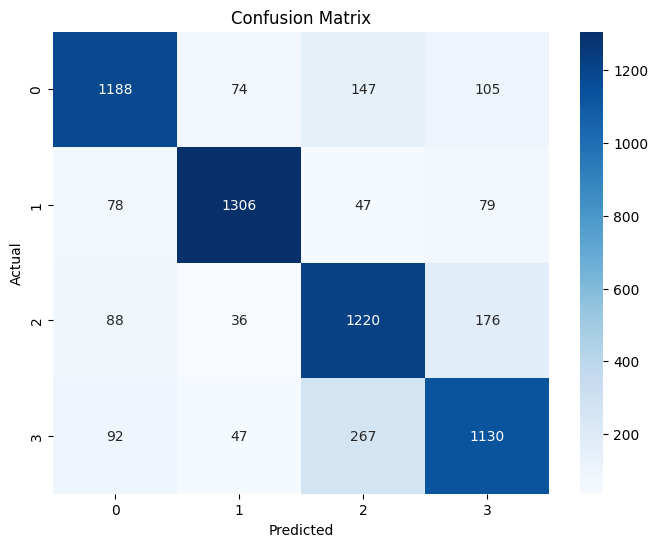

Epoch 10/30 - Avg Loss: 0.5287


Epoch 11/30: 100%|██████████| 211/211 [00:05<00:00, 38.39it/s]


🔍 Train Evaluation:
Accuracy: 0.8212 | F1: 0.8222 | Precision: 0.8259 | Recall: 0.8212

Confusion Matrix:
[[21436  1251  1954  2362]
 [  784 23930   670  1632]
 [ 1171   444 20927  4384]
 [ 1234   686  2739 22396]]


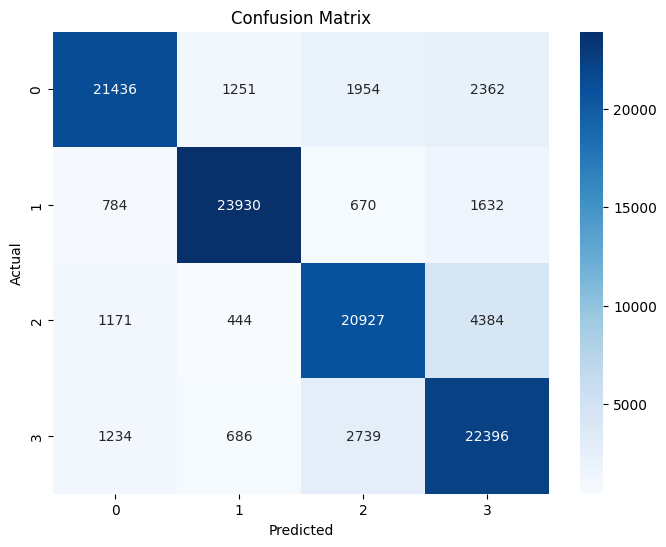

🧪 Test Evaluation:
Accuracy: 0.7982 | F1: 0.7994 | Precision: 0.8032 | Recall: 0.7982

Confusion Matrix:
[[1157   86  128  143]
 [  60 1307   38  105]
 [  75   36 1152  257]
 [  76   45  178 1237]]


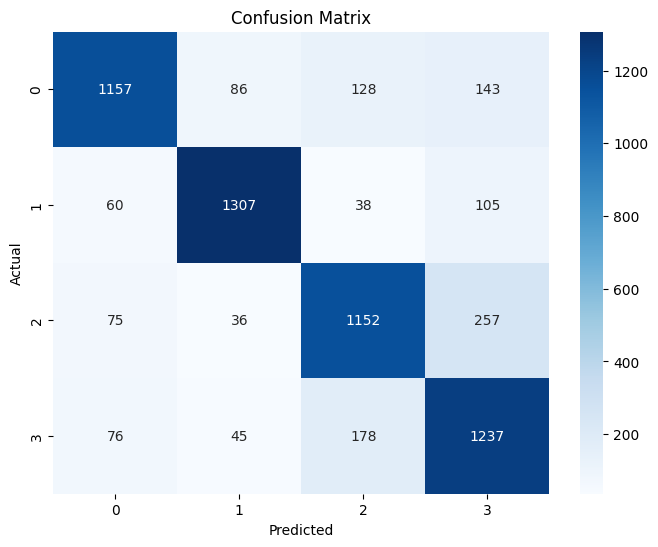

Epoch 11/30 - Avg Loss: 0.5189


Epoch 12/30: 100%|██████████| 211/211 [00:05<00:00, 39.28it/s]


🔍 Train Evaluation:
Accuracy: 0.8251 | F1: 0.8247 | Precision: 0.8305 | Recall: 0.8250

Confusion Matrix:
[[21791  1661  1234  2317]
 [  580 24909   241  1286]
 [ 1550   850 19446  5080]
 [ 1307   987  1800 22961]]


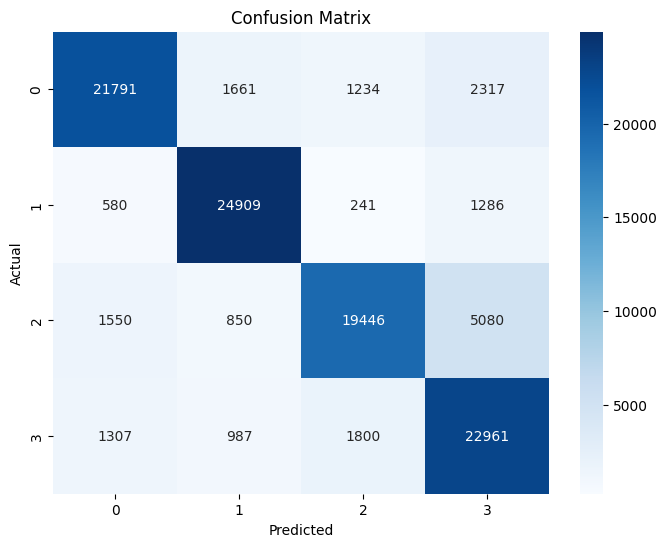

🧪 Test Evaluation:
Accuracy: 0.7997 | F1: 0.7996 | Precision: 0.8050 | Recall: 0.7997

Confusion Matrix:
[[1182  110   83  139]
 [  50 1352   18   90]
 [ 102   54 1062  302]
 [  75   68  127 1266]]


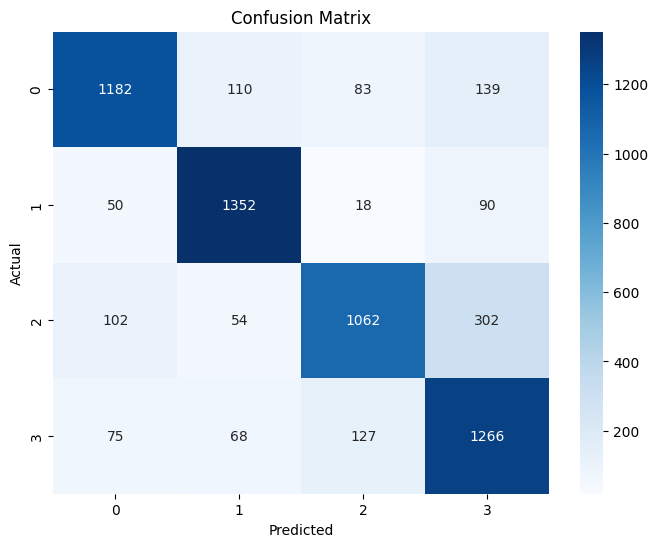

Epoch 12/30 - Avg Loss: 0.5051


Epoch 13/30: 100%|██████████| 211/211 [00:05<00:00, 38.85it/s]


🔍 Train Evaluation:
Accuracy: 0.8276 | F1: 0.8291 | Precision: 0.8346 | Recall: 0.8276

Confusion Matrix:
[[21763  1041  1820  2379]
 [  858 23608   559  1991]
 [ 1130   359 20917  4520]
 [ 1182   454  2323 23096]]


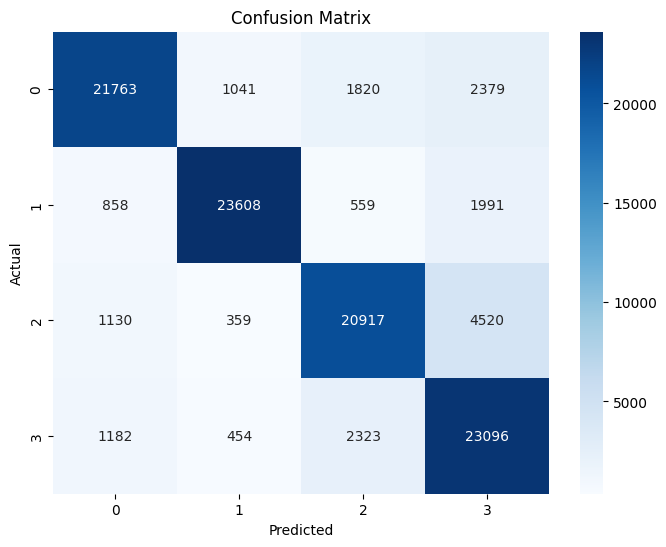

🧪 Test Evaluation:
Accuracy: 0.8003 | F1: 0.8019 | Precision: 0.8069 | Recall: 0.8003

Confusion Matrix:
[[1179   75  123  137]
 [  64 1287   41  118]
 [  81   30 1133  276]
 [  74   34  161 1267]]


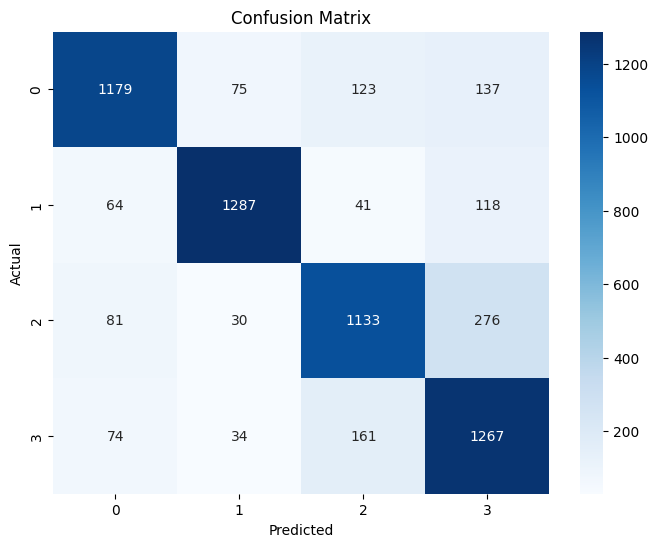

Epoch 13/30 - Avg Loss: 0.4900


Epoch 14/30: 100%|██████████| 211/211 [00:06<00:00, 32.09it/s]


🔍 Train Evaluation:
Accuracy: 0.8382 | F1: 0.8380 | Precision: 0.8384 | Recall: 0.8382

Confusion Matrix:
[[22538  1296  1528  1641]
 [  835 24896   350   935]
 [ 1471   680 21122  3653]
 [ 1543   940  2599 21973]]


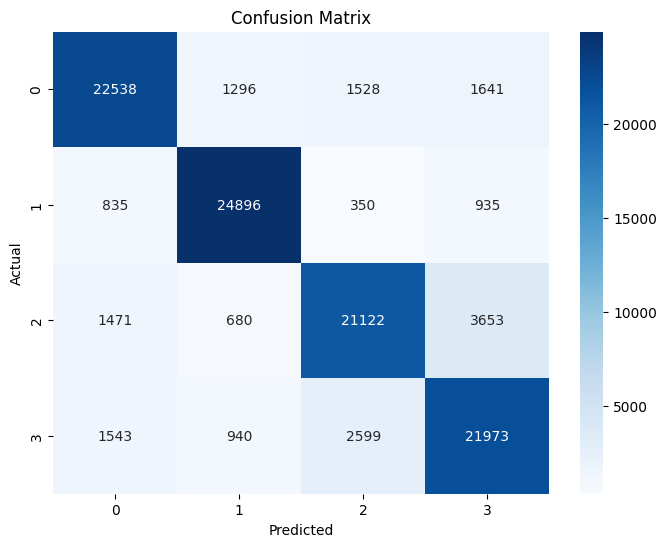

🧪 Test Evaluation:
Accuracy: 0.8097 | F1: 0.8096 | Precision: 0.8096 | Recall: 0.8099

Confusion Matrix:
[[1212   95  102  105]
 [  72 1347   31   60]
 [ 106   58 1156  200]
 [  89   60  179 1208]]


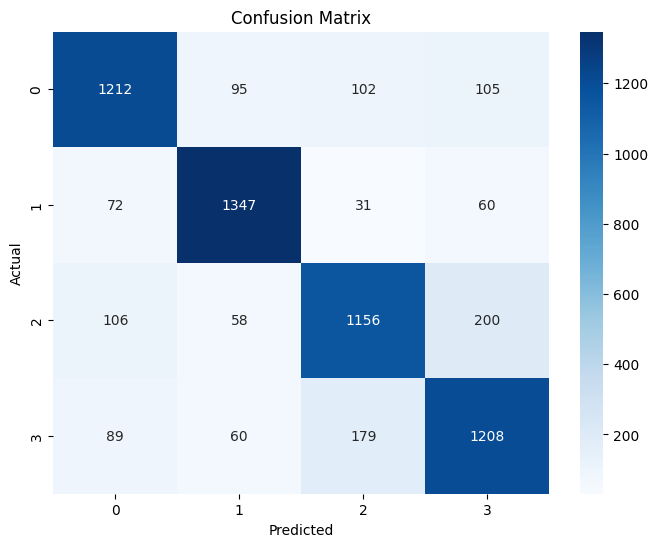

Epoch 14/30 - Avg Loss: 0.4815


Epoch 15/30: 100%|██████████| 211/211 [00:06<00:00, 32.54it/s]


🔍 Train Evaluation:
Accuracy: 0.8384 | F1: 0.8376 | Precision: 0.8386 | Recall: 0.8384

Confusion Matrix:
[[23037  1169  1845   952]
 [  973 24999   521   523]
 [ 1432   606 22342  2546]
 [ 2158   982  3749 20166]]


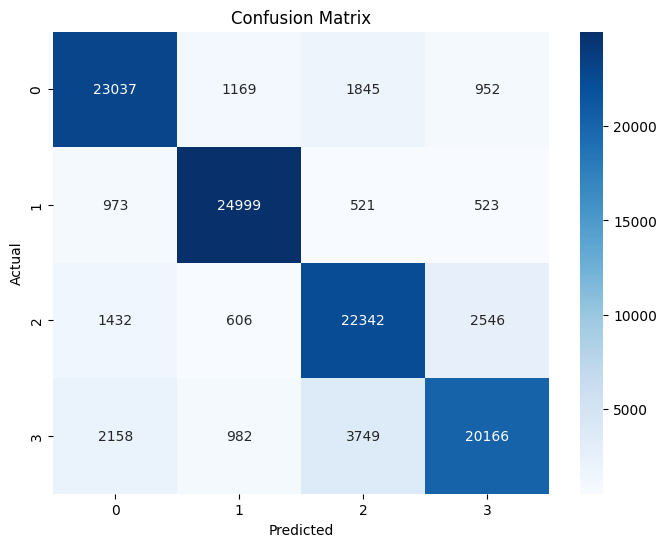

🧪 Test Evaluation:
Accuracy: 0.8059 | F1: 0.8055 | Precision: 0.8075 | Recall: 0.8063

Confusion Matrix:
[[1253   79  127   55]
 [  81 1340   44   45]
 [ 101   46 1224  149]
 [ 125   69  259 1083]]


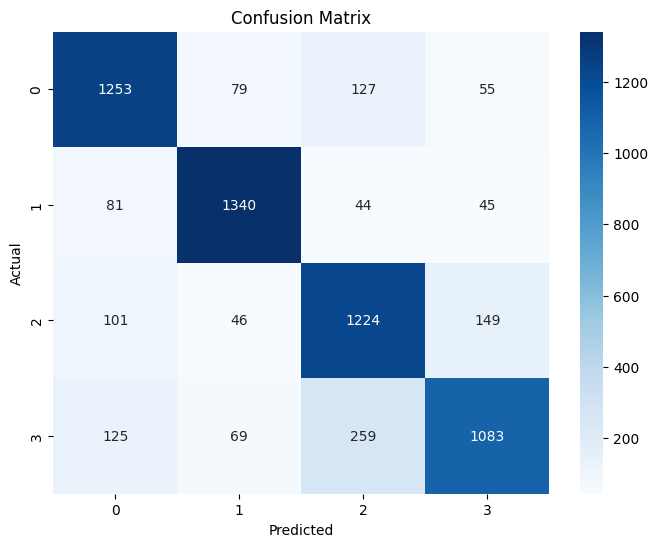

Epoch 15/30 - Avg Loss: 0.4684


Epoch 16/30: 100%|██████████| 211/211 [00:05<00:00, 37.02it/s]


🔍 Train Evaluation:
Accuracy: 0.8481 | F1: 0.8479 | Precision: 0.8481 | Recall: 0.8481

Confusion Matrix:
[[23276  1043  1342  1342]
 [  992 24866   375   783]
 [ 1687   486 21428  3325]
 [ 1738   759  2531 22027]]


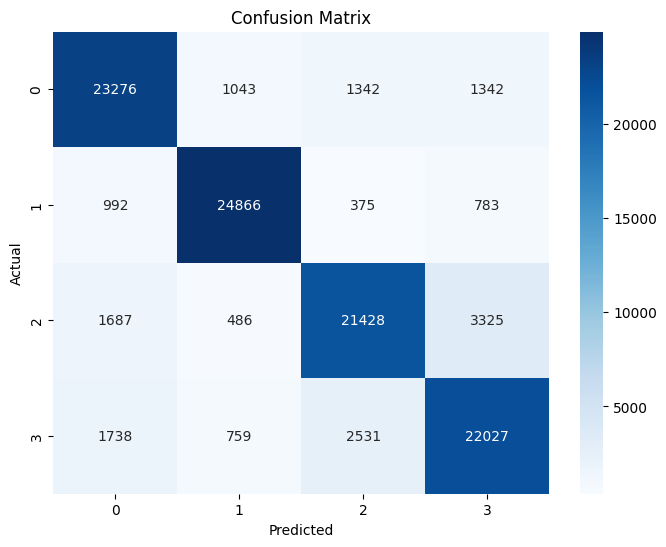

🧪 Test Evaluation:
Accuracy: 0.8160 | F1: 0.8160 | Precision: 0.8161 | Recall: 0.8162

Confusion Matrix:
[[1260   78   97   79]
 [  88 1334   27   61]
 [ 114   44 1168  194]
 [ 106   54  177 1199]]


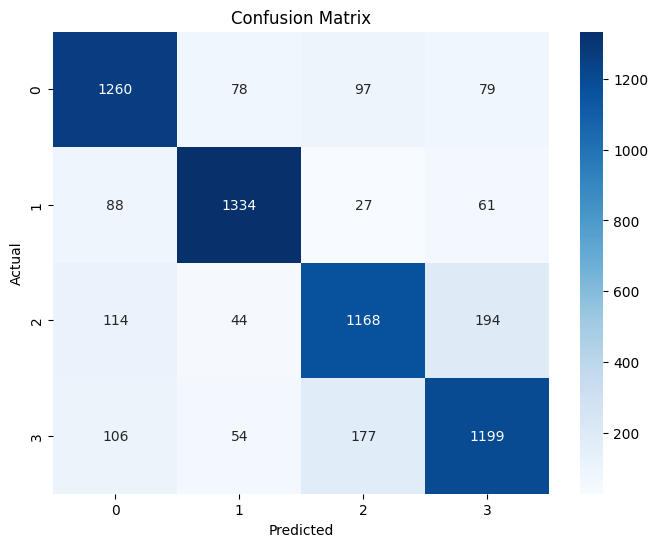

Epoch 16/30 - Avg Loss: 0.4612


Epoch 17/30: 100%|██████████| 211/211 [00:05<00:00, 38.36it/s]


🔍 Train Evaluation:
Accuracy: 0.8482 | F1: 0.8471 | Precision: 0.8486 | Recall: 0.8481

Confusion Matrix:
[[23537  1304  1071  1091]
 [  711 25480   272   553]
 [ 1936   749 20434  3807]
 [ 2116   985  1802 22152]]


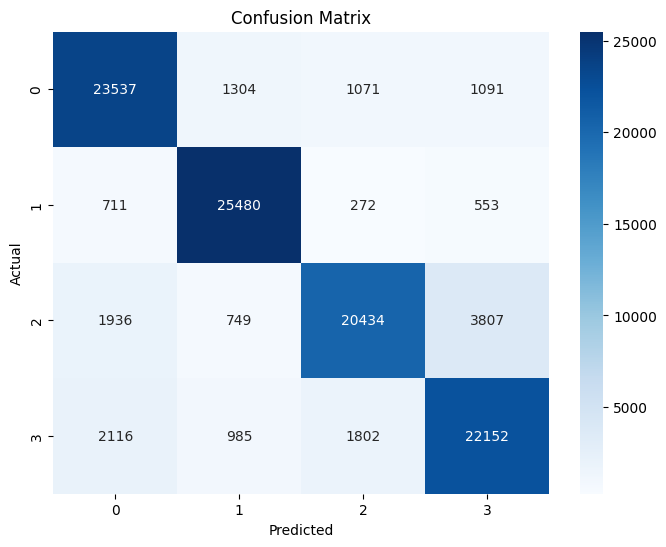

🧪 Test Evaluation:
Accuracy: 0.8133 | F1: 0.8122 | Precision: 0.8131 | Recall: 0.8136

Confusion Matrix:
[[1269   97   84   64]
 [  74 1382   21   33]
 [ 149   50 1093  228]
 [ 119   72  144 1201]]


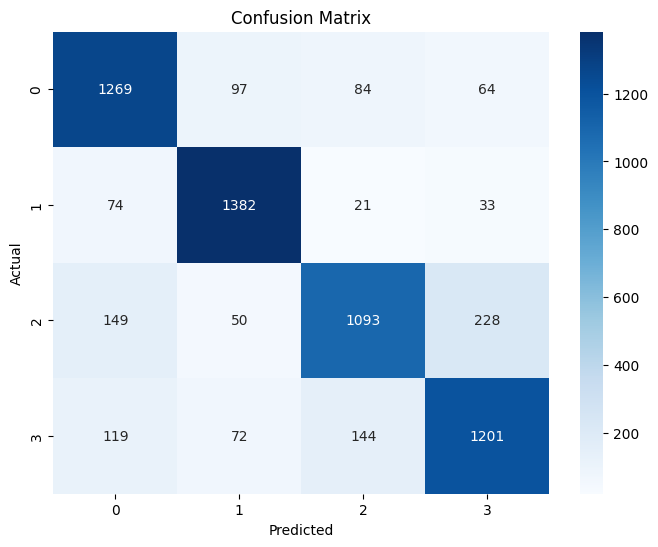

Epoch 17/30 - Avg Loss: 0.4521


Epoch 18/30: 100%|██████████| 211/211 [00:05<00:00, 35.25it/s]


🔍 Train Evaluation:
Accuracy: 0.8564 | F1: 0.8564 | Precision: 0.8580 | Recall: 0.8564

Confusion Matrix:
[[22091  1442  1705  1765]
 [  388 25345   465   818]
 [  961   509 22229  3227]
 [  984   641  2601 22829]]


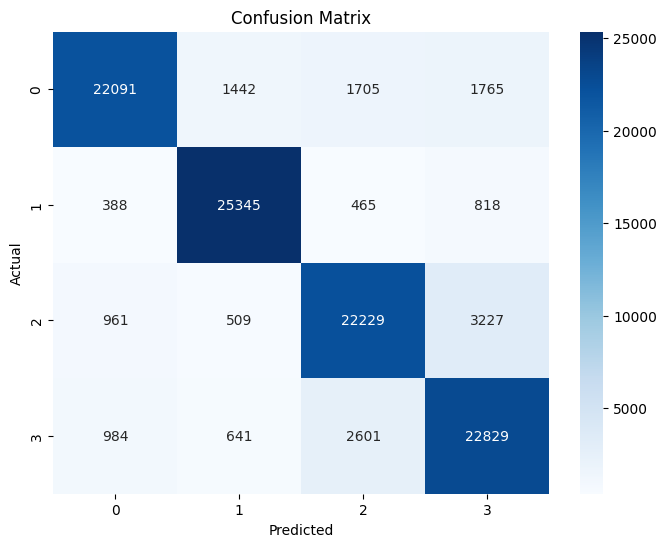

🧪 Test Evaluation:
Accuracy: 0.8187 | F1: 0.8190 | Precision: 0.8208 | Recall: 0.8189

Confusion Matrix:
[[1176  105  130  103]
 [  39 1371   31   69]
 [  71   43 1203  203]
 [  64   51  193 1228]]


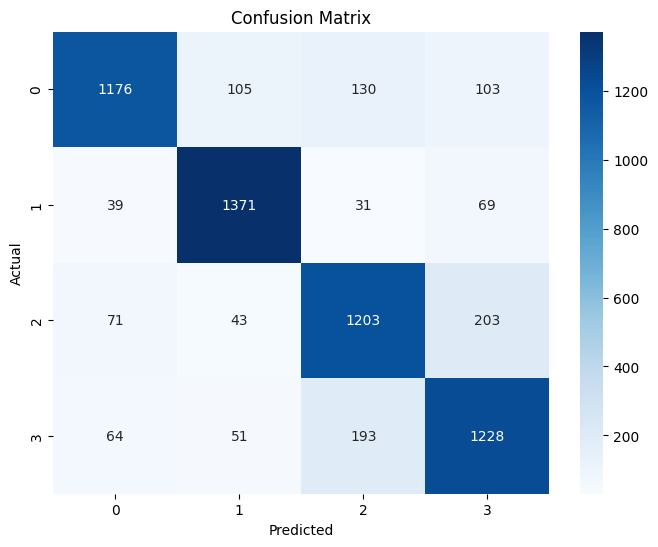

Epoch 18/30 - Avg Loss: 0.4365


Epoch 19/30: 100%|██████████| 211/211 [00:06<00:00, 33.89it/s]


🔍 Train Evaluation:
Accuracy: 0.8513 | F1: 0.8498 | Precision: 0.8513 | Recall: 0.8513

Confusion Matrix:
[[23846  1357  1083   717]
 [  652 25814   318   232]
 [ 2029   792 21739  2366]
 [ 2304  1466  2742 20543]]


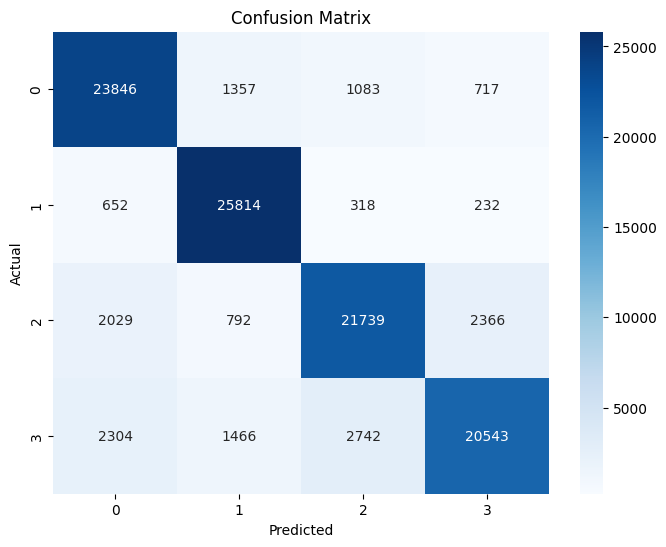

🧪 Test Evaluation:
Accuracy: 0.8086 | F1: 0.8070 | Precision: 0.8093 | Recall: 0.8090

Confusion Matrix:
[[1280  103   86   45]
 [  78 1386   25   21]
 [ 140   62 1168  150]
 [ 143  112  199 1082]]


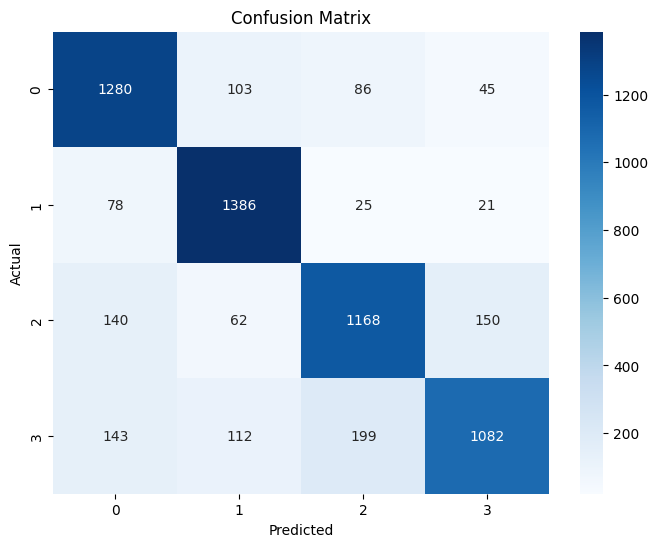

Epoch 19/30 - Avg Loss: 0.4273


Epoch 20/30: 100%|██████████| 211/211 [00:06<00:00, 31.88it/s]


🔍 Train Evaluation:
Accuracy: 0.8584 | F1: 0.8587 | Precision: 0.8652 | Recall: 0.8583

Confusion Matrix:
[[23228   881  1039  1855]
 [  688 24797   251  1280]
 [ 1396   427 20324  4779]
 [ 1179   351  1168 24357]]


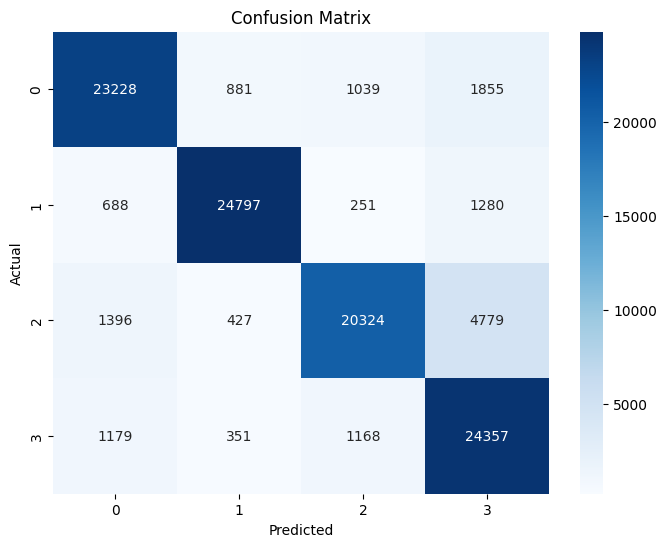

🧪 Test Evaluation:
Accuracy: 0.8130 | F1: 0.8134 | Precision: 0.8200 | Recall: 0.8130

Confusion Matrix:
[[1234   76   85  119]
 [  81 1317   19   93]
 [ 103   34 1072  311]
 [  78   34  104 1320]]


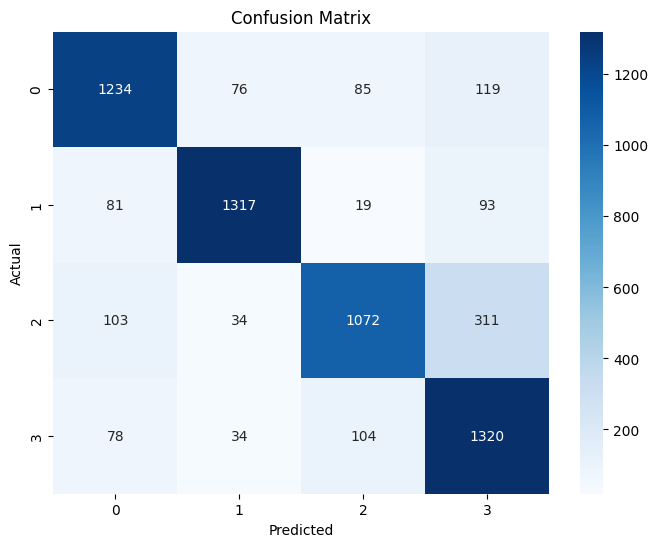

Epoch 20/30 - Avg Loss: 0.4163


Epoch 21/30: 100%|██████████| 211/211 [00:05<00:00, 35.20it/s]


🔍 Train Evaluation:
Accuracy: 0.8721 | F1: 0.8719 | Precision: 0.8725 | Recall: 0.8721

Confusion Matrix:
[[23265  1043  1266  1429]
 [  588 25534   246   648]
 [ 1092   634 22110  3090]
 [ 1134   611  2031 23279]]


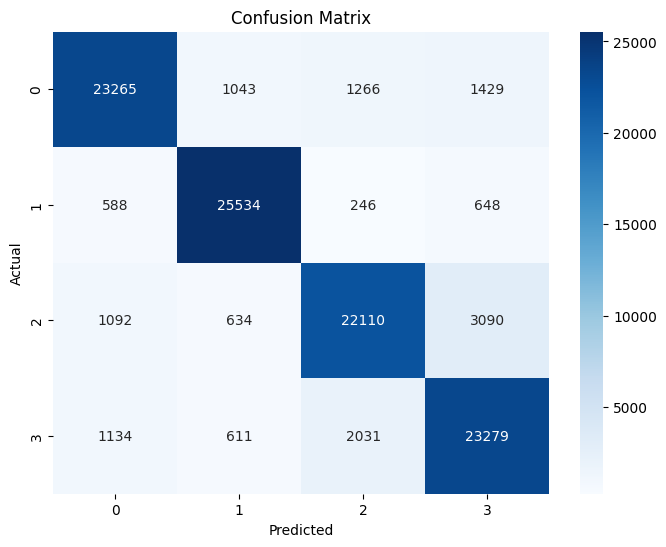

🧪 Test Evaluation:
Accuracy: 0.8201 | F1: 0.8199 | Precision: 0.8200 | Recall: 0.8203

Confusion Matrix:
[[1222   85  110   97]
 [  71 1368   25   46]
 [  93   51 1169  207]
 [  75   62  172 1227]]


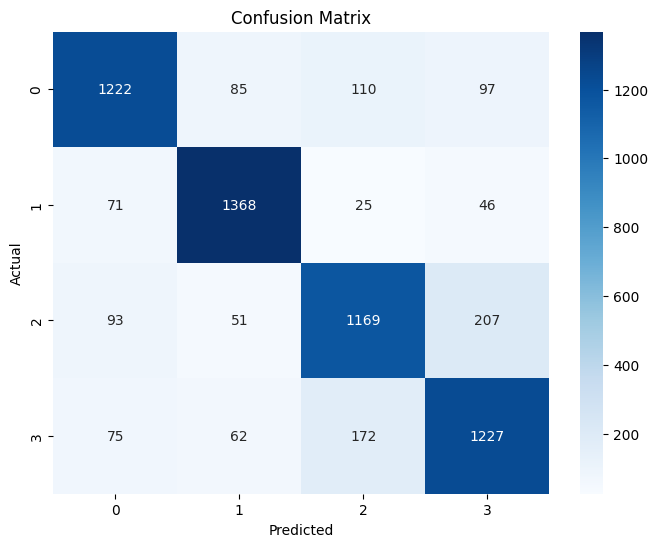

Epoch 21/30 - Avg Loss: 0.4022


Epoch 22/30: 100%|██████████| 211/211 [00:05<00:00, 37.30it/s]


🔍 Train Evaluation:
Accuracy: 0.8681 | F1: 0.8674 | Precision: 0.8708 | Recall: 0.8680

Confusion Matrix:
[[24014   924   778  1287]
 [  745 25490   162   619]
 [ 2067   576 20505  3778]
 [ 1517   532  1261 23745]]


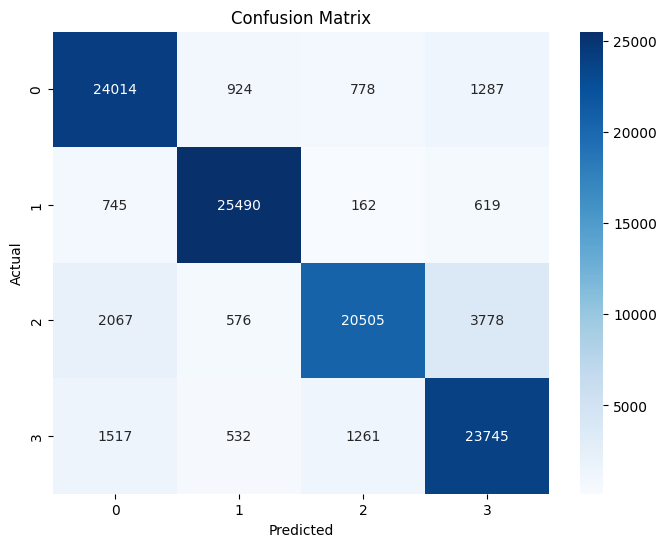

🧪 Test Evaluation:
Accuracy: 0.8138 | F1: 0.8134 | Precision: 0.8168 | Recall: 0.8140

Confusion Matrix:
[[1275   74   72   93]
 [  89 1348   12   61]
 [ 146   42 1072  260]
 [ 107   55  121 1253]]


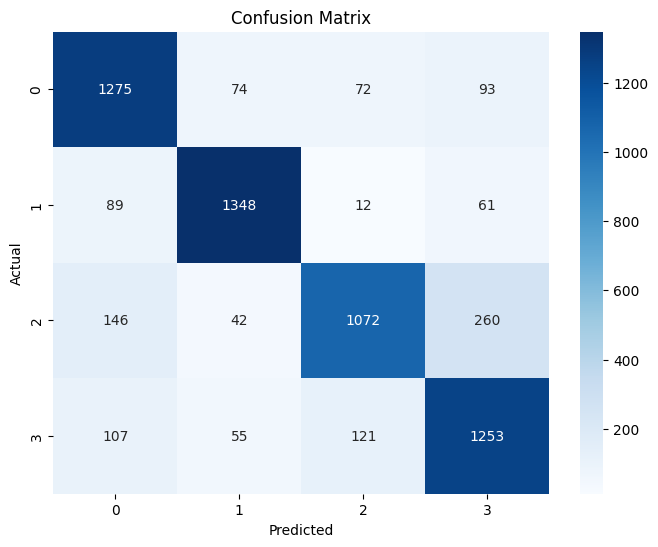

Epoch 22/30 - Avg Loss: 0.3893


Epoch 23/30: 100%|██████████| 211/211 [00:05<00:00, 38.08it/s]


🔍 Train Evaluation:
Accuracy: 0.8797 | F1: 0.8800 | Precision: 0.8823 | Recall: 0.8797

Confusion Matrix:
[[23492   785  1263  1463]
 [  592 25202   380   842]
 [  965   354 22027  3580]
 [ 1018   332  1416 24289]]


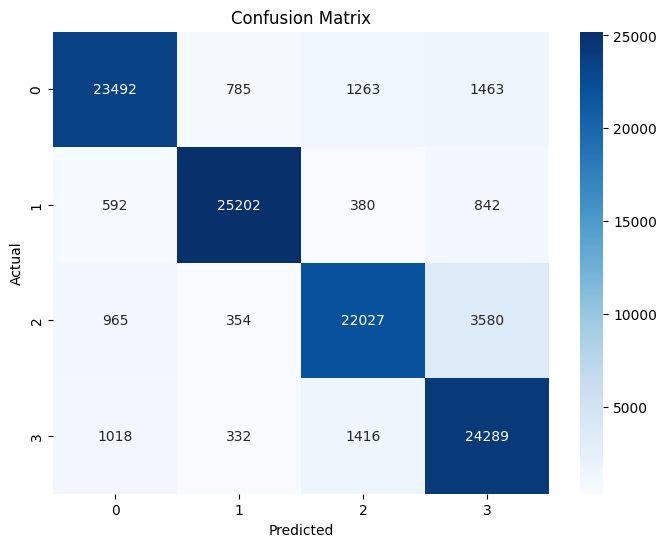

🧪 Test Evaluation:
Accuracy: 0.8109 | F1: 0.8114 | Precision: 0.8136 | Recall: 0.8109

Confusion Matrix:
[[1214   76  113  111]
 [  86 1318   29   77]
 [  92   37 1135  256]
 [  78   41  154 1263]]


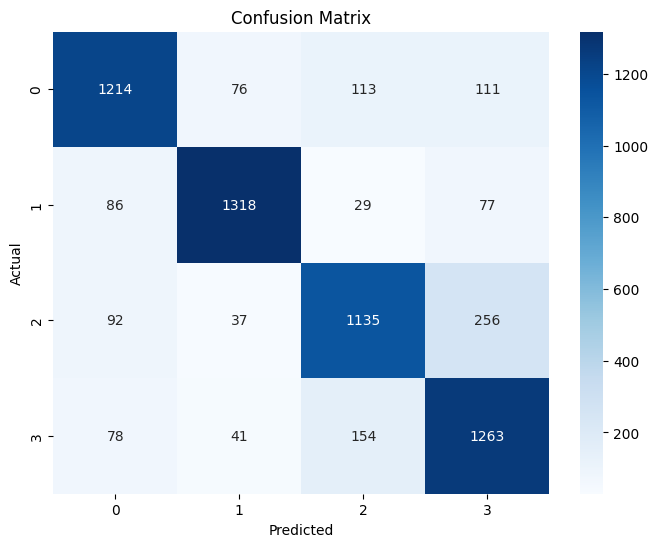

Epoch 23/30 - Avg Loss: 0.3763


Epoch 24/30: 100%|██████████| 211/211 [00:05<00:00, 36.75it/s]


🔍 Train Evaluation:
Accuracy: 0.8813 | F1: 0.8804 | Precision: 0.8809 | Recall: 0.8813

Confusion Matrix:
[[23918  1141  1128   816]
 [  489 26147   207   173]
 [ 1133   860 22812  2121]
 [ 1419  1136  2201 22299]]


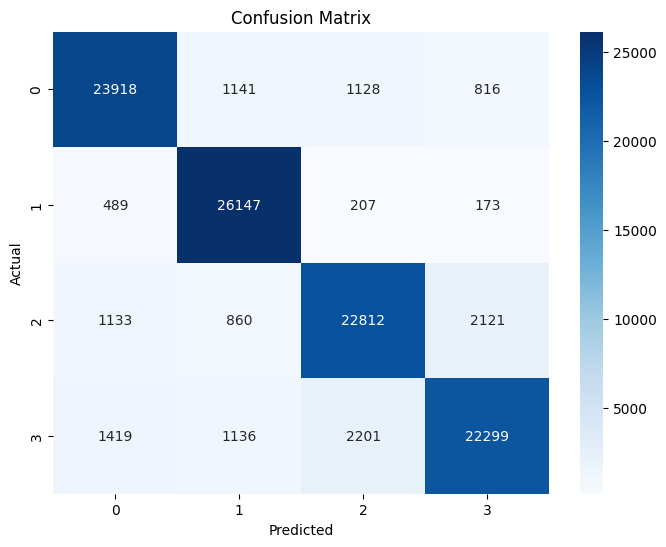

🧪 Test Evaluation:
Accuracy: 0.8150 | F1: 0.8138 | Precision: 0.8144 | Recall: 0.8154

Confusion Matrix:
[[1245   99  111   59]
 [  69 1396   15   30]
 [ 101   71 1180  168]
 [ 105  103  194 1134]]


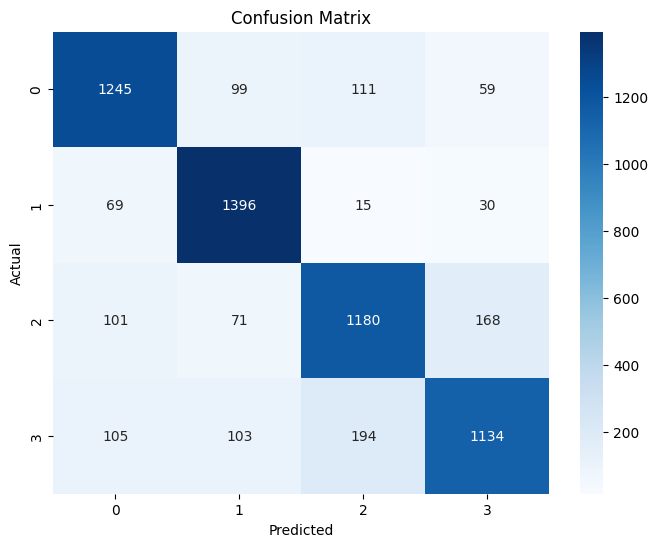

Epoch 24/30 - Avg Loss: 0.3636


Epoch 25/30: 100%|██████████| 211/211 [00:06<00:00, 31.46it/s]


🔍 Train Evaluation:
Accuracy: 0.8929 | F1: 0.8931 | Precision: 0.8937 | Recall: 0.8928

Confusion Matrix:
[[24018   649  1280  1056]
 [  603 25181   598   634]
 [  922   258 23231  2515]
 [ 1116   216  1724 23999]]


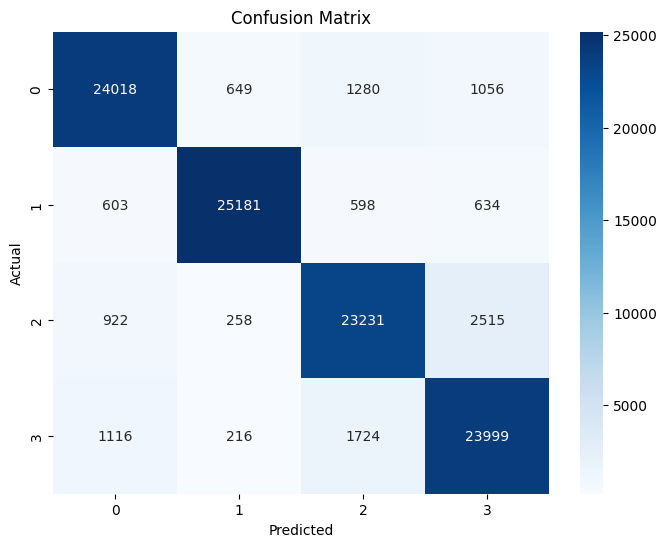

🧪 Test Evaluation:
Accuracy: 0.8166 | F1: 0.8174 | Precision: 0.8182 | Recall: 0.8168

Confusion Matrix:
[[1238   73  113   90]
 [  87 1315   46   62]
 [  91   30 1193  206]
 [  93   33  191 1219]]


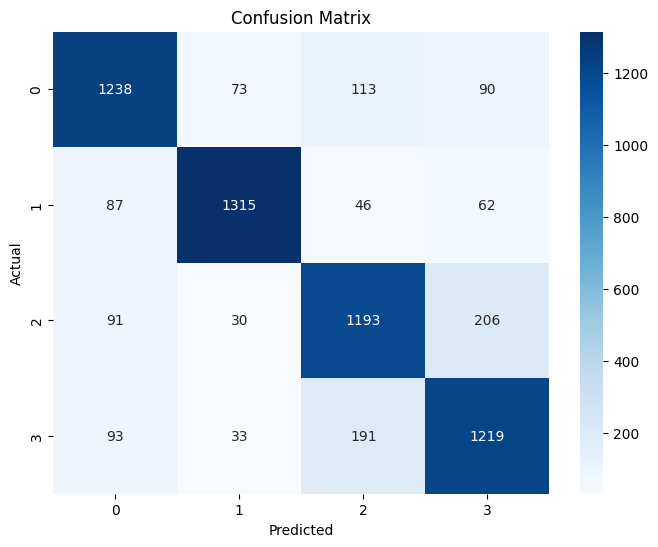

Epoch 25/30 - Avg Loss: 0.3532


Epoch 26/30: 100%|██████████| 211/211 [00:06<00:00, 33.80it/s]


🔍 Train Evaluation:
Accuracy: 0.8870 | F1: 0.8869 | Precision: 0.8899 | Recall: 0.8871

Confusion Matrix:
[[23555   845  1849   754]
 [  377 25898   531   210]
 [  626   368 24445  1487]
 [ 1026   629  3501 21899]]


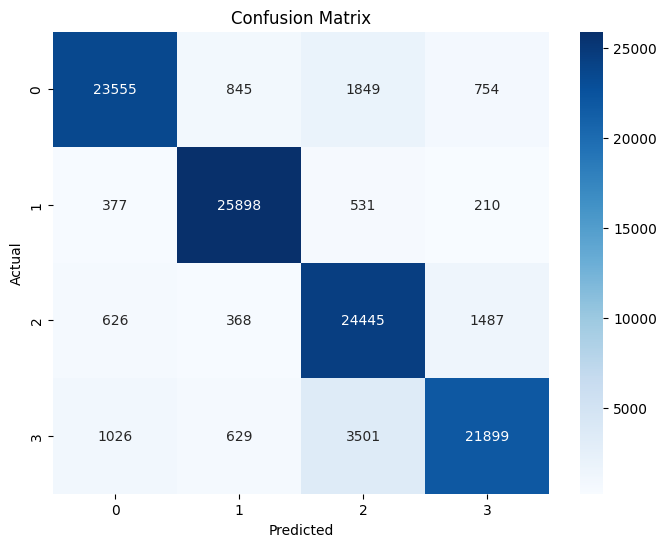

🧪 Test Evaluation:
Accuracy: 0.8090 | F1: 0.8090 | Precision: 0.8133 | Recall: 0.8094

Confusion Matrix:
[[1202   84  157   71]
 [  71 1356   49   34]
 [  76   35 1273  136]
 [  84   69  295 1088]]


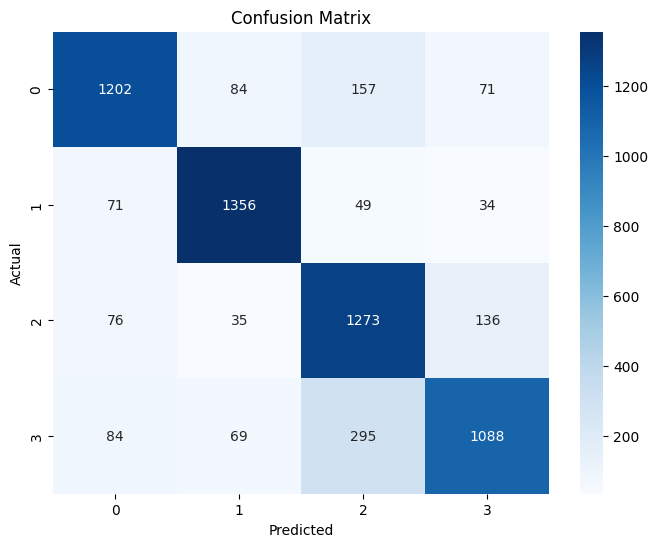

Epoch 26/30 - Avg Loss: 0.3408


Epoch 27/30: 100%|██████████| 211/211 [00:05<00:00, 37.08it/s]


🔍 Train Evaluation:
Accuracy: 0.8944 | F1: 0.8947 | Precision: 0.8964 | Recall: 0.8944

Confusion Matrix:
[[23307   729  1989   978]
 [  461 25656   643   256]
 [  570   295 24250  1811]
 [  782   444  2444 23385]]


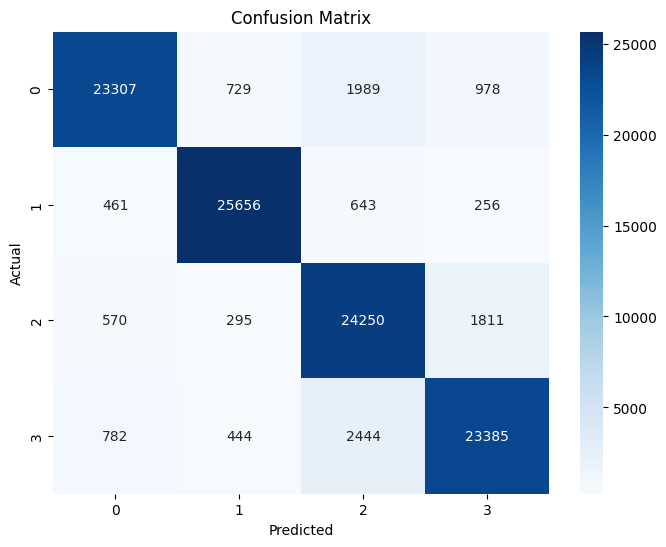

🧪 Test Evaluation:
Accuracy: 0.8110 | F1: 0.8117 | Precision: 0.8146 | Recall: 0.8113

Confusion Matrix:
[[1194   69  162   89]
 [  81 1344   47   38]
 [  69   33 1247  171]
 [  69   55  266 1146]]


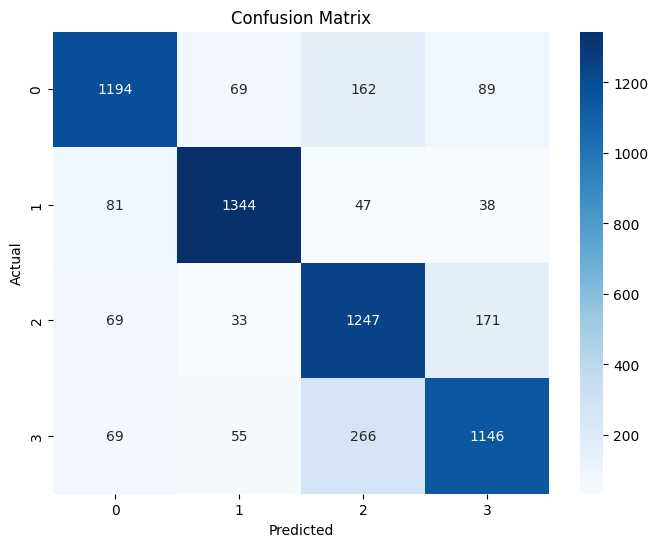

Epoch 27/30 - Avg Loss: 0.3281


Epoch 28/30: 100%|██████████| 211/211 [00:05<00:00, 37.07it/s]


🔍 Train Evaluation:
Accuracy: 0.9066 | F1: 0.9065 | Precision: 0.9077 | Recall: 0.9066

Confusion Matrix:
[[23500   954  1363  1186]
 [  274 26156   297   289]
 [  516   439 23499  2472]
 [  616   466  1215 24758]]


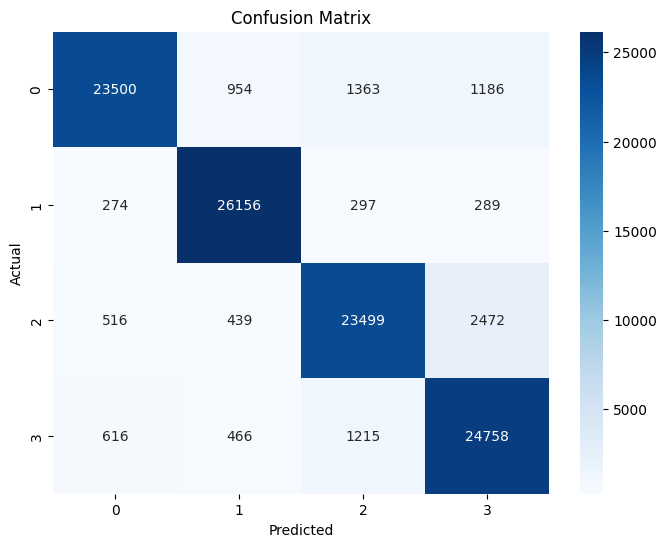

🧪 Test Evaluation:
Accuracy: 0.8176 | F1: 0.8175 | Precision: 0.8184 | Recall: 0.8178

Confusion Matrix:
[[1198   99  125   92]
 [  65 1373   26   46]
 [  72   45 1168  235]
 [  66   63  175 1232]]


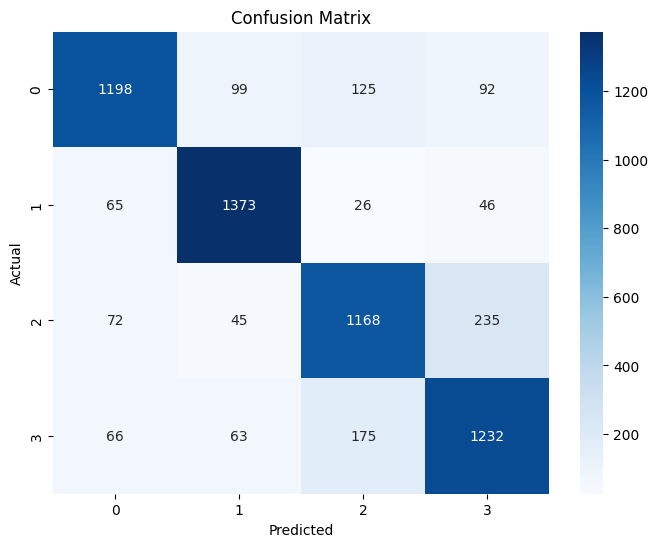

Epoch 28/30 - Avg Loss: 0.3134


Epoch 29/30: 100%|██████████| 211/211 [00:06<00:00, 34.29it/s]


🔍 Train Evaluation:
Accuracy: 0.9039 | F1: 0.9036 | Precision: 0.9054 | Recall: 0.9039

Confusion Matrix:
[[25433   530   591   449]
 [  782 25954   164   116]
 [ 1691   535 22948  1752]
 [ 1912   570  1286 23287]]


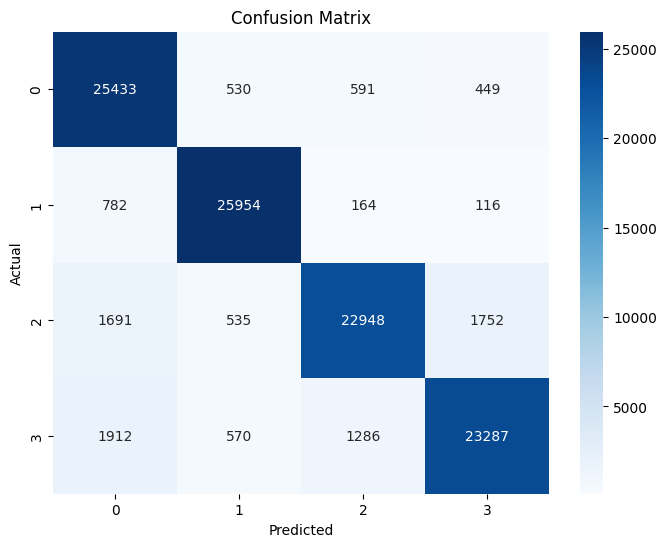

🧪 Test Evaluation:
Accuracy: 0.8015 | F1: 0.8008 | Precision: 0.8029 | Recall: 0.8019

Confusion Matrix:
[[1306   70   77   61]
 [ 118 1339   20   33]
 [ 150   51 1123  196]
 [ 165   65  201 1105]]


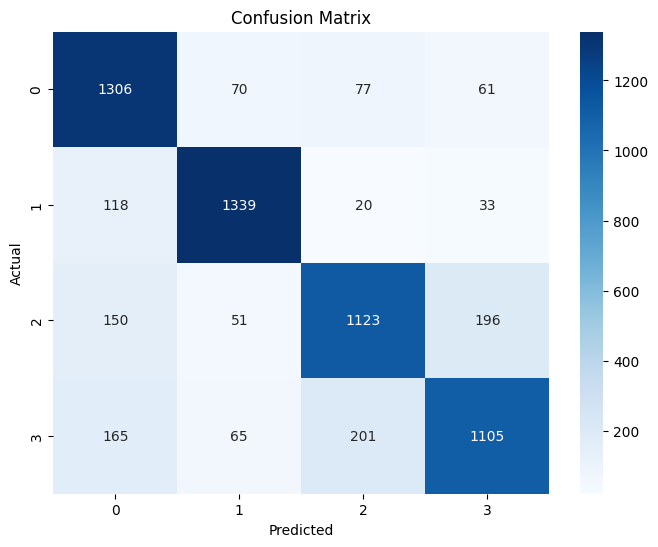

Epoch 29/30 - Avg Loss: 0.3012


Epoch 30/30: 100%|██████████| 211/211 [00:06<00:00, 33.88it/s]


🔍 Train Evaluation:
Accuracy: 0.9045 | F1: 0.9041 | Precision: 0.9079 | Recall: 0.9044

Confusion Matrix:
[[22735  1404  1398  1466]
 [  142 26325   197   352]
 [  389   564 23131  2842]
 [  371   473   721 25490]]


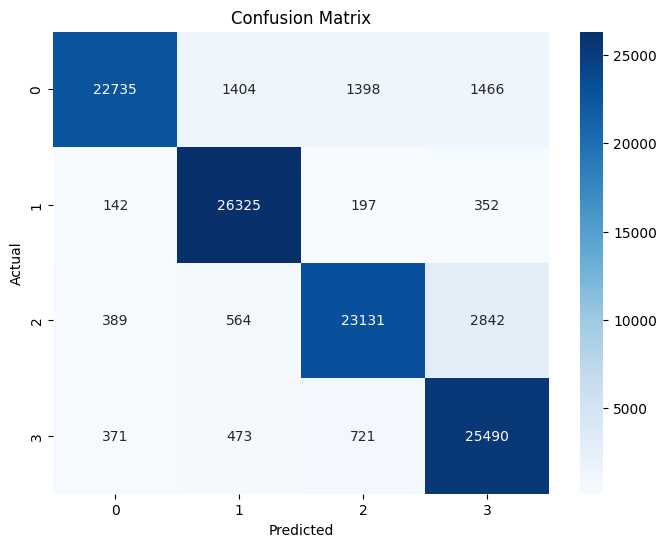

🧪 Test Evaluation:
Accuracy: 0.8104 | F1: 0.8101 | Precision: 0.8141 | Recall: 0.8104

Confusion Matrix:
[[1142  125  128  119]
 [  44 1382   29   55]
 [  62   53 1137  268]
 [  50   68  152 1266]]


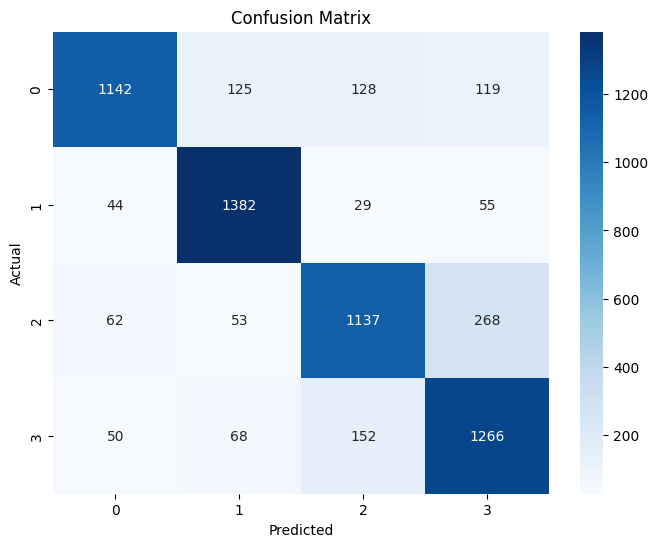

Epoch 30/30 - Avg Loss: 0.2849
✔ Saved classifier_cbow.pt
Training classifier with SKIPGRAM embeddings...


Epoch 1/30: 100%|██████████| 211/211 [00:06<00:00, 30.24it/s]


🔍 Train Evaluation:
Accuracy: 0.7299 | F1: 0.7326 | Precision: 0.7439 | Recall: 0.7298

Confusion Matrix:
[[19259  1672  2423  3649]
 [ 1793 20880   795  3548]
 [ 1787   649 17757  6733]
 [ 1786  1028  3311 20930]]


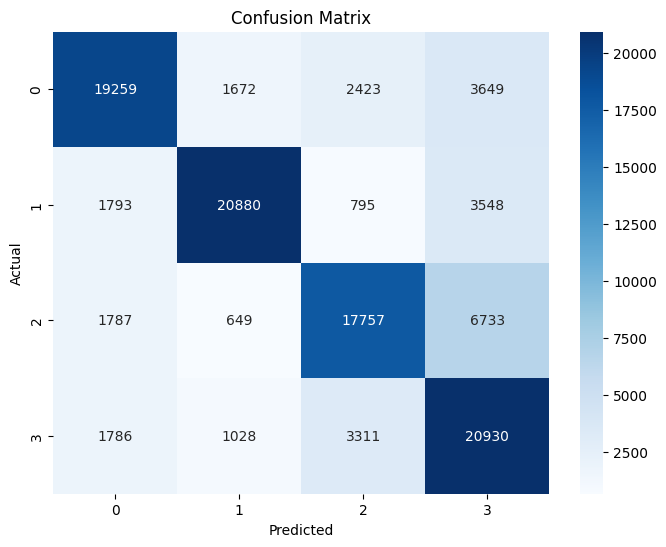

🧪 Test Evaluation:
Accuracy: 0.7275 | F1: 0.7304 | Precision: 0.7411 | Recall: 0.7274

Confusion Matrix:
[[1086   92  140  196]
 [  97 1164   43  206]
 [ 114   39  992  375]
 [  94   55  206 1181]]


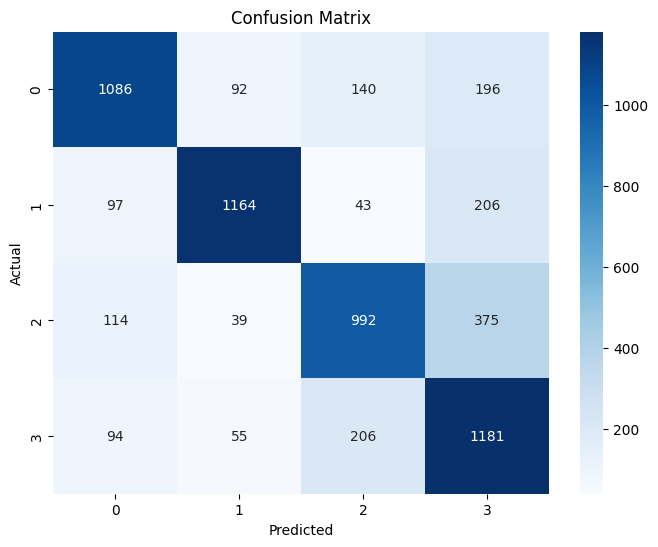

Epoch 1/30 - Avg Loss: 1.0076


Epoch 2/30: 100%|██████████| 211/211 [00:05<00:00, 35.31it/s]


🔍 Train Evaluation:
Accuracy: 0.8048 | F1: 0.8044 | Precision: 0.8067 | Recall: 0.8047

Confusion Matrix:
[[22578  1287  1420  1718]
 [ 1584 23914   359  1159]
 [ 2296   614 19154  4862]
 [ 2099  1159  2528 21269]]


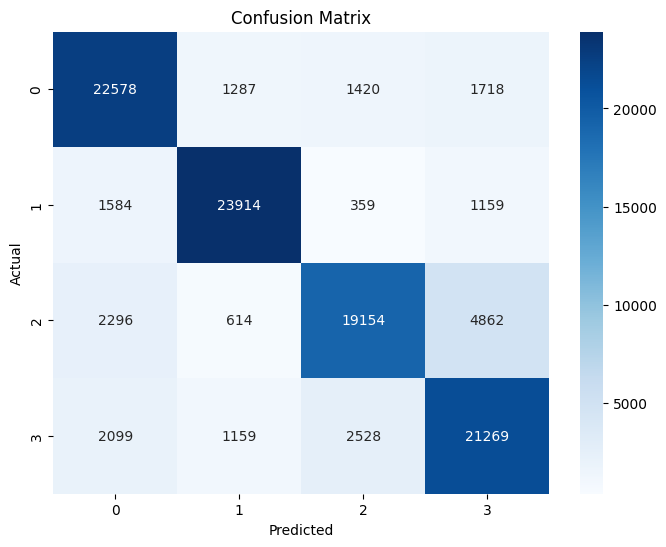

🧪 Test Evaluation:
Accuracy: 0.7921 | F1: 0.7918 | Precision: 0.7948 | Recall: 0.7923

Confusion Matrix:
[[1267   78   73   96]
 [ 102 1311   32   65]
 [ 144   40 1043  293]
 [ 131   61  149 1195]]


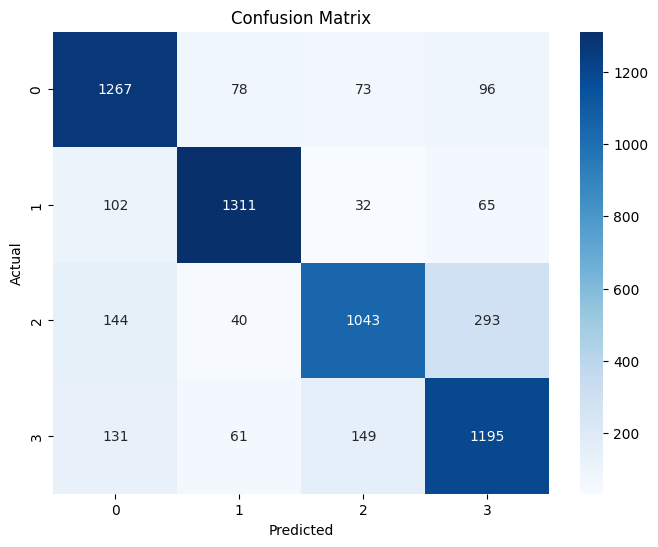

Epoch 2/30 - Avg Loss: 0.6187


Epoch 3/30: 100%|██████████| 211/211 [00:05<00:00, 36.48it/s]


🔍 Train Evaluation:
Accuracy: 0.8324 | F1: 0.8321 | Precision: 0.8333 | Recall: 0.8324

Confusion Matrix:
[[22273  1504  1640  1586]
 [  711 25001   287  1017]
 [ 1376   669 20579  4302]
 [ 1463  1068  2476 22048]]


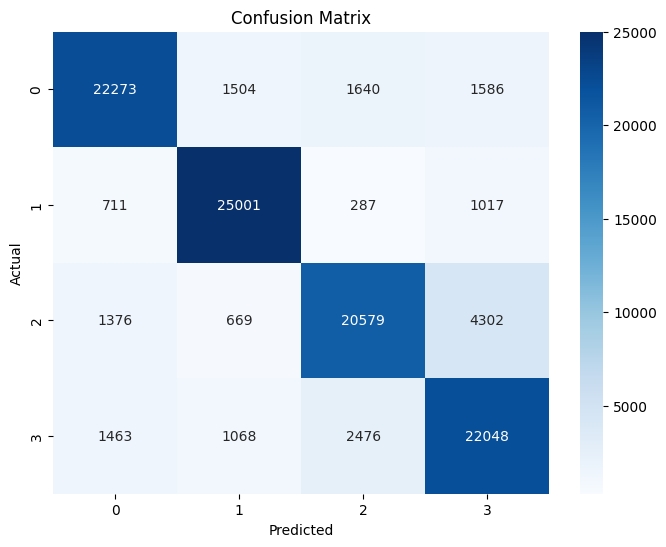

🧪 Test Evaluation:
Accuracy: 0.8160 | F1: 0.8157 | Precision: 0.8167 | Recall: 0.8161

Confusion Matrix:
[[1225  105   93   91]
 [  46 1383   21   60]
 [ 103   37 1121  259]
 [  81   58  165 1232]]


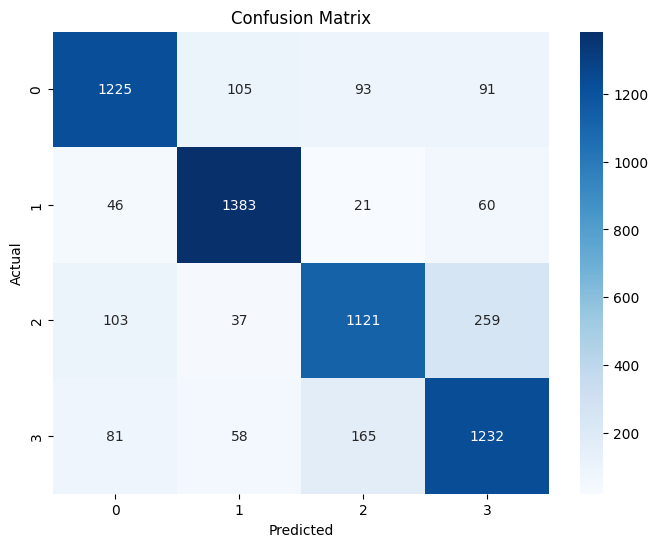

Epoch 3/30 - Avg Loss: 0.5226


Epoch 4/30: 100%|██████████| 211/211 [00:05<00:00, 35.71it/s]


🔍 Train Evaluation:
Accuracy: 0.8286 | F1: 0.8270 | Precision: 0.8321 | Recall: 0.8286

Confusion Matrix:
[[24237  1092  1028   646]
 [ 1395 25205   136   280]
 [ 2979   815 20382  2750]
 [ 3405  1433  2547 19670]]


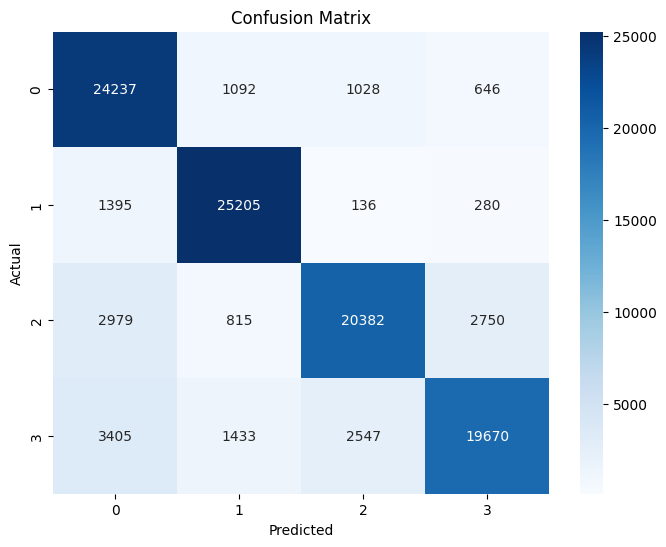

🧪 Test Evaluation:
Accuracy: 0.8127 | F1: 0.8110 | Precision: 0.8172 | Recall: 0.8132

Confusion Matrix:
[[1360   66   54   34]
 [ 100 1383    9   18]
 [ 190   50 1116  164]
 [ 193   94  167 1082]]


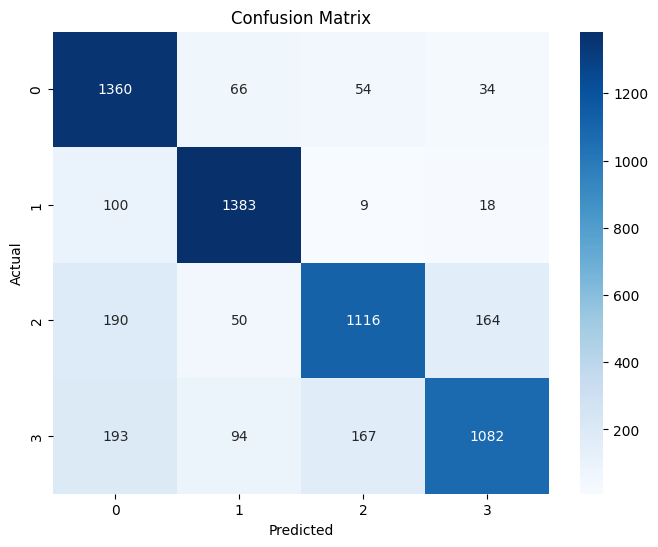

Epoch 4/30 - Avg Loss: 0.4819


Epoch 5/30: 100%|██████████| 211/211 [00:05<00:00, 35.77it/s]


🔍 Train Evaluation:
Accuracy: 0.8531 | F1: 0.8533 | Precision: 0.8546 | Recall: 0.8531

Confusion Matrix:
[[22422  1268  1535  1778]
 [  540 25117   361   998]
 [ 1127   437 21891  3471]
 [ 1085   576  2691 22703]]


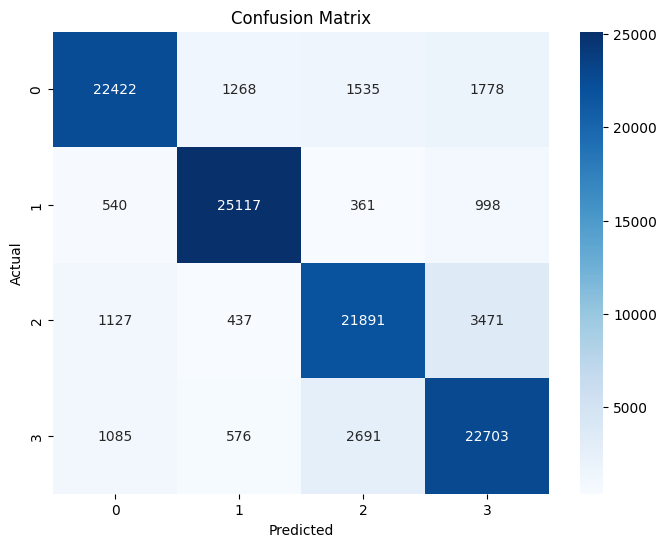

🧪 Test Evaluation:
Accuracy: 0.8309 | F1: 0.8315 | Precision: 0.8329 | Recall: 0.8311

Confusion Matrix:
[[1235   85   93  101]
 [  45 1369   29   67]
 [  80   26 1187  227]
 [  65   37  173 1261]]


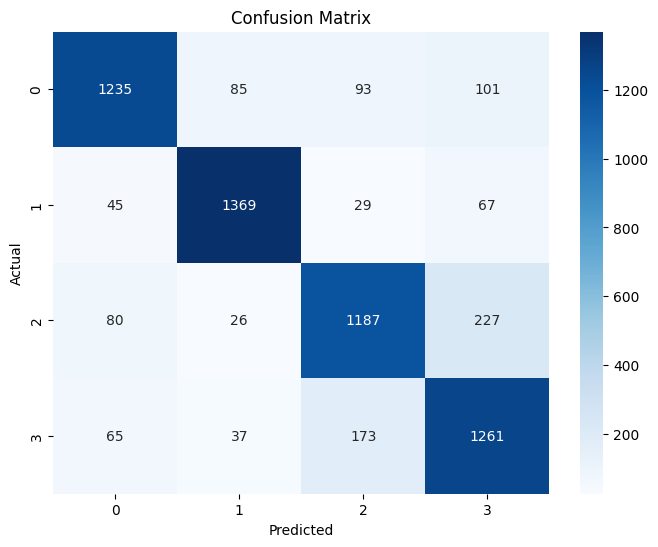

Epoch 5/30 - Avg Loss: 0.4534


Epoch 6/30: 100%|██████████| 211/211 [00:06<00:00, 31.16it/s]


🔍 Train Evaluation:
Accuracy: 0.8592 | F1: 0.8596 | Precision: 0.8609 | Recall: 0.8592

Confusion Matrix:
[[22635   973  1878  1517]
 [  661 25005   525   825]
 [  863   326 22505  3232]
 [ 1102   483  2825 22645]]


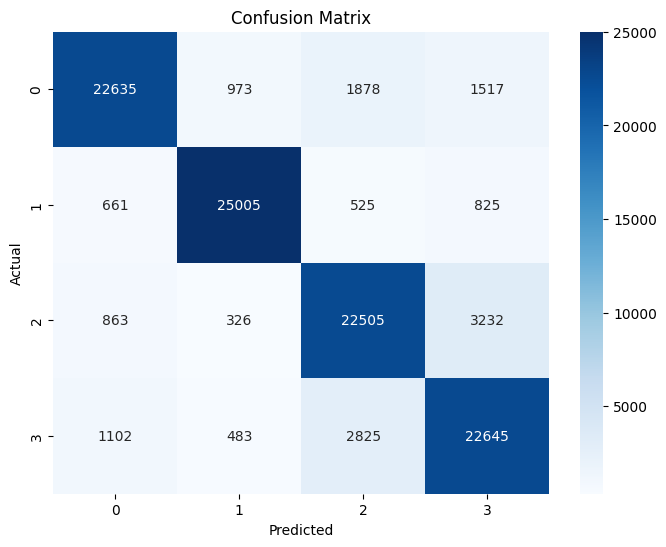

🧪 Test Evaluation:
Accuracy: 0.8352 | F1: 0.8359 | Precision: 0.8368 | Recall: 0.8354

Confusion Matrix:
[[1249   68  111   86]
 [  56 1363   37   54]
 [  74   24 1220  202]
 [  59   42  189 1246]]


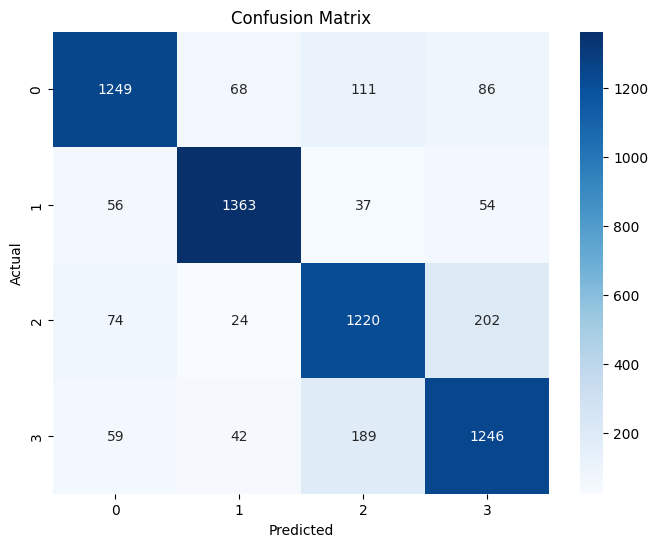

Epoch 6/30 - Avg Loss: 0.4329


Epoch 7/30: 100%|██████████| 211/211 [00:06<00:00, 31.19it/s]


🔍 Train Evaluation:
Accuracy: 0.8632 | F1: 0.8622 | Precision: 0.8630 | Recall: 0.8632

Confusion Matrix:
[[23003  1461  1534  1005]
 [  354 26151   218   293]
 [ 1026   713 22627  2560]
 [ 1283  1365  2961 21446]]


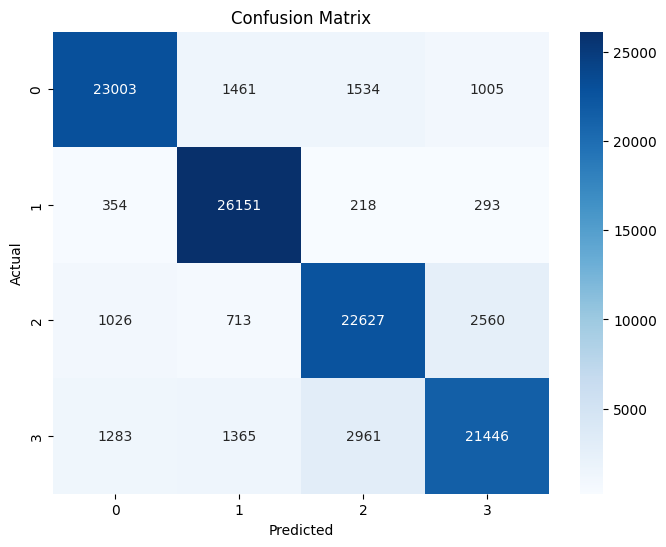

🧪 Test Evaluation:
Accuracy: 0.8354 | F1: 0.8345 | Precision: 0.8351 | Recall: 0.8357

Confusion Matrix:
[[1257   94  102   61]
 [  38 1431   19   22]
 [  86   52 1216  166]
 [  72   82  207 1175]]


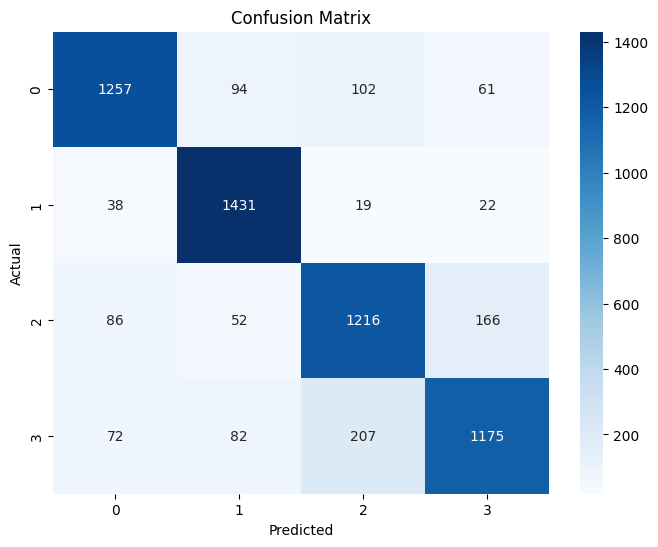

Epoch 7/30 - Avg Loss: 0.4119


Epoch 8/30: 100%|██████████| 211/211 [00:05<00:00, 36.04it/s]


🔍 Train Evaluation:
Accuracy: 0.8715 | F1: 0.8712 | Precision: 0.8715 | Recall: 0.8715

Confusion Matrix:
[[23991   890  1149   973]
 [  660 25565   253   538]
 [ 1470   385 21925  3146]
 [ 1873   516  2024 22642]]


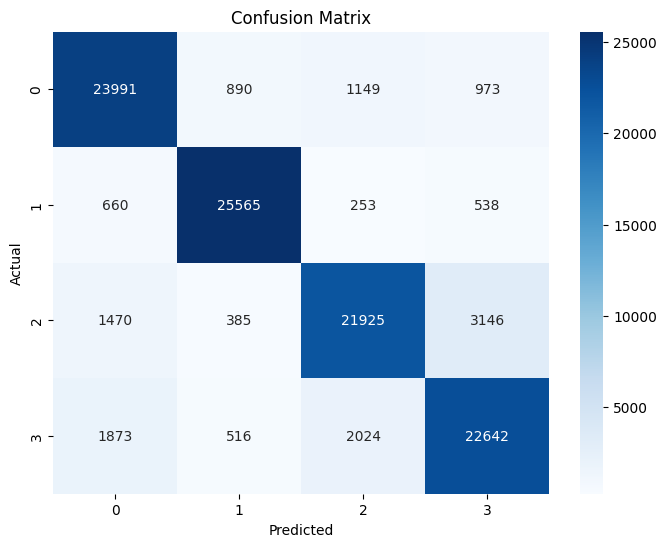

🧪 Test Evaluation:
Accuracy: 0.8431 | F1: 0.8428 | Precision: 0.8435 | Recall: 0.8433

Confusion Matrix:
[[1321   69   70   54]
 [  68 1385   18   39]
 [ 123   26 1174  197]
 [ 107   43  140 1246]]


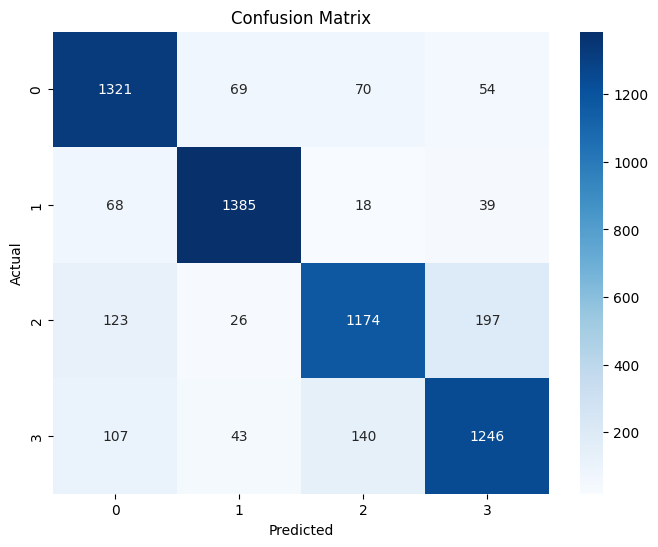

Epoch 8/30 - Avg Loss: 0.3960


Epoch 9/30: 100%|██████████| 211/211 [00:05<00:00, 35.93it/s]


🔍 Train Evaluation:
Accuracy: 0.8790 | F1: 0.8787 | Precision: 0.8790 | Recall: 0.8790

Confusion Matrix:
[[23873   906  1121  1103]
 [  594 25767   193   462]
 [ 1248   446 22093  3139]
 [ 1296   599  1957 23203]]


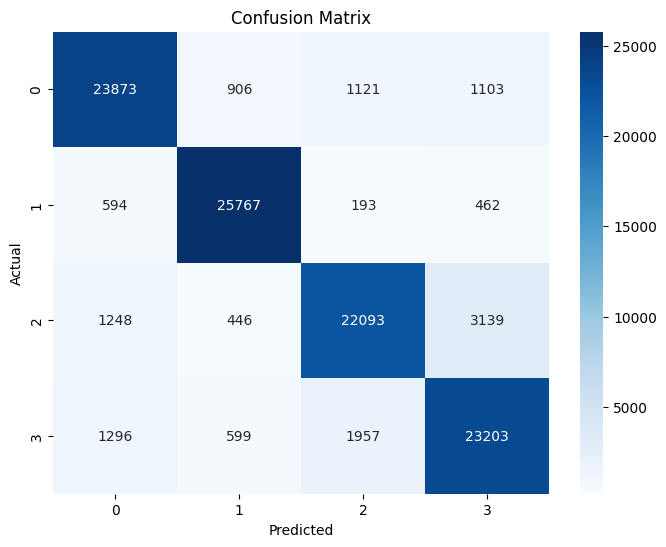

🧪 Test Evaluation:
Accuracy: 0.8461 | F1: 0.8457 | Precision: 0.8460 | Recall: 0.8463

Confusion Matrix:
[[1306   73   72   63]
 [  57 1401   16   36]
 [ 101   29 1174  216]
 [  83   49  141 1263]]


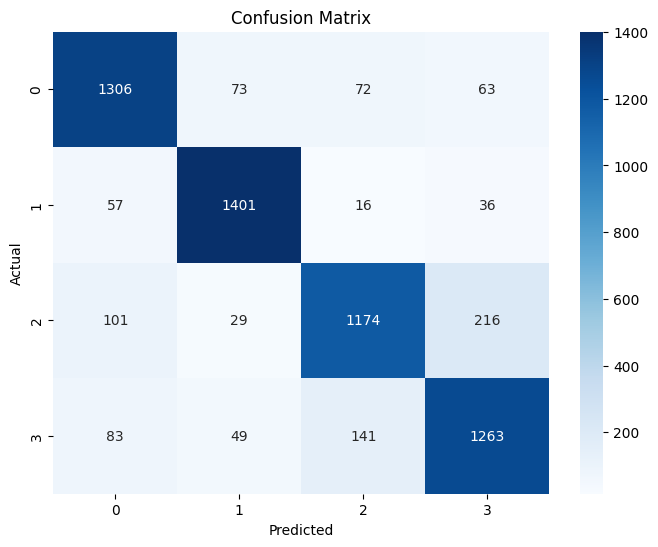

Epoch 9/30 - Avg Loss: 0.3841


Epoch 10/30: 100%|██████████| 211/211 [00:05<00:00, 35.82it/s]


🔍 Train Evaluation:
Accuracy: 0.8809 | F1: 0.8808 | Precision: 0.8824 | Recall: 0.8809

Confusion Matrix:
[[23729   830  1129  1315]
 [  536 25666   205   609]
 [ 1121   365 21809  3631]
 [ 1094   453  1573 23935]]


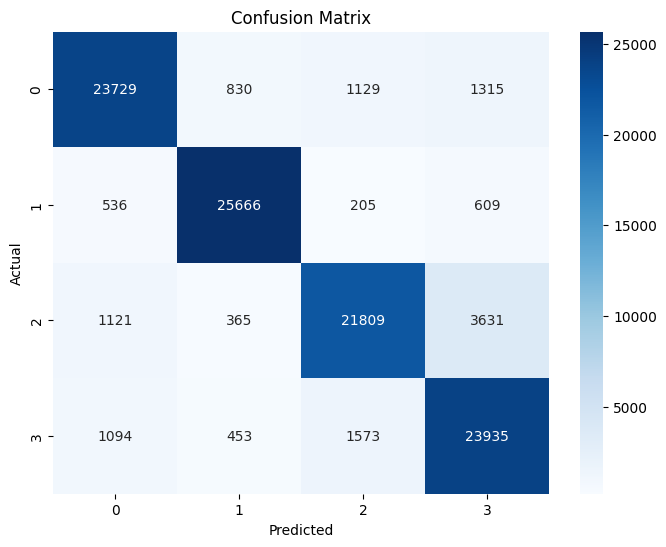

🧪 Test Evaluation:
Accuracy: 0.8485 | F1: 0.8486 | Precision: 0.8500 | Recall: 0.8486

Confusion Matrix:
[[1291   65   79   79]
 [  55 1390   14   51]
 [  88   27 1174  231]
 [  72   38  122 1304]]


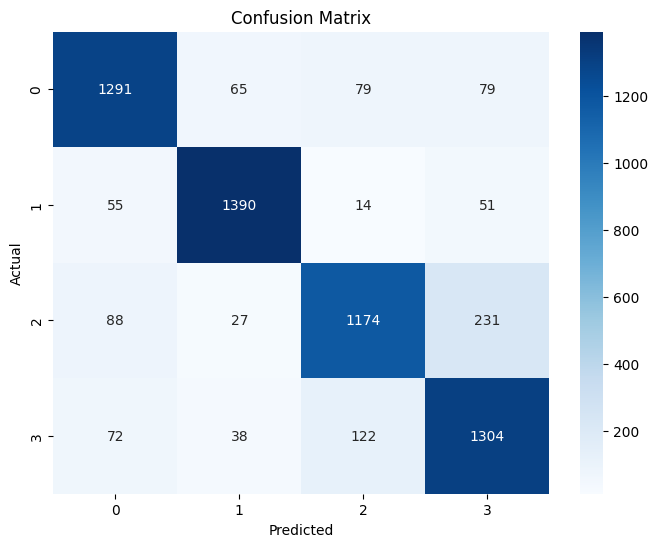

Epoch 10/30 - Avg Loss: 0.3677


Epoch 11/30: 100%|██████████| 211/211 [00:06<00:00, 32.57it/s]


🔍 Train Evaluation:
Accuracy: 0.8868 | F1: 0.8871 | Precision: 0.8884 | Recall: 0.8867

Confusion Matrix:
[[23804   696  1215  1288]
 [  537 25335   408   736]
 [  859   214 22677  3176]
 [ 1022   284  1794 23955]]


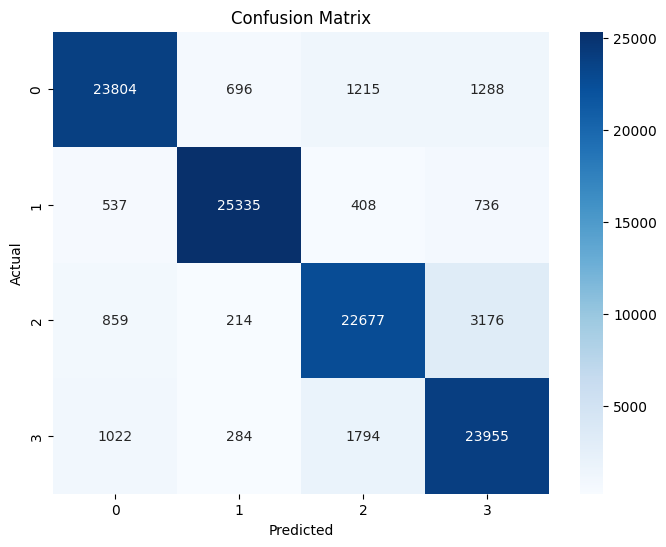

🧪 Test Evaluation:
Accuracy: 0.8451 | F1: 0.8456 | Precision: 0.8470 | Recall: 0.8452

Confusion Matrix:
[[1278   60   88   88]
 [  51 1364   34   61]
 [  77   23 1204  216]
 [  65   37  142 1292]]


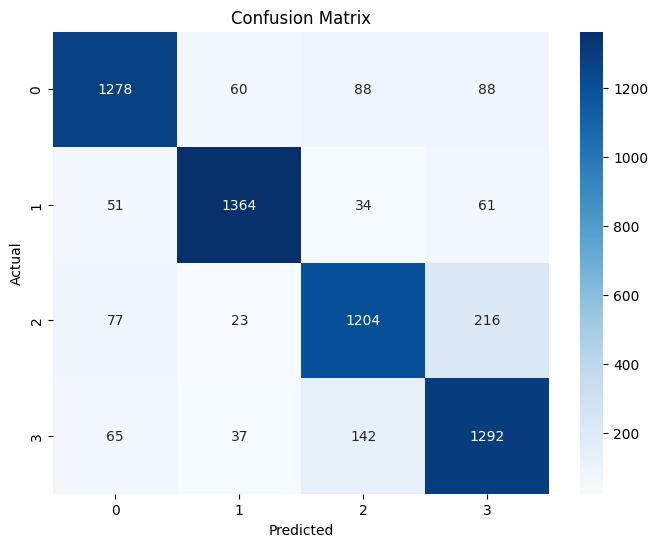

Epoch 11/30 - Avg Loss: 0.3596


Epoch 12/30: 100%|██████████| 211/211 [00:07<00:00, 28.75it/s]


🔍 Train Evaluation:
Accuracy: 0.8890 | F1: 0.8886 | Precision: 0.8890 | Recall: 0.8890

Confusion Matrix:
[[23948   900  1278   877]
 [  327 26140   228   321]
 [  814   398 23695  2019]
 [ 1208   583  3038 22226]]


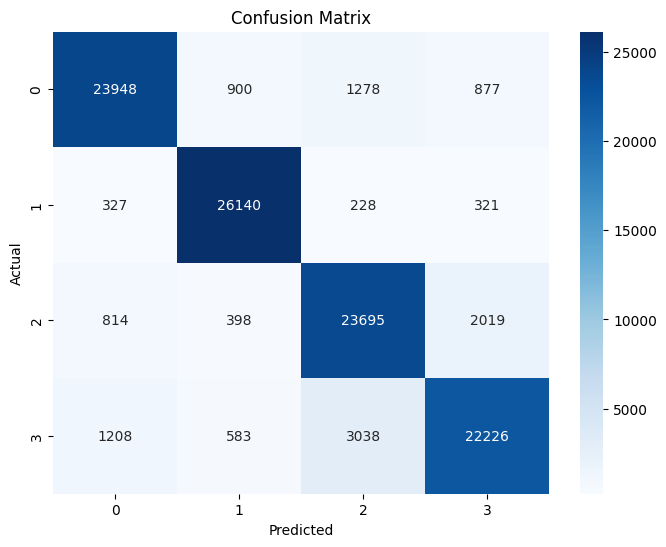

🧪 Test Evaluation:
Accuracy: 0.8492 | F1: 0.8489 | Precision: 0.8494 | Recall: 0.8495

Confusion Matrix:
[[1295   72   96   51]
 [  46 1413   19   32]
 [  81   35 1261  143]
 [  74   50  218 1194]]


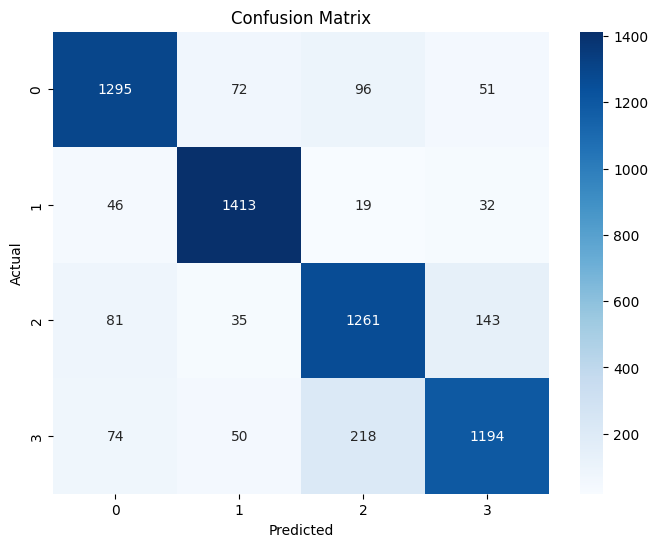

Epoch 12/30 - Avg Loss: 0.3428


Epoch 13/30: 100%|██████████| 211/211 [00:06<00:00, 30.57it/s]


🔍 Train Evaluation:
Accuracy: 0.8905 | F1: 0.8903 | Precision: 0.8924 | Recall: 0.8906

Confusion Matrix:
[[24038   753  1402   810]
 [  392 25993   397   234]
 [  745   279 24354  1548]
 [ 1090   530  3644 21791]]


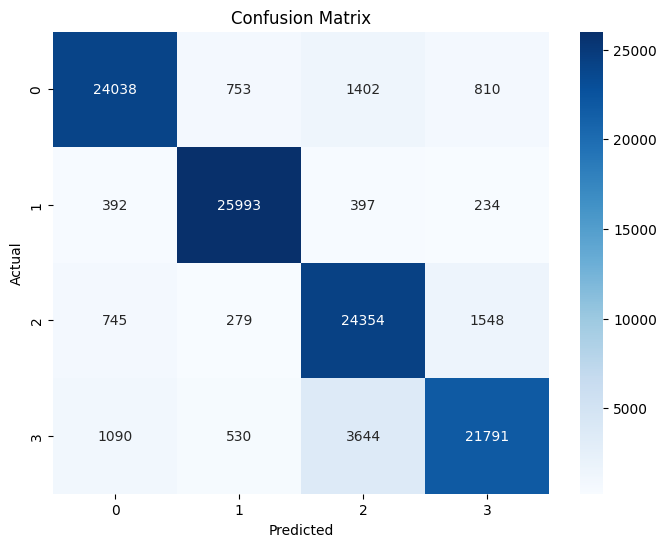

🧪 Test Evaluation:
Accuracy: 0.8438 | F1: 0.8437 | Precision: 0.8458 | Recall: 0.8441

Confusion Matrix:
[[1287   64  105   58]
 [  52 1399   33   26]
 [  71   27 1290  132]
 [  76   48  258 1154]]


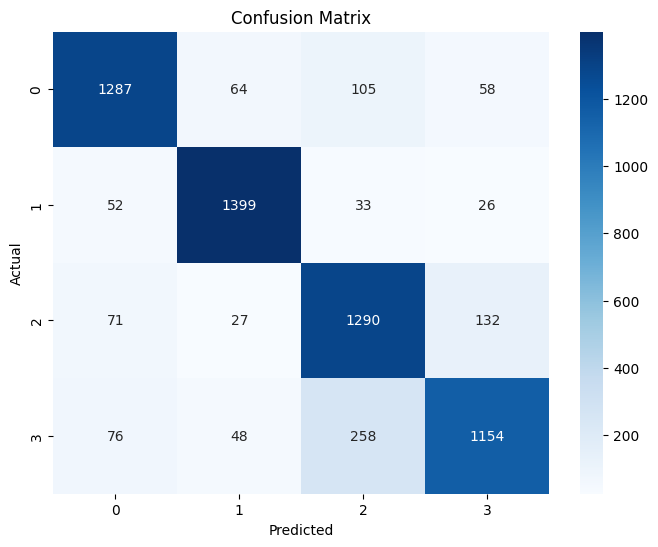

Epoch 13/30 - Avg Loss: 0.3324


Epoch 14/30: 100%|██████████| 211/211 [00:06<00:00, 33.22it/s]


🔍 Train Evaluation:
Accuracy: 0.8982 | F1: 0.8980 | Precision: 0.9016 | Recall: 0.8981

Confusion Matrix:
[[23577  1048   884  1494]
 [  155 26334   118   409]
 [  787   387 22085  3667]
 [  608   378  1057 25012]]


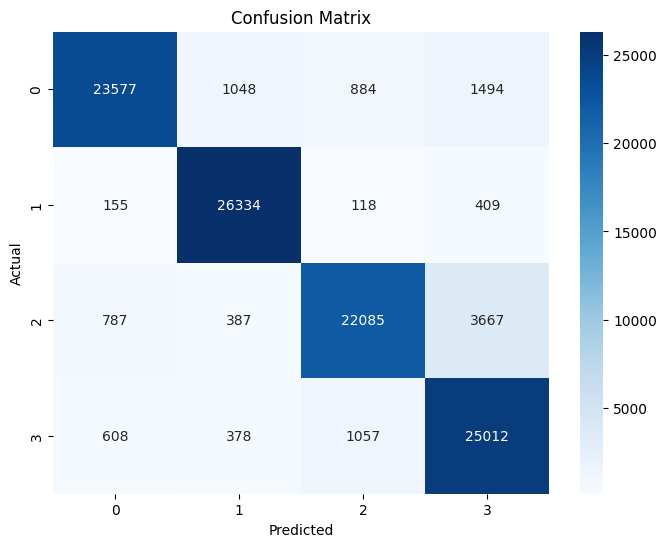

🧪 Test Evaluation:
Accuracy: 0.8487 | F1: 0.8485 | Precision: 0.8521 | Recall: 0.8488

Confusion Matrix:
[[1260   82   71  101]
 [  24 1422   14   50]
 [  78   34 1148  260]
 [  53   40  113 1330]]


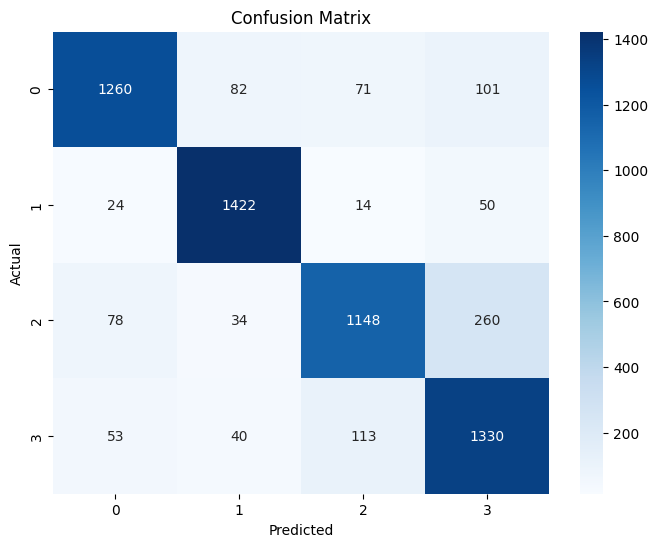

Epoch 14/30 - Avg Loss: 0.3190


Epoch 15/30: 100%|██████████| 211/211 [00:05<00:00, 35.28it/s]


🔍 Train Evaluation:
Accuracy: 0.9017 | F1: 0.9010 | Precision: 0.9014 | Recall: 0.9017

Confusion Matrix:
[[24764   839   865   535]
 [  325 26408   140   143]
 [ 1120   455 23590  1761]
 [ 1641   693  2100 22621]]


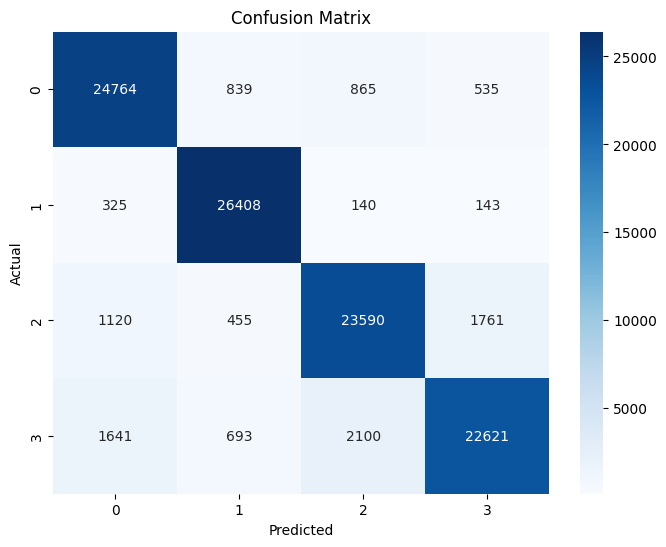

🧪 Test Evaluation:
Accuracy: 0.8500 | F1: 0.8492 | Precision: 0.8496 | Recall: 0.8504

Confusion Matrix:
[[1333   71   73   37]
 [  55 1420   18   17]
 [  94   41 1233  152]
 [ 102   63  189 1182]]


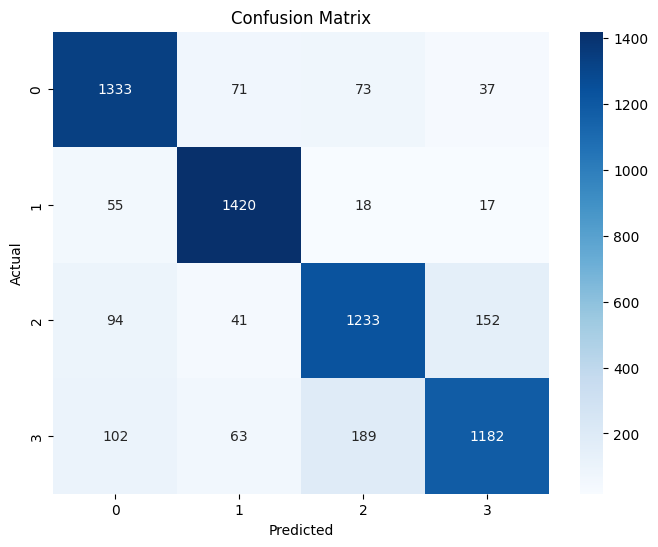

Epoch 15/30 - Avg Loss: 0.3075


Epoch 16/30: 100%|██████████| 211/211 [00:06<00:00, 34.81it/s]


🔍 Train Evaluation:
Accuracy: 0.9036 | F1: 0.9032 | Precision: 0.9057 | Recall: 0.9036

Confusion Matrix:
[[25229   510   588   676]
 [  696 25991    83   246]
 [ 1759   326 21995  2846]
 [ 1481   306   892 24376]]


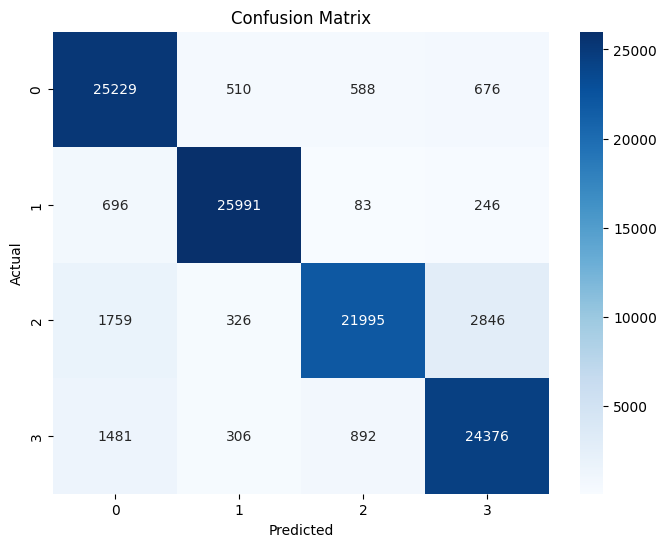

🧪 Test Evaluation:
Accuracy: 0.8480 | F1: 0.8475 | Precision: 0.8506 | Recall: 0.8482

Confusion Matrix:
[[1359   58   45   52]
 [  83 1388    7   32]
 [ 144   29 1135  212]
 [ 109   39  114 1274]]


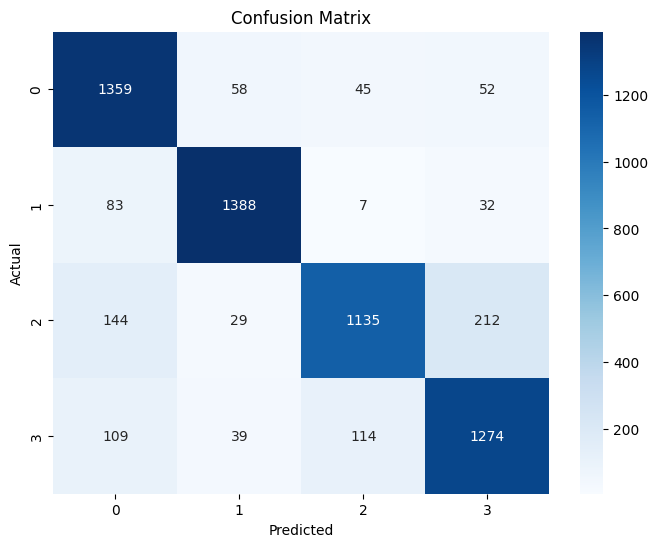

Epoch 16/30 - Avg Loss: 0.2903


Epoch 17/30: 100%|██████████| 211/211 [00:06<00:00, 32.34it/s]


🔍 Train Evaluation:
Accuracy: 0.9164 | F1: 0.9165 | Precision: 0.9190 | Recall: 0.9163

Confusion Matrix:
[[24118   630   946  1309]
 [  231 26254   159   372]
 [  540   243 23108  3035]
 [  516   207   841 25491]]


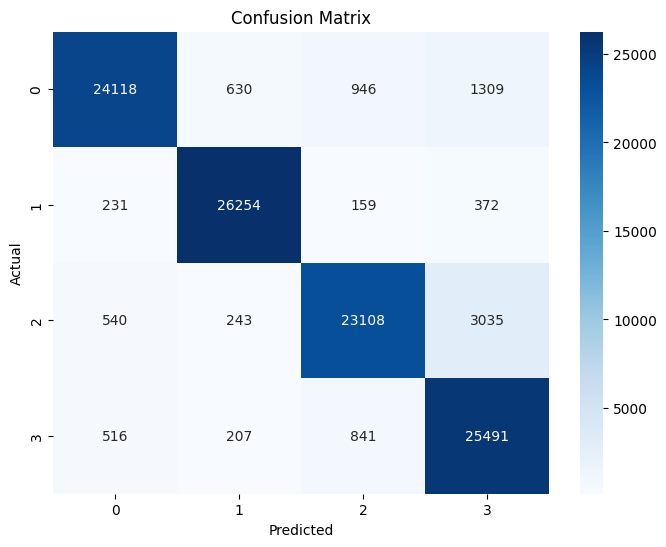

🧪 Test Evaluation:
Accuracy: 0.8493 | F1: 0.8499 | Precision: 0.8525 | Recall: 0.8494

Confusion Matrix:
[[1262   65   90   97]
 [  47 1384   20   59]
 [  58   29 1192  241]
 [  53   35  122 1326]]


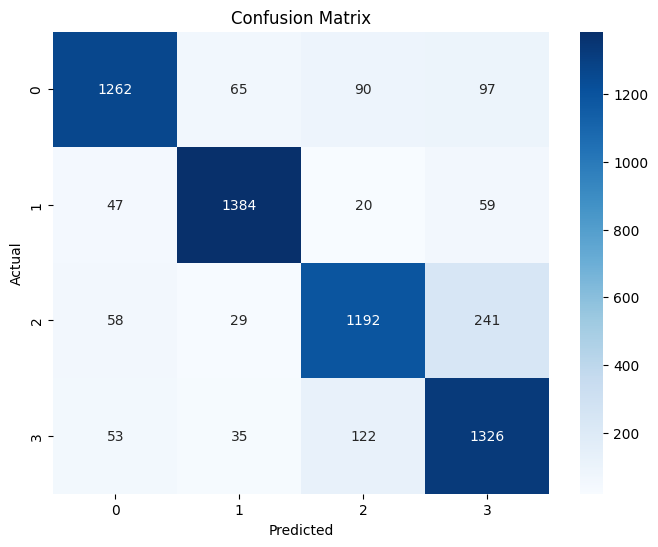

Epoch 17/30 - Avg Loss: 0.2735


Epoch 18/30: 100%|██████████| 211/211 [00:07<00:00, 29.47it/s]


🔍 Train Evaluation:
Accuracy: 0.9212 | F1: 0.9210 | Precision: 0.9217 | Recall: 0.9212

Confusion Matrix:
[[23972   970  1192   869]
 [  121 26629   133   133]
 [  431   375 24447  1673]
 [  577   470  1562 24446]]


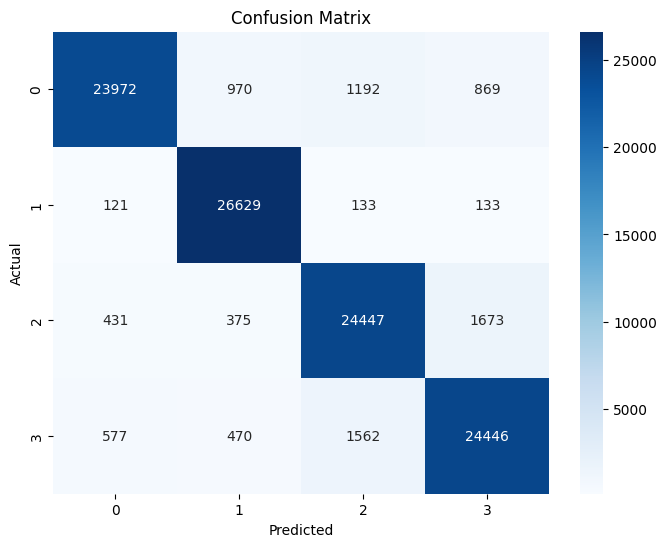

🧪 Test Evaluation:
Accuracy: 0.8487 | F1: 0.8484 | Precision: 0.8494 | Recall: 0.8490

Confusion Matrix:
[[1246   89  114   65]
 [  31 1433   22   24]
 [  55   42 1253  170]
 [  61   64  183 1228]]


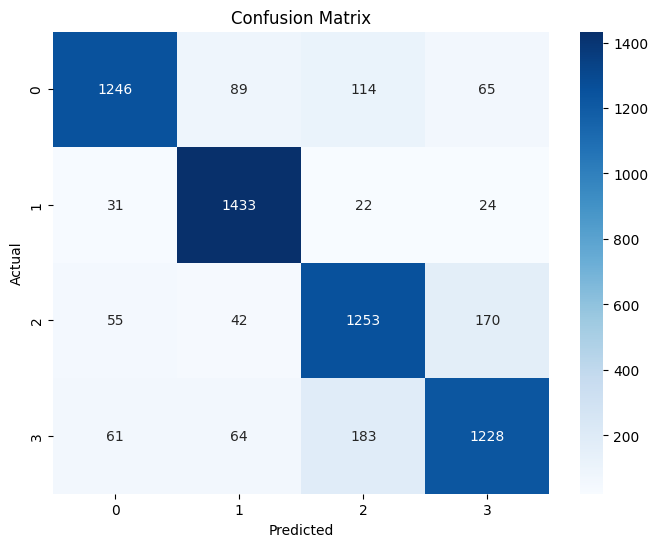

Epoch 18/30 - Avg Loss: 0.2579


Epoch 19/30: 100%|██████████| 211/211 [00:06<00:00, 30.37it/s]


🔍 Train Evaluation:
Accuracy: 0.9273 | F1: 0.9274 | Precision: 0.9294 | Recall: 0.9273

Confusion Matrix:
[[24825   443   660  1075]
 [  371 26084   150   411]
 [  729   169 23449  2579]
 [  518   105   639 25793]]


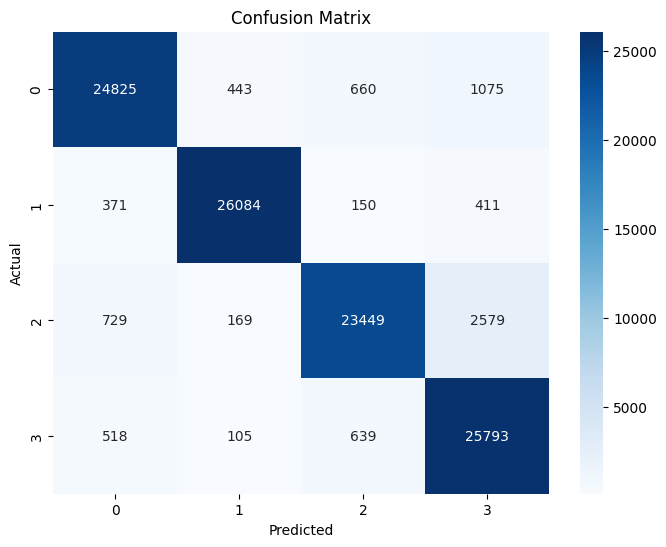

🧪 Test Evaluation:
Accuracy: 0.8472 | F1: 0.8476 | Precision: 0.8498 | Recall: 0.8473

Confusion Matrix:
[[1293   58   78   85]
 [  64 1358   26   62]
 [  89   23 1176  232]
 [  63   31  118 1324]]


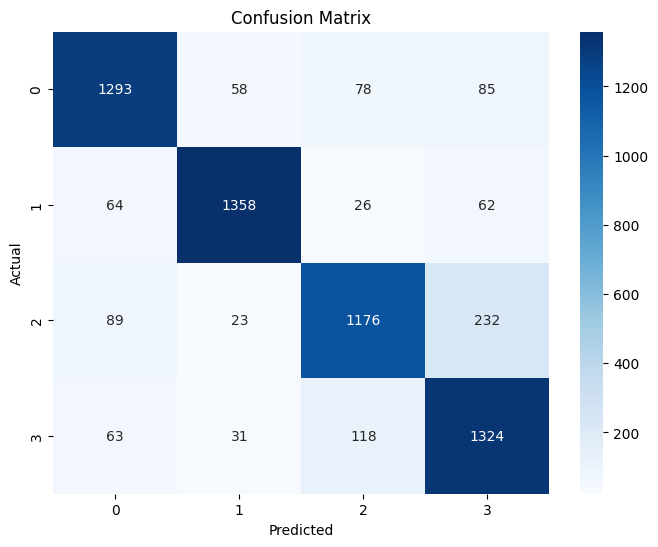

Epoch 19/30 - Avg Loss: 0.2429


Epoch 20/30: 100%|██████████| 211/211 [00:06<00:00, 34.84it/s]


🔍 Train Evaluation:
Accuracy: 0.9380 | F1: 0.9381 | Precision: 0.9386 | Recall: 0.9380

Confusion Matrix:
[[24724   393   898   988]
 [  259 26288   227   242]
 [  468   147 24897  1414]
 [  405    96  1160 25394]]


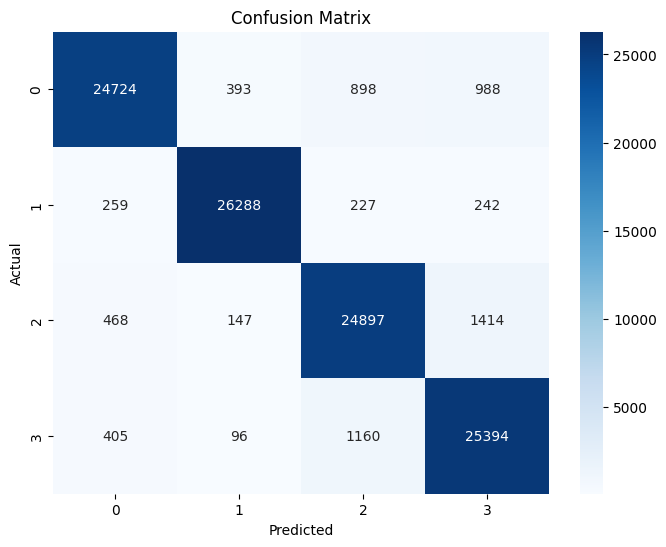

🧪 Test Evaluation:
Accuracy: 0.8456 | F1: 0.8463 | Precision: 0.8473 | Recall: 0.8457

Confusion Matrix:
[[1275   57  101   81]
 [  57 1364   41   48]
 [  69   28 1247  176]
 [  52   32  197 1255]]


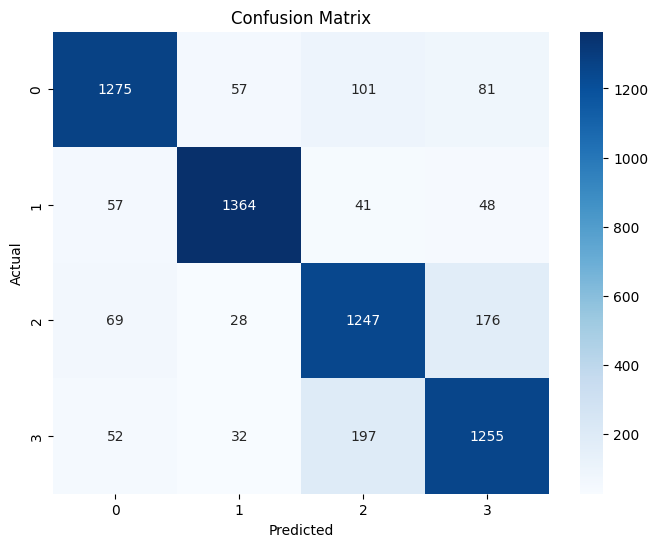

Epoch 20/30 - Avg Loss: 0.2297


Epoch 21/30: 100%|██████████| 211/211 [00:06<00:00, 35.12it/s]


🔍 Train Evaluation:
Accuracy: 0.9400 | F1: 0.9399 | Precision: 0.9400 | Recall: 0.9400

Confusion Matrix:
[[25503   440   646   414]
 [  312 26515   124    65]
 [  747   258 24699  1222]
 [  975   279   993 24808]]


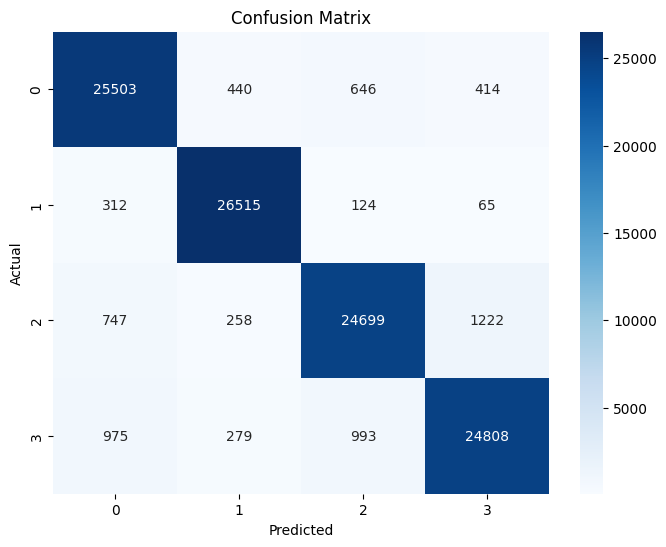

🧪 Test Evaluation:
Accuracy: 0.8451 | F1: 0.8447 | Precision: 0.8448 | Recall: 0.8454

Confusion Matrix:
[[1322   59   88   45]
 [  61 1400   24   25]
 [  99   34 1224  163]
 [  92   53  199 1192]]


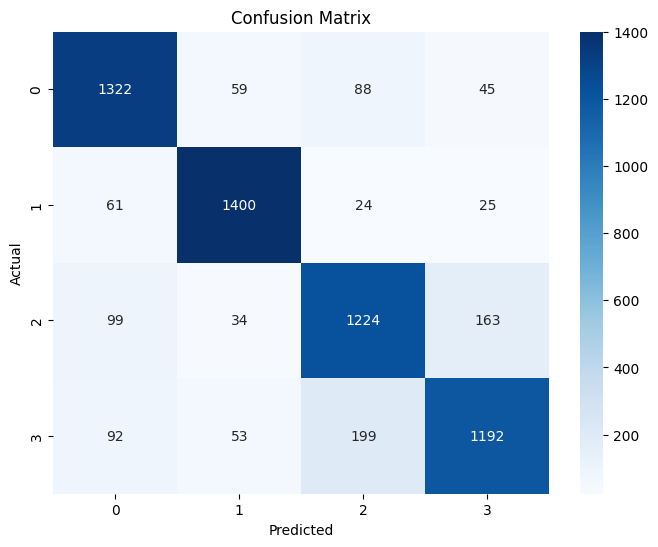

Epoch 21/30 - Avg Loss: 0.2112


Epoch 22/30: 100%|██████████| 211/211 [00:06<00:00, 32.38it/s]


🔍 Train Evaluation:
Accuracy: 0.9456 | F1: 0.9456 | Precision: 0.9463 | Recall: 0.9456

Confusion Matrix:
[[25515   297   559   632]
 [  446 26305    98   167]
 [  641   176 24368  1741]
 [  524   128   466 25937]]


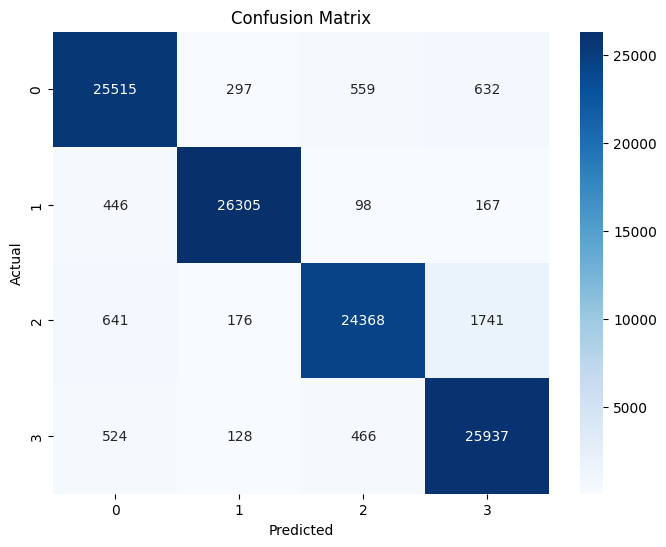

🧪 Test Evaluation:
Accuracy: 0.8457 | F1: 0.8458 | Precision: 0.8463 | Recall: 0.8459

Confusion Matrix:
[[1302   60   86   66]
 [  79 1370   20   41]
 [  90   31 1187  212]
 [  73   40  140 1283]]


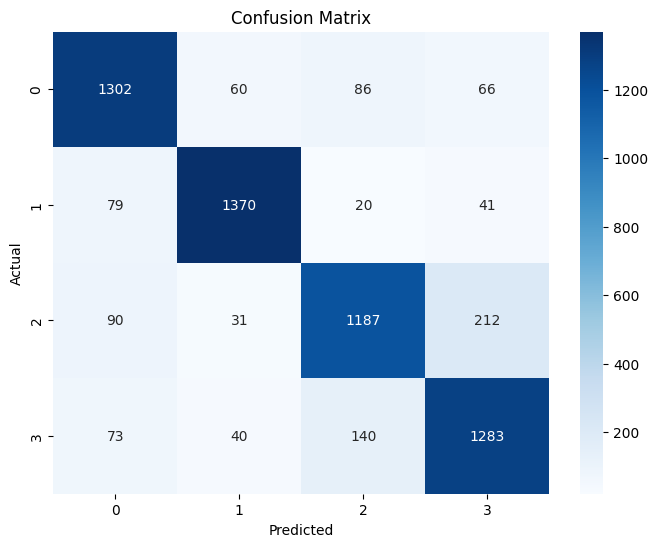

Epoch 22/30 - Avg Loss: 0.1949


Epoch 23/30: 100%|██████████| 211/211 [00:06<00:00, 33.62it/s]


🔍 Train Evaluation:
Accuracy: 0.9485 | F1: 0.9484 | Precision: 0.9498 | Recall: 0.9484

Confusion Matrix:
[[24630   543   843   987]
 [   99 26562    91   264]
 [  232   228 24894  1572]
 [  206    85   416 26348]]


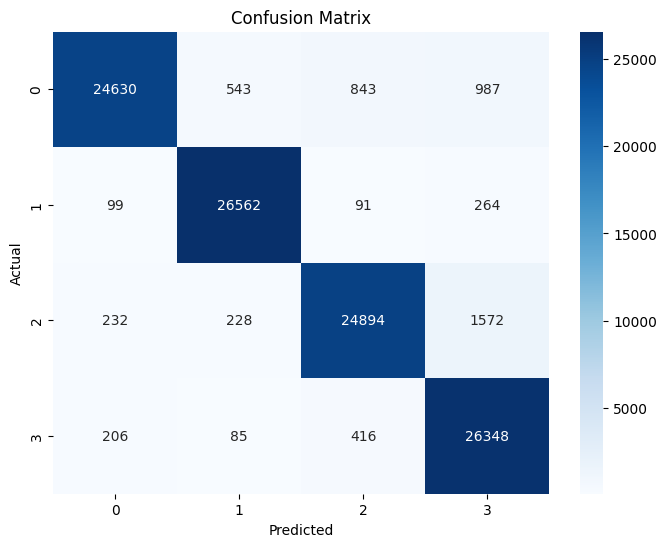

🧪 Test Evaluation:
Accuracy: 0.8429 | F1: 0.8434 | Precision: 0.8459 | Recall: 0.8430

Confusion Matrix:
[[1230   72  114   98]
 [  33 1394   21   62]
 [  60   33 1200  227]
 [  49   36  150 1301]]


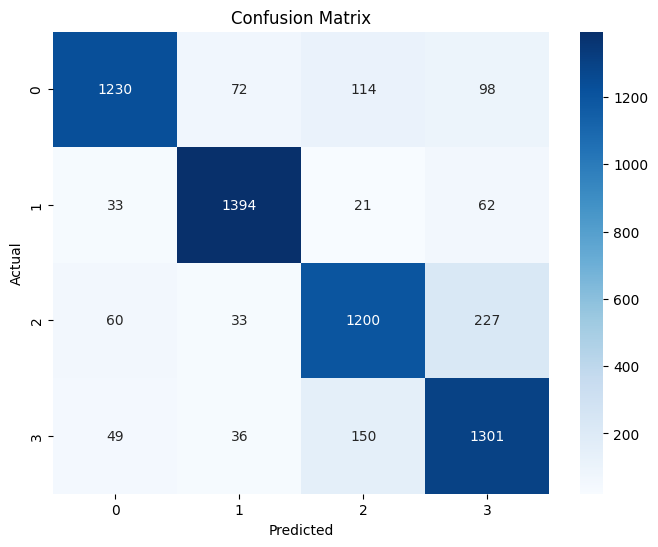

Epoch 23/30 - Avg Loss: 0.1823


Epoch 24/30: 100%|██████████| 211/211 [00:07<00:00, 30.01it/s]


🔍 Train Evaluation:
Accuracy: 0.9591 | F1: 0.9591 | Precision: 0.9592 | Recall: 0.9591

Confusion Matrix:
[[25623   257   675   448]
 [  221 26532   122   141]
 [  411   161 25425   929]
 [  387    54   609 26005]]


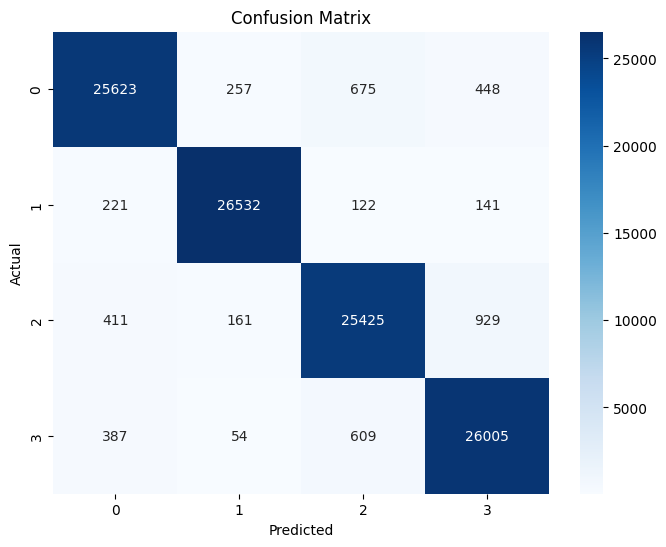

🧪 Test Evaluation:
Accuracy: 0.8436 | F1: 0.8441 | Precision: 0.8446 | Recall: 0.8438

Confusion Matrix:
[[1284   55  108   67]
 [  60 1369   27   54]
 [  81   31 1236  172]
 [  70   30  196 1240]]


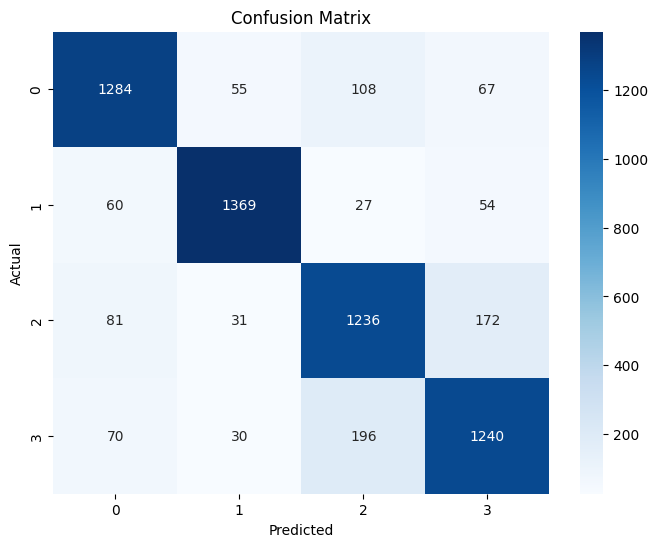

Epoch 24/30 - Avg Loss: 0.1629


Epoch 25/30: 100%|██████████| 211/211 [00:06<00:00, 32.03it/s]


🔍 Train Evaluation:
Accuracy: 0.9586 | F1: 0.9585 | Precision: 0.9587 | Recall: 0.9586

Confusion Matrix:
[[25504   447   795   257]
 [   88 26822    69    37]
 [  247   206 25832   641]
 [  593   226   865 25371]]


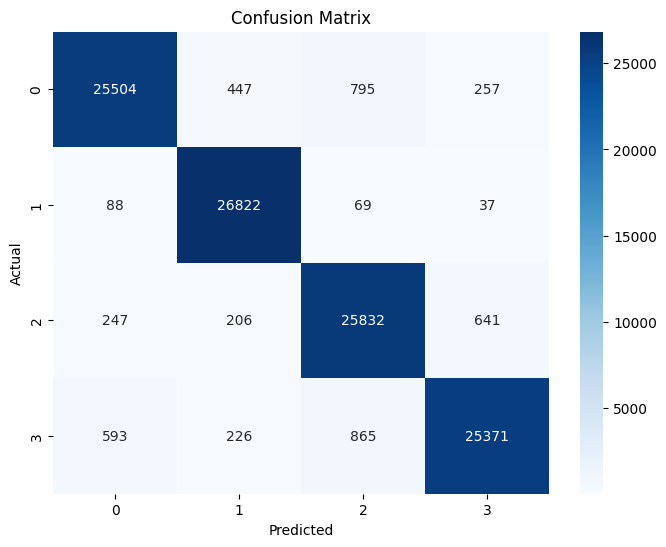

🧪 Test Evaluation:
Accuracy: 0.8401 | F1: 0.8399 | Precision: 0.8412 | Recall: 0.8405

Confusion Matrix:
[[1274   74  118   48]
 [  47 1411   26   26]
 [  70   37 1261  152]
 [  77   59  238 1162]]


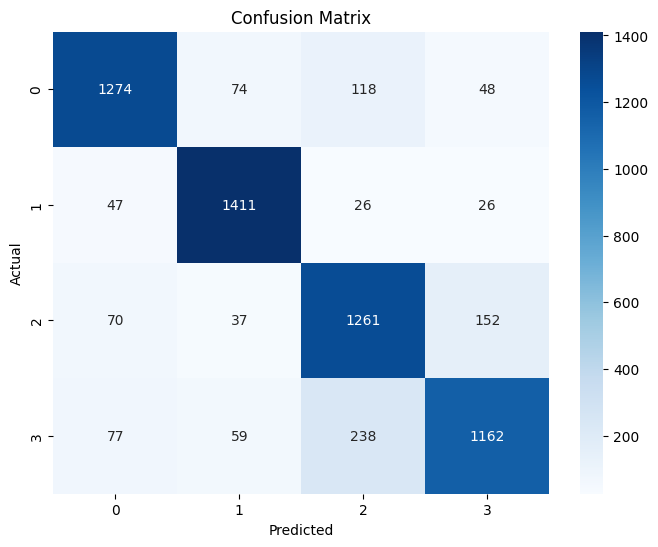

Epoch 25/30 - Avg Loss: 0.1491


Epoch 26/30: 100%|██████████| 211/211 [00:06<00:00, 32.28it/s]


🔍 Train Evaluation:
Accuracy: 0.9650 | F1: 0.9649 | Precision: 0.9650 | Recall: 0.9650

Confusion Matrix:
[[25611   491   612   289]
 [   67 26859    70    20]
 [  222   213 25871   620]
 [  382   218   581 25874]]


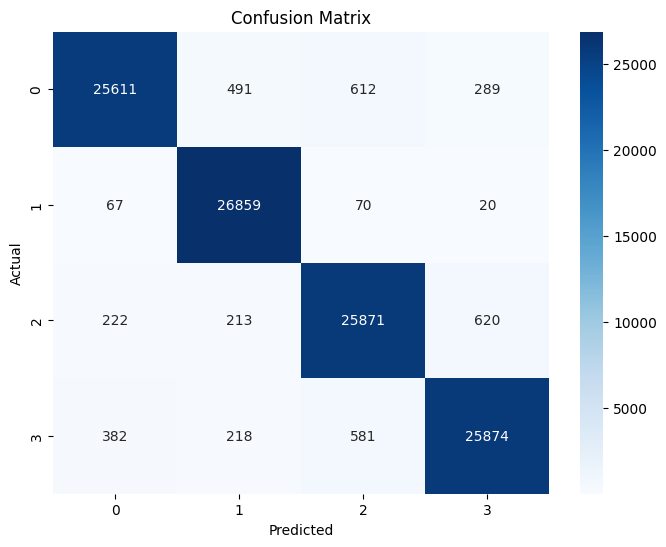

🧪 Test Evaluation:
Accuracy: 0.8378 | F1: 0.8375 | Precision: 0.8380 | Recall: 0.8381

Confusion Matrix:
[[1257   83  114   60]
 [  52 1404   22   32]
 [  76   39 1245  160]
 [  78   62  208 1188]]


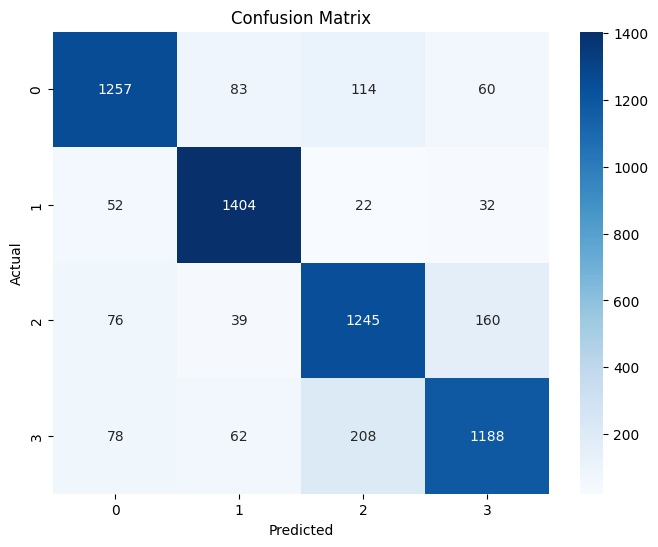

Epoch 26/30 - Avg Loss: 0.1358


Epoch 27/30: 100%|██████████| 211/211 [00:06<00:00, 32.27it/s]


🔍 Train Evaluation:
Accuracy: 0.9709 | F1: 0.9708 | Precision: 0.9708 | Recall: 0.9709

Confusion Matrix:
[[26131   266   410   196]
 [  108 26821    63    24]
 [  306   166 25980   474]
 [  494   129   511 25921]]


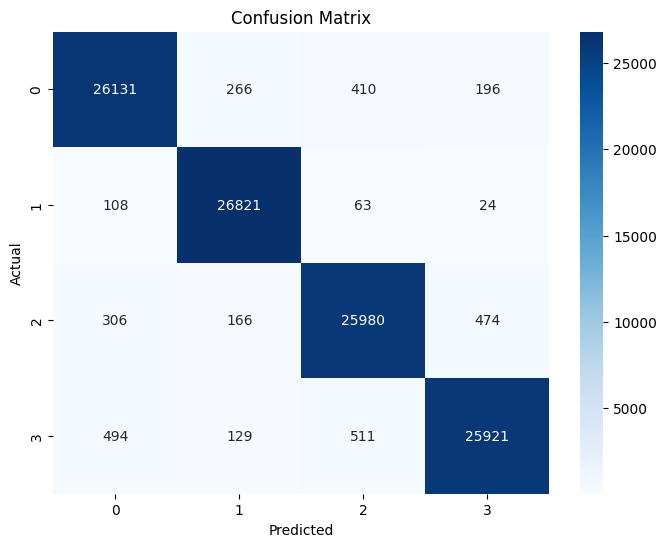

🧪 Test Evaluation:
Accuracy: 0.8410 | F1: 0.8406 | Precision: 0.8409 | Recall: 0.8413

Confusion Matrix:
[[1288   72  100   54]
 [  54 1406   22   28]
 [  84   37 1243  156]
 [  87   58  215 1176]]


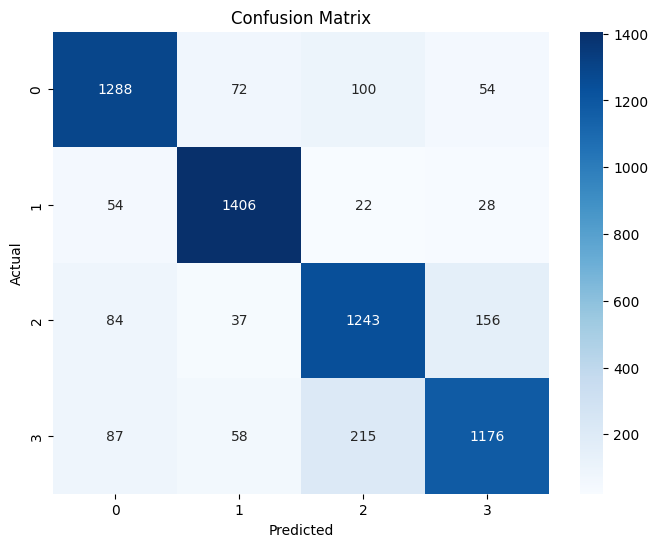

Epoch 27/30 - Avg Loss: 0.1212


Epoch 28/30: 100%|██████████| 211/211 [00:06<00:00, 34.03it/s]


🔍 Train Evaluation:
Accuracy: 0.9755 | F1: 0.9754 | Precision: 0.9755 | Recall: 0.9755

Confusion Matrix:
[[26069   289   354   291]
 [   51 26907    32    26]
 [  243   212 25895   576]
 [  213    65   297 26480]]


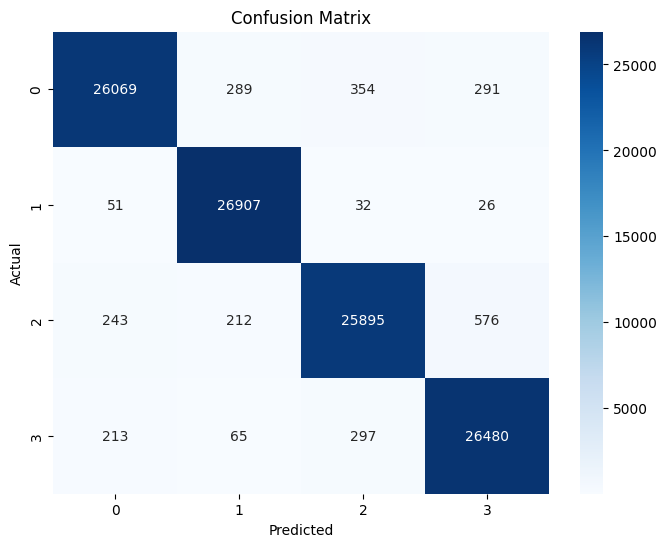

🧪 Test Evaluation:
Accuracy: 0.8360 | F1: 0.8360 | Precision: 0.8358 | Recall: 0.8363

Confusion Matrix:
[[1272   72   99   71]
 [  53 1391   27   39]
 [  86   36 1206  192]
 [  78   52  192 1214]]


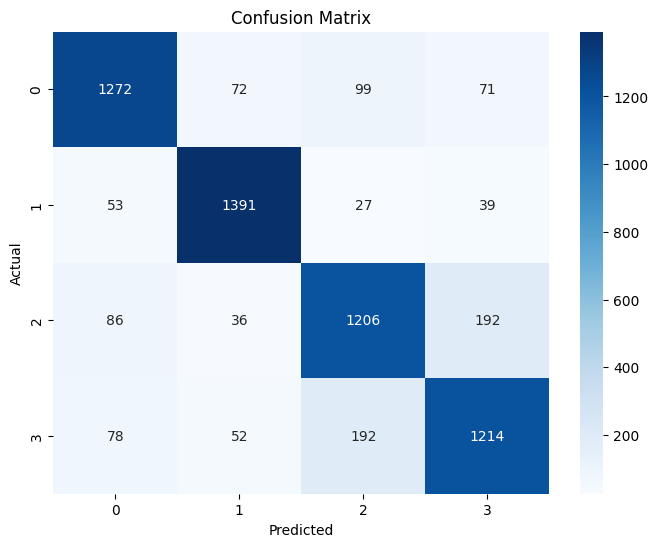

Epoch 28/30 - Avg Loss: 0.1138


Epoch 29/30: 100%|██████████| 211/211 [00:06<00:00, 33.99it/s]


🔍 Train Evaluation:
Accuracy: 0.9762 | F1: 0.9762 | Precision: 0.9762 | Recall: 0.9762

Confusion Matrix:
[[26316   171   319   197]
 [   75 26868    56    17]
 [  292   164 26116   354]
 [  311   125   486 26133]]


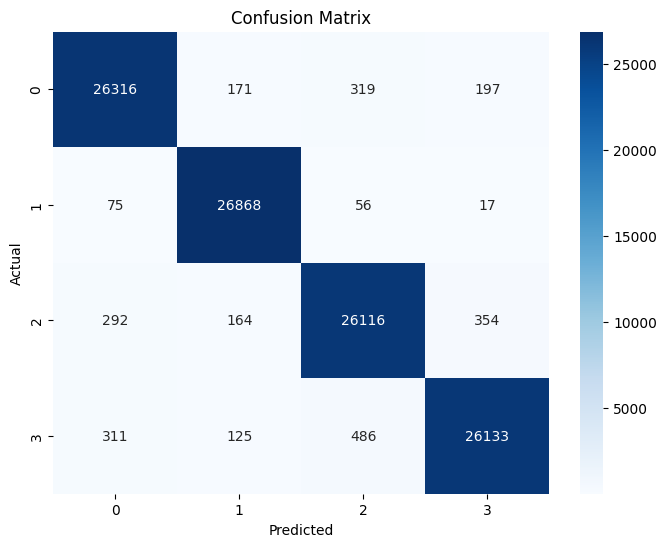

🧪 Test Evaluation:
Accuracy: 0.8342 | F1: 0.8341 | Precision: 0.8341 | Recall: 0.8345

Confusion Matrix:
[[1287   68   96   63]
 [  60 1381   29   40]
 [  92   36 1226  166]
 [  79   61  218 1178]]


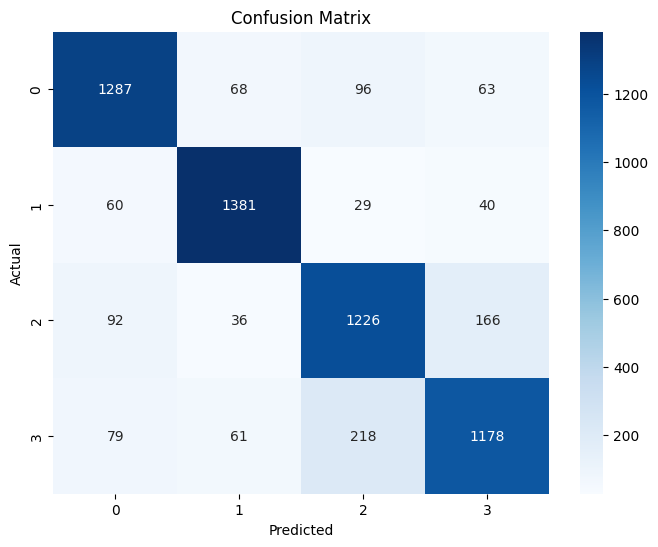

Epoch 29/30 - Avg Loss: 0.1018


Epoch 30/30: 100%|██████████| 211/211 [00:07<00:00, 28.51it/s]


🔍 Train Evaluation:
Accuracy: 0.9672 | F1: 0.9669 | Precision: 0.9682 | Recall: 0.9671

Confusion Matrix:
[[26466   128    91   318]
 [  129 26809    25    53]
 [ 1019   201 24357  1349]
 [  140    29    62 26824]]


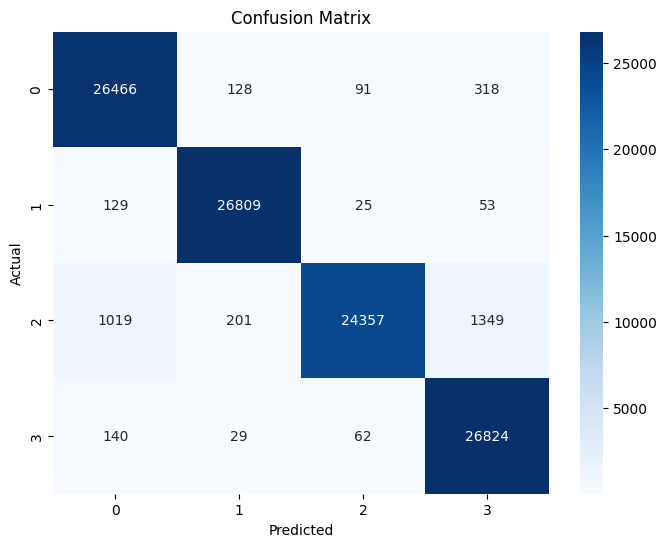

🧪 Test Evaluation:
Accuracy: 0.8363 | F1: 0.8358 | Precision: 0.8390 | Recall: 0.8365

Confusion Matrix:
[[1310   59   59   86]
 [  74 1379   12   45]
 [ 138   39 1099  244]
 [  85   40  114 1297]]


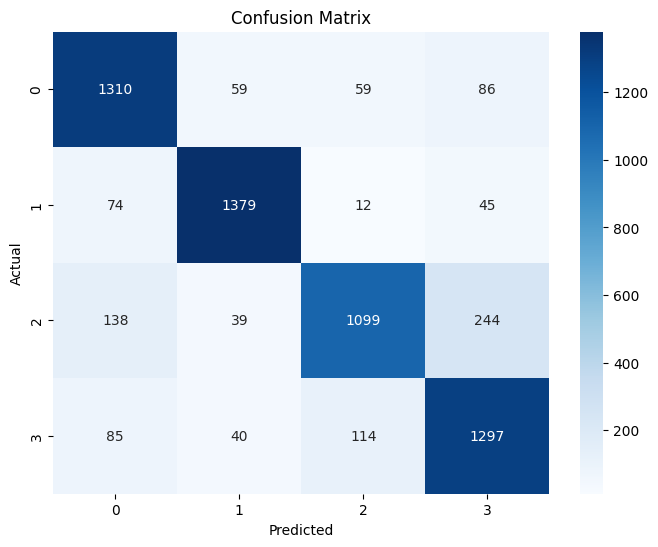

Epoch 30/30 - Avg Loss: 0.0942
✔ Saved classifier_skipgram.pt


In [ ]:
"""
classification.py
-----------------

Trains a GRU-based classifier on the AG News dataset using pretrained embeddings
from SVD, CBOW, and Skip-gram (Assignment 3). Creates separate preprocessed files
for static embeddings to avoid vocabulary conflicts with ELMo.

Usage:
    python classification.py
"""

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import spacy
from tqdm import tqdm
import pickle
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load spaCy
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

# Hyperparameters
maxSeqLen = 50
batchSize = 512
hiddenSize = 128
numClasses = 4
numEpochs = 30
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- AG News Dataset ---
class AGNewsDataset(Dataset):
    def __init__(self, filePath, wordToIndex, subsetFraction=1.0):
        if filePath.endswith('.csv'):
            df = pd.read_csv(filePath).dropna(subset=["Description"])
            df["input_ids"] = df["Description"].apply(lambda x: tokenize_and_encode(x, wordToIndex))
            df["label"] = df["Class Index"] - 1
        else:
            df = pd.read_pickle(filePath)
            df["label"] = df["label"] - 1  # Ensure 0-based labels

        if subsetFraction < 1.0:
            subsetSize = int(len(df) * subsetFraction)
            df = df.sample(n=subsetSize, random_state=42).reset_index(drop=True)

        self.inputs = df["input_ids"].tolist()
        self.labels = df["label"].tolist()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx]), torch.tensor(self.labels[idx])

def tokenize_and_encode(text, wordToIndex):
    tokens = [t.lemma_.lower() for t in nlp(text) if t.is_alpha]
    idxs = [wordToIndex.get(tok, wordToIndex["<UNK>"]) for tok in tokens]
    return idxs[:maxSeqLen] + [wordToIndex["<PAD>"]] * max(0, maxSeqLen - len(idxs))

def preprocess_ag_news(csv_path, out_path, wordToIndex):
    df = pd.read_csv(csv_path).dropna(subset=["Description"])
    df["input_ids"] = df["Description"].apply(lambda x: tokenize_and_encode(x, wordToIndex))
    df["label"] = df["Class Index"]
    df[["input_ids", "label"]].to_pickle(out_path)
    print(f"✔ Saved {out_path} with {len(df)} examples")

# --- GRU Classifier ---
class GRUClassifier(nn.Module):
    def __init__(self, embeddingLayer, hiddenSize=128, numClasses=4):
        super().__init__()
        self.embedding = embeddingLayer
        self.gru = nn.GRU(
            embeddingLayer.embedding_dim, hiddenSize,
            batch_first=True, bidirectional=True
        )
        self.classifier = nn.Sequential(
            nn.Linear(hiddenSize * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, numClasses)
        )

    def forward(self, x):
        embedded = self.embedding(x)
        _, h = self.gru(embedded)
        h_cat = torch.cat([h[0], h[1]], dim=1)
        return self.classifier(h_cat)

# --- Evaluation Function ---
def evaluate_model(classifier, dataLoader, device):
    classifier.eval()
    allPreds, allLabels = [], []

    with torch.no_grad():
        for tokens, labels in dataLoader:
            tokens, labels = tokens.to(device), labels.to(device)
            logits = classifier(tokens)
            preds = torch.argmax(logits, dim=1)
            allPreds.extend(preds.cpu().tolist())
            allLabels.extend(labels.cpu().tolist())

    acc = accuracy_score(allLabels, allPreds)
    f1 = f1_score(allLabels, allPreds, average='macro')
    precision = precision_score(allLabels, allPreds, average='macro')
    recall = recall_score(allLabels, allPreds, average='macro')
    cm = confusion_matrix(allLabels, allPreds, labels=[0, 1, 2, 3])

    print(f"Accuracy: {acc:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
    print("\nConfusion Matrix:")
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return acc, f1, precision, recall, cm

# --- Training Function ---
def train_classifier(embeddingType, embeddingMatrix, wordToIndex, trainLoader, testLoader):
    embeddingLayer = nn.Embedding.from_pretrained(embeddingMatrix, freeze=True).to(device)
    classifier = GRUClassifier(embeddingLayer, hiddenSize=hiddenSize, numClasses=numClasses).to(device)
    optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    print(f"Training classifier with {embeddingType.upper()} embeddings...")
    for epoch in range(numEpochs):
        classifier.train()
        totalLoss = 0
        for tokens, labels in tqdm(trainLoader, desc=f"Epoch {epoch+1}/{numEpochs}"):
            tokens, labels = tokens.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = classifier(tokens)
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()
            totalLoss += loss.item()

        avgLoss = totalLoss / len(trainLoader)
        print("🔍 Train Evaluation:")
        trainMetrics = evaluate_model(classifier, trainLoader, device)
        print("🧪 Test Evaluation:")
        testMetrics = evaluate_model(classifier, testLoader, device)
        print("=" * 60)
        print(f"Epoch {epoch+1}/{numEpochs} - Avg Loss: {avgLoss:.4f}")

    # print("🔍 Train Evaluation:")
    # trainMetrics = evaluate_model(classifier, trainLoader, device)
    # print("🧪 Test Evaluation:")
    # testMetrics = evaluate_model(classifier, testLoader, device)
    print("=" * 60)

    savePath = f"classifier_{embeddingType}.pt"
    torch.save({
        'model_state_dict': classifier.state_dict(),
        'wordToIndex': wordToIndex,
        'embeddingMatrix': embeddingMatrix
    }, savePath)
    print(f"✔ Saved {savePath}")

    return trainMetrics, testMetrics

# --- Main Function ---
def main():
    embeddingFiles = {
        'svd': 'svd.pt',
        'cbow': 'cbow.pt',
        'skipgram': 'skipgram.pt'
    }

    trainCsvPath = "train.csv"
    testCsvPath = "test.csv"
    trainPklPath = "train_preprocessed_static.pkl"
    testPklPath = "test_preprocessed_static.pkl"

    print(f"Using device: {device}")

    for embeddingType, embeddingPath in embeddingFiles.items():
        embeddingData = torch.load(embeddingPath)
        if embeddingType == 'svd':
            embeddingMatrix = embeddingData['embeddings']
        else:
            embeddingMatrix = embeddingData['inEmbedding']
        wordToIndex = embeddingData['wordToIdx']

        # Add <PAD> and <UNK> if missing
        if '<PAD>' not in wordToIndex:
            wordToIndex['<PAD>'] = len(wordToIndex)
            embeddingMatrix = torch.cat([embeddingMatrix, torch.zeros(1, embeddingMatrix.shape[1])])
        if '<UNK>' not in wordToIndex:
            wordToIndex['<UNK>'] = len(wordToIndex)
            embeddingMatrix = torch.cat([embeddingMatrix, torch.zeros(1, embeddingMatrix.shape[1])])

        # Preprocess AG News for this embedding type
        if not os.path.exists(trainPklPath):
            preprocess_ag_news(trainCsvPath, trainPklPath, wordToIndex)
        if not os.path.exists(testPklPath):
            preprocess_ag_news(testCsvPath, testPklPath, wordToIndex)

        trainData = AGNewsDataset(trainPklPath, wordToIndex, subsetFraction=0.9)
        testData = AGNewsDataset(testPklPath, wordToIndex, subsetFraction=0.8)
        trainLoader = DataLoader(trainData, batch_size=batchSize, shuffle=True)
        testLoader = DataLoader(testData, batch_size=batchSize)

        train_classifier(embeddingType, embeddingMatrix, wordToIndex, trainLoader, testLoader)

if __name__ == "__main__":
    main()

**Inference Block**

*Below code is use to check inference, to which class does a description belong to, it predicts the probabilities for each description being in one class*

Inference.py (Final)

In [ ]:
"""
inference.py
------------

Performs inference on AG News descriptions using trained classifiers from
ELMo-based models (trainable, frozen, learnable_fn) and static embeddings
(SVD, CBOW, Skip-gram).

Usage:
    python inference.py <model_path> <description>
    OR run interactively with hardcoded values below.
"""

import torch
import torch.nn as nn
import spacy
import pickle
import sys

# Load spaCy
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

# Hyperparameters
maxSeqLen = 50

# --- Models ---
class ELMoBiLSTM(nn.Module):
    def __init__(self, embeddingLayer, hiddenSize=512, numLayers=2, dropout=0.33):
        super().__init__()
        self.embedding = embeddingLayer
        self.biLSTM = nn.LSTM(
            input_size=embeddingLayer.embedding_dim,
            hidden_size=hiddenSize,
            num_layers=numLayers,
            dropout=dropout,
            bidirectional=True,
            batch_first=True
        )
        self.outputHead = nn.Linear(hiddenSize * 2, embeddingLayer.num_embeddings)

    def forward(self, inputSeq):
        embedded = self.embedding(inputSeq)
        lstmOut, _ = self.biLSTM(embedded)
        output = self.outputHead(lstmOut)
        return output, lstmOut

class ELMoLayerCombiner(nn.Module):
    def __init__(self, method="trainable", embeddingDim=300, lstmDim=512, outputDim=None):
        super().__init__()
        self.method = method
        if method == "trainable":
            self.lambdas = nn.Parameter(torch.ones(3))
        elif method == "frozen":
            self.register_buffer("lambdas", torch.tensor([0.3, 0.3, 0.4]))
        elif method == "learnable_fn":
            inputDim = embeddingDim + 2 * lstmDim * 2
            outDim = outputDim if outputDim else inputDim
            self.projection = nn.Sequential(
                nn.Linear(inputDim, 512),
                nn.ReLU(),
                nn.Linear(512, outDim)
            )

    def forward(self, e0, e1, e2):
        if self.method in ["trainable", "frozen"]:
            weights = torch.softmax(self.lambdas, dim=0)
            if e0.shape[-1] != e1.shape[-1]:
                e0 = nn.functional.pad(e0, (0, e1.shape[-1] - e0.shape[-1]))
            return weights[0] * e0 + weights[1] * e1 + weights[2] * e2
        elif self.method == "learnable_fn":
            return self.projection(torch.cat([e0, e1, e2], dim=-1))

class GRUClassifier(nn.Module):
    def __init__(self, inputDim, hiddenSize=128, numClasses=4):
        super().__init__()
        self.gru = nn.GRU(inputDim, hiddenSize, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(hiddenSize * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, numClasses)
        )

    def forward(self, x):
        _, h = self.gru(x)
        h_cat = torch.cat([h[0], h[1]], dim=1)
        return self.classifier(h_cat)

class GRUClassifierStatic(nn.Module):
    def __init__(self, embeddingLayer, hiddenSize=128, numClasses=4):
        super().__init__()
        self.embedding = embeddingLayer
        self.gru = nn.GRU(
            embeddingLayer.embedding_dim, hiddenSize,
            batch_first=True, bidirectional=True
        )
        self.classifier = nn.Sequential(
            nn.Linear(hiddenSize * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, numClasses)
        )

    def forward(self, x):
        embedded = self.embedding(x)
        _, h = self.gru(embedded)
        h_cat = torch.cat([h[0], h[1]], dim=1)
        return self.classifier(h_cat)

# --- Helper Functions ---
def tokenize_and_encode(text, wordToIndex):
    tokens = [t.lemma_.lower() for t in nlp(text) if t.is_alpha]
    idxs = [wordToIndex.get(tok, wordToIndex["<UNK>"]) for tok in tokens]
    return idxs[:maxSeqLen] + [wordToIndex["<PAD>"]] * max(0, maxSeqLen - len(idxs))

def predict(savedModelPath, description):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    modelData = torch.load(savedModelPath, map_location=device)

    # Determine model type from filename
    modelName = savedModelPath.split("_")[1].split(".")[0].lower()
    isStatic = modelName in ["svd", "cbow", "skipgram"]

    if isStatic:
        # Static Embedding Model
        wordToIndex = modelData['wordToIndex']
        embeddingMatrix = modelData['embeddingMatrix']
        embeddingLayer = nn.Embedding.from_pretrained(embeddingMatrix, freeze=True).to(device)
        classifier = GRUClassifierStatic(embeddingLayer).to(device)
        classifier.load_state_dict(modelData['model_state_dict'])
        classifier.eval()

        input_ids = torch.tensor(tokenize_and_encode(description, wordToIndex)).unsqueeze(0).to(device)
        with torch.no_grad():
            logits = classifier(input_ids)
            probs = torch.softmax(logits, dim=1).squeeze().cpu().tolist()

    else:
        # ELMo-based Model
        wordToIndex = modelData['wordToIndex']
        embeddingTensor = modelData['embeddingTensor']
        method = modelData['method']

        embeddingLayer = nn.Embedding.from_pretrained(embeddingTensor, freeze=True).to(device)
        elmoModel = ELMoBiLSTM(embeddingLayer).to(device)
        elmoModel.load_state_dict(torch.load("bilstm.pt", map_location=device))
        elmoModel.eval()

        combiner = ELMoLayerCombiner(method=method).to(device)
        if 'combiner_state_dict' in modelData:
            combiner.load_state_dict(modelData['combiner_state_dict'])
        combiner.eval()

        sample_input = torch.tensor(tokenize_and_encode("sample text", wordToIndex)).unsqueeze(0).to(device)
        with torch.no_grad():
            e0 = elmoModel.embedding(sample_input)
            _, lstmOut = elmoModel(sample_input)
            final = combiner(e0, lstmOut, lstmOut)
        embedDim = final.shape[-1]

        classifier = GRUClassifier(inputDim=embedDim).to(device)
        classifier.load_state_dict(modelData['classifier_state_dict'])
        classifier.eval()

        input_ids = torch.tensor(tokenize_and_encode(description, wordToIndex)).unsqueeze(0).to(device)
        with torch.no_grad():
            e0 = elmoModel.embedding(input_ids)
            _, lstmOut = elmoModel(input_ids)
            contextual = combiner(e0, lstmOut, lstmOut)
            logits = classifier(contextual)
            probs = torch.softmax(logits, dim=1).squeeze().cpu().tolist()

    # Print probabilities
    for i, prob in enumerate(probs, 1):
        print(f"class-{i}: {prob:.4f}")

# --- Main Execution ---
if __name__ == "__main__":
    print(f"Command-line arguments: {sys.argv}")
    if len(sys.argv) >= 3 and sys.argv[1] != "-f":  # Ignore Jupyter's -f argument
        savedModelPath = sys.argv[1]
        description = sys.argv[2]
    else:
        # Hardcoded values for testing
        savedModelPath = "classifier_frozen.pt"  # Replace as needed
        description = "India will become largest economy by GDP!"

    print(f"Predicting with model: {savedModelPath}")
    print(f"Description: {description}")
    predict(savedModelPath, description)

Command-line arguments: ['/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py', '-f', '/root/.local/share/jupyter/runtime/kernel-d18cbe08-a863-4fc3-87b8-abf7ba11718a.json']
Predicting with model: classifier_frozen.pt
Description: India will become largest economy by GDP!
class-1: 0.0481
class-2: 0.0000
class-3: 0.2294
class-4: 0.7224
